In [1]:
import pandas as pd
import pymongo
import requests
from bs4 import BeautifulSoup
import time
import json
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from pandas.plotting import scatter_matrix

In [104]:
def games_in_a_month(df, player, month):
    return len(df['games'][player][month][0]['games'])

def is_in_fist_30_days(df, player, month, game):
    '''returns True if game was played within the first 30 days of signing up'''
    seconds_in_a_month = 2629743
    month_from_date_joined = df['joined'][player] + seconds_in_a_month
    time_of_game = df['games'][player][month][0]['games'][game]['end_time']
    
    return month_from_date_joined > time_of_game

def fourth_month_games_count(df, player, month, game):
    '''returns the count of games played in the in the 4th month since sign up'''
    seconds_in_a_month = 2629743
    three_months_from_date_joined = df['joined'][player] + (3 * seconds_in_a_month)
    four_months_from_date_joined = df['joined'][player] + (3.2 * seconds_in_a_month)
    time_of_game = df['games'][player][month][0]['games'][game]['end_time']
    
    game_count = 0
    if (time_of_game > three_months_from_date_joined) and (time_of_game > four_months_from_date_joined):
        game_count += 1
    return game_count

def games_in_first_month(df, player, month, game):
    '''returns a count of how many games were played by a user in the first 30 days since signing up'''
    games = 0
    if is_in_fist_30_days(df, player, month, game):
        games += 1
    return games

def rated_games(df, player, month, game):
    '''returns True if game was rated and it was played within the first 30 days of signing up'''
    if is_in_fist_30_days(df, player, month, game):
        return str(df['games'][player][month][0]['games'][game]['rated'])
    else:
        return 'invalid'
    
def time_class_games(df, player, month, game):
    '''returns type of time control if the game was played within the first 30 days'''
    if is_in_fist_30_days(df, player, month, game):
        return df['games'][player][month][0]['games'][game]['time_class']
    else:
        return 'invalid'
    
def rules_games(df, player, month, game):
    '''returns chess variation if the game was played within the first 30 days'''
    if is_in_fist_30_days(df, player, month, game):
        return df['games'][player][month][0]['games'][game]['rules']
    else:
        return 'invalid'
    
def eco_games(df, player, month, game):
    '''returns the eco code for opening played if the game was played in the first 30 days'''
    if is_in_fist_30_days(df, player, month, game):
        return df['games'][player][month][0]['games'][game]['eco'][31:].split('-')[0]
    else:
        return 'invalid'

def results_games(df, player, month, game):
    '''returns the result of the each game played'''
    result_for_white = df['games'][player][month][0]['games'][game]['white']['result']
    result_for_black = df['games'][player][month][0]['games'][game]['black']['result']
    
    if is_in_fist_30_days(df, player, month, game):
        if df['games'][player][month][0]['games'][game]['white']['username'] == df['username'][0]:
            return result_for_white
        else:
            return result_for_black
    else:
        return 'invalid'

def rating_games(df, player, month, game):
    '''returns the result of the each game played'''
    rating_for_white = df['games'][player][month][0]['games'][game]['white']['rating']
    rating_for_black = df['games'][player][month][0]['games'][game]['black']['rating']
    
    if is_in_fist_30_days(df, player, month, game):
        if df['games'][player][month][0]['games'][game]['white']['username'] == df['username'][0]:
            return int(rating_for_white)
        else:
            return int(rating_for_black)
    else:
        return 0

def make_columns(features, df, index):
    '''Counts the appearances of each type of outcome then creates a column in the dataframe corresponding to
    that outcome and filling in the number of occurrences for each player
    Params:
        features: List of each outcome ex: [c, a, a, d, d, a, d, c, j]
        df: pandas dataframe
        index: index to located each player
    '''
    counters = Counter()
    for feature in features:
        counters[feature] += 1

    for counter in counters:
        df.loc[index, counter] = counters[counter]


def parse_games(df, verbose=False):
    '''Pull out stats from the column containing games and add columns to the datafram inplace for the stats
    Params:
        df: pandas dataframe
    Keyword Args:
        verbose: if True, print player indices as they are parsed, default is False
    '''
    player_idxes = range(df.shape[0])
    for player in player_idxes:
        if verbose:
            print(player)
        rated = []
        time_class = []
        rules = []
#         eco = []
        results = []
        ratings = [0,]
        fourth_month_games = 0
        first_month_games = 0
        for month in range(5):
            try:
                for game in range(games_in_a_month(df, player, month)):
                    if is_in_fist_30_days(df, player, month, game):
                        try:
                            rated.append(rated_games(df, player, month, game))
                        except KeyError:
                            continue
                        try:
                            rules.append(rules_games(df, player, month, game))
                        except KeyError:
                            continue
    #                     try:
    #                         eco.append(eco_games(df, player, month, game))
    #                     except KeyError:
    #                         continue
                        try:
                            results.append(results_games(df, player, month, game))
                        except KeyError:
                            continue
                        try:
                            ratings.append(rating_games(df, player, month, game))
                        except KeyError:
                            continue
                        try:
                            fourth_month_games += fourth_month_games_count(df, player, month, game)
                        except KeyError:
                            continue
                        try:
                            first_month_games += games_in_first_month(df, player, month, game)
                        except KeyError:
                            continue
            except (KeyError, IndexError):
                continue

        print(ratings)
        df.loc[player, 'fourth_month_games'] = fourth_month_games
        df.loc[player, 'first_month_games'] = first_month_games
        df.loc[player, 'highest_rating'] = max(ratings)
        df.loc[player, 'minimum_rating'] = min([rating for rating in ratings if rating > 0])
        
        make_columns(rated, df, player)
        make_columns(rules, df, player)
#         make_columns(eco, df, player)
        make_columns(results, df, player)
            
        
def add_features(df):
    '''make all feature columns and target column
    Params:
        df: pandas datafram
    Returns:
        df: dataframe with all feature columns and target column
    '''
    #parse games column
    parse_games(df)
    
    #rename True and False columns to rated and unrated
    df.rename(columns={'True': 'rated', 'False': 'unrated'}, inplace=True)

    #create inactive column (1 = inactive, 0 = active) inactive if they have not played a game in the fourth month since signup
    df['inactive'] = df['fourth_month_games'].apply(lambda x: 1 if x == 0 else 0)

    #create columns has_name, has_location, has_avatar
    df['has_name'] = df['name'].apply(lambda x: 0 if x != x else 1)
    df['has_location'] = df['location'].apply(lambda x: 0 if x != x else 1)
    df['has_avatar'] = df['avatar'].apply(lambda x: 0 if x != x else 1)

    #make a basic account type column
    df['is_basic'] = df['status'].apply(lambda x: 1 if x == 'basic' else 0)

    #make a premium account type column
    df['is_premium'] = df['status'].apply(lambda x:  1 if x == 'premium' else 0)
    
#     #win percentage
#     df['win_percentage'] = df['win'] / df['first_month_games']
    
#     #rated percentage
#     df['rated_percentage'] = df['rated'] / df['first_month_games']
    return df
    
    
def make_X_y(df):
    '''returns:
            X: all important feature columns
            y: target column, 1 (inactive: less than 2 games played during the last month) or 0 (active)'''
    #assign X and y variables
    y = df['inactive']
    
    X = df[['first_month_games', 'chess', 'resigned', 'checkmated', 'timeout',
       'abandoned', 'timevsinsufficient', 'stalemate', 'insufficient',
       'unrated', 'repetition', 'agreed', 'bughouse', 'crazyhouse',
       'kingofthehill', 'chess960', 'threecheck', 'has_name', 'has_location', 'has_avatar',
       'is_basic', 'is_premium', 'highest_rating']]
    
    return (X, y)

In [27]:
mc = pymongo.MongoClient()  # Connect to the MongoDB server using default settings
db = mc['chess_predictions']  # Use (or create) a database called 'chess_predictions'

print('import data from mongoDB to pandas dataframe')
#get data from mongoDB and put into dataframe
df = pd.DataFrame(list(db['players'].find()))

print('done importing from mongoDB')

#remove duplicate users by player_id
df.drop_duplicates(subset='player_id', inplace=True)

# #reset the index
df.reset_index(drop=True, inplace=True)

print('now making features and target')

make features and target
add_features(df)

print('making target and features')
create features and target dataframes
X, y = make_X_y(df.fillna(0))

# #make a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


random_forest_testrun = RandomForestClassifier()
random_forest_testrun.fit(X_train, y_train)
y_predict = random_forest_testrun.predict_proba(X_test)

print(roc_auc_score(y_test, y_predict[:, 1]))

[0, 953, 830, 1200, 770, 733, 896, 998, 1058, 1097, 1016, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 951, 1318, 1171, 1223, 1117, 1387, 951, 1368, 945, 1329, 1375, 1259, 1484, 1345, 1400, 1439, 1577, 1651, 1651, 1555, 1434, 1542, 1561, 1442, 1430, 1584, 1602, 1584, 1465, 1601, 1637, 1648, 1587, 1644, 1589, 1637, 1609, 1554, 1651, 1621, 1566, 1639, 1648, 1641, 1614, 1640, 1689, 1722, 1675, 1660, 1653, 1653, 1733, 1668, 1598, 1693, 1676, 1684, 1703, 1700, 1844, 1695, 1703, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 1293, 1266, 1106, 1433, 1364, 1413, 1359, 1409, 1368, 1317, 1273, 1415, 1181, 1062, 1218, 1188, 1181, 1042, 1220, 1251, 1149, 1286, 1267, 1301, 1303, 1250, 1265, 1133, 1284, 1109, 1204, 1256, 1299, 1311, 1322, 1442, 1346, 1366, 1307, 1354, 1268, 1370, 1361, 1316, 1377, 1357, 1394, 1402, 1383, 1476, 1267, 1416, 1408, 1401, 1344, 1382, 1395, 1381, 1364, 1304, 1370, 1351, 1369, 1360, 1386, 1376, 1319, 1397, 1400, 1392, 1422, 1414, 1374, 1376, 1369, 1353, 1369, 1297, 1382, 1285, 1380, 1406, 1292, 1371, 1379, 1385, 1296, 1384, 1395, 1384, 1311, 1396, 1374, 1340, 1388, 1267, 1384, 1376, 1368, 1363, 1369, 1376, 1377, 1376, 1405, 1367, 1369, 1362, 1354, 1295, 1349, 1344, 1352, 1289, 1349, 1357, 1359, 1327, 1300, 1313, 1362, 1370, 1337, 1328, 1392, 1400, 1409, 1451, 1333, 1393, 1423, 1429, 1438, 1495, 1448, 1489, 1425, 1418, 1410, 1454, 1505, 1351, 1343, 1403, 1395, 1385, 1411, 1394, 1468, 1419, 1411, 1413, 1397, 1371, 1396, 1353, 1411, 1404, 1405, 1392, 1396, 1404, 1363, 1388, 1344, 1403, 

[0, 698, 700, 579, 394, 583, 919, 696, 743, 774, 742, 765, 811, 944, 751, 865, 758, 896, 812, 866, 856, 839, 825, 702, 785, 823, 790, 821, 760, 756, 724, 750, 760, 724, 759, 747, 763, 720, 795, 883, 776, 718, 795, 786, 777, 767, 781, 749, 809, 747, 760, 760, 754, 723, 751, 743, 618, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 910, 790, 729, 1004, 1042, 1003, 946, 1089, 935, 1090, 1059, 1125, 1057, 1037, 1050, 1183, 1060, 905, 870, 850, 949, 714, 889, 1122, 1024, 896, 785, 997, 917, 912, 1007, 1125, 974, 942, 9

[0, 894, 1008, 987, 969, 1064, 1167, 1094, 1137, 1017, 1208, 1246, 1301, 1296, 1235, 1126, 1234, 1205, 1280, 1300, 1272, 1126, 1228, 1141, 1287, 1409, 1316, 1449, 1351, 1371, 1387, 1515, 1324, 1387, 1370, 1357, 1379, 1373, 1365, 1525, 1365, 1356, 1542, 1309, 1329, 1323, 1443, 1258, 1444, 1324, 1440, 1328, 1337, 1327, 1294, 1325, 1294, 1336, 1139, 1328, 1147, 1336, 1403, 1323, 1335, 1199, 1350, 1235, 1363, 1291, 1367, 1314, 1328, 1351, 1409, 1373, 1377, 1020, 1382, 1387, 1289, 1401, 1410, 1587, 1448, 1594, 1393, 786, 1411, 1296, 1390, 1398, 1296, 1396, 1358, 1414, 1309, 1426, 1381, 1425, 1421, 1421, 1410, 1475, 1403, 1389, 1243, 1507, 1460, 1404, 1410, 1361, 1392, 1398, 1241, 1375, 1379, 1432, 1360, 1391, 1384, 1392, 1344, 1339, 1381, 1390, 1421, 1451, 1384, 1441, 1370, 1372, 1365, 1306, 1290, 1370, 1378, 1387, 1430, 1441, 1366, 1387, 1422, 1389, 1395, 1402, 1376, 1393, 1385, 1419, 1384, 1433, 1370, 1410, 1465, 1411, 1418, 1340, 1415, 1468, 1417, 1467, 1346, 1446, 1435, 1381, 1451, 1442

[0, 1049, 827, 931, 900, 929, 864, 993, 989, 850, 970, 1007, 1080, 847, 1035, 1087, 1036, 981, 965, 1043, 1165, 1042, 1052, 1099, 1035, 1065, 1052, 1064, 934, 1005, 994, 1038, 969, 981, 1004, 981, 973, 780, 1121, 986, 1015, 962, 741, 978, 967, 929, 967, 958, 965, 964, 943, 956, 925, 1000, 882, 923, 915, 1072, 999, 923, 916, 904, 933, 935, 899, 932, 941, 901, 939, 971, 924, 915, 944, 917, 909, 886, 923, 930, 949, 974, 960, 949, 1056, 952, 982, 938, 944, 936, 944, 935, 927, 964, 913, 956, 861, 954, 900, 908, 900, 929, 987, 894, 926, 875, 897, 931, 900, 891, 913, 890, 898, 1291, 949, 900, 809, 896, 930, 1209, 1281, 891, 932, 795, 1229, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 904, 1066, 975, 930, 902, 1162, 992, 1119, 1137, 1083, 1154, 1019, 1201, 1047, 1174, 1084, 1024, 1059, 1040, 1025, 1048, 1168, 1179, 966, 1171, 1082, 985, 978, 987, 1179, 1174, 1023, 1171, 1016, 1008, 1109, 1141, 982, 1139, 992, 1152, 1158, 993, 1008, 1002, 991, 985, 1129, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 845]
[0]
[0, 800, 800, 800, 800, 0, 0, 0, 0, 0]
[0, 1165, 1066, 942, 771, 1010, 872, 850, 1045, 1456, 1344, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1396, 920, 774, 697, 748, 1022, 962, 1004, 1043, 820, 857, 974, 790, 866, 745, 850, 658, 743, 725, 677, 765, 788, 830, 793, 776, 775, 798, 731, 760, 817, 857, 791, 800, 791, 778, 831, 779, 848, 762, 724, 747, 771, 781, 821, 782, 771, 721, 787, 827, 833, 811, 781, 849, 804, 739, 838, 795, 786, 778, 875, 756, 770, 725, 786, 812, 769, 762, 741, 767, 784, 726, 714, 805, 799, 800, 822, 886, 826, 869, 801

[0, 1698, 1441, 1255, 1591, 1761, 1647, 1755, 1570, 1700, 1642, 1398, 1483, 1472, 1419, 1503, 1370, 1340, 1360, 1335, 1318, 1292, 1385, 1173, 1285, 1252, 1287, 1236, 1231, 1244, 1222, 1235, 1236, 1224, 1288, 1198, 1189, 1779, 1640, 1231, 1229, 1171, 1243, 1154, 1165, 1062, 1181, 1179, 1212, 1221, 1173, 1216, 1153, 1136, 1169, 1185, 1153, 1073, 1151, 1214, 1152, 1160, 1107, 1200, 1169, 1206, 1162, 1170, 1170, 1201, 1206, 1179, 1187, 1215, 1176, 1142, 1514, 1679, 1396, 1169, 1108, 1117, 1296, 1225, 1192, 1236, 1125, 1175, 1175, 1183, 1167, 1182, 1092, 1170, 1186, 1138, 1091, 1080, 1024, 1023, 1171, 1199, 1173, 1223, 1191, 1187, 1044, 1095, 1164, 1200, 1166, 1173, 1149, 1178, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 877, 1158, 865, 925, 687, 754, 657, 829, 823, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 695, 750, 649, 574, 662, 680, 699, 547, 695, 654, 659, 624, 592, 634, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 1264, 1228, 1329, 1350, 1180, 1275, 1094, 1401, 1131, 1073, 899, 977, 1084, 926, 1084, 898, 919, 893, 901, 852, 827, 845, 976, 850, 801, 853, 820, 909, 860, 965, 894, 908, 926, 915, 906, 723, 895, 731, 977, 1028, 878, 891, 980, 870, 860, 868, 877, 939, 877, 844, 847, 884, 983, 806, 892, 887, 893, 866, 892, 882, 912, 815, 873, 934, 766, 916, 874, 866, 1021, 855, 860, 853, 811, 787, 875, 867, 954, 714, 857, 865, 872, 912, 908, 823, 856, 785, 810, 847, 953, 834, 841, 832, 773, 676, 835, 843, 916, 845, 850, 828, 854, 893, 854, 845, 827, 861, 833, 844, 849, 933, 869, 878, 832, 878, 886, 840, 908, 908, 916, 929, 674, 941, 929, 937, 946, 950, 919, 954, 963, 944, 944, 954, 948, 942, 964, 923, 915, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 1110, 902, 993, 919, 987, 939, 1146, 827, 920, 1110, 868, 891, 833, 953, 935, 960, 754, 1112, 946, 900, 976, 1008, 1026, 813, 1052, 1036, 1211, 1081, 1013, 985, 987, 1000, 974, 1025, 970, 981, 970, 1001, 951, 999, 954, 1013, 1003, 919, 919, 927, 935, 911, 921, 943, 951, 948, 939, 974, 966, 999, 893, 967, 1007, 885, 1039, 954, 963, 970, 997, 970, 980, 978, 963, 972, 979, 949, 962, 970, 963, 985, 962, 969, 1003, 930, 960, 962, 976, 1000, 975, 975, 1034, 983, 975, 1021, 977, 969, 963, 923, 962, 970, 961, 1019, 980, 986, 937, 986, 994, 1034, 992, 999, 954, 998, 1013, 1015, 1029, 1032, 1010, 1019, 1041, 1032, 1173, 1036, 1044, 1103, 1063, 1085, 1035, 1070, 1077, 1046, 1102, 1045, 1059, 1062, 1060, 1052, 1089, 1089, 1031, 1028, 1017, 1061, 1038, 1045, 1029, 1094, 1070, 1105, 1083, 1079, 1070, 1062, 993, 1061, 1069, 1031, 1094, 1062, 1106, 1063, 1054, 1025, 1056, 1151, 1037, 1035, 947, 1064, 1008, 999, 1009, 1018, 1028, 1018, 1047, 935, 1028, 995, 1056, 1036, 1011, 1036, 1043, 1052, 1021,

[0, 766, 1063, 1070, 1264, 1316, 1331, 1243, 1379, 1326, 1147, 1317, 1198, 1316, 1220, 1221, 1288, 1266, 1341, 1310, 1423, 1281, 1603, 1305, 923, 875, 984, 1286, 1265, 1152, 1290, 1415, 1290, 1301, 1311, 1337, 1066, 1289, 1291, 1345, 1270, 1261, 1245, 1244, 1229, 1220, 1214, 1164, 1184, 1204, 1313, 1189, 1180, 1115, 1180, 1153, 1154, 1186, 1103, 1167, 1174, 1155, 1157, 1148, 1139, 1110, 1175, 1064, 1104, 1097, 1097, 1005, 1070, 1093, 1085, 1078, 1011, 1069, 1083, 1060, 1066, 1057, 1051, 946, 1065, 1043, 1007, 1005, 1013, 1111, 1151, 1139, 1225, 1163, 1025, 1116, 1179, 1103, 1232, 1069, 999, 994, 1042, 976, 975, 957, 1207, 1254, 1240, 1132, 1119, 1132, 983, 950, 942, 902, 962, 961, 954, 909, 930, 1159, 884, 941, 998, 950, 1158, 1092, 1102, 1114, 1096, 1160, 1189, 1075, 1072, 1077, 919, 949, 981, 967, 1065, 1109, 972, 1076, 1064, 920, 1059, 1171, 1061, 1005, 1095, 953, 1079, 1080, 1098, 993, 1019, 1121, 1073, 1120, 1151, 1140, 1000, 938, 881, 938, 951, 938, 934, 922, 950, 907, 964, 893, 

[0, 801, 1086, 1184, 1270, 1051, 1034, 1046, 1128, 981, 998, 1101, 1079, 1169, 1076, 902, 1132, 1158, 1175, 953, 1168, 1178, 990, 1115, 1185, 1039, 1215, 1269, 1211, 1239, 1212, 1200, 921, 673, 1009, 1185, 1070, 1180, 1020, 1153, 1164, 771, 1015, 911, 1172, 993, 1203, 1196, 1240, 1157, 1158, 1287, 1186, 1213, 1169, 1161, 710, 705, 423, 686, 1169, 1174, 1217, 1162, 1185, 754, 682, 617, 611, 575, 504, 589, 605, 1163, 599, 1176, 1164, 1173, 1164, 1137, 1195, 1141, 1140, 1138, 1147, 1085, 721, 604, 634, 611, 1185, 1140, 1149, 1162, 1155, 1140, 1149, 1140, 1144, 1156, 1156, 1178, 1151, 1164, 1191, 1218, 1157, 1148, 1193, 633, 582, 673, 691, 677, 659, 670, 672, 672, 674, 702, 488, 723, 738, 612, 708, 811, 725, 745, 757, 783, 757, 769, 887, 756, 1132, 1140, 1194, 1085, 746, 738, 737, 740, 1116, 701, 738, 690, 742, 706, 1109, 1122, 1110, 1119, 1125, 1092, 1196, 1248, 1119, 1065, 1134, 1125, 1090, 1155, 1118, 1120, 1094, 1089, 754, 703, 768, 774, 767, 1106, 1143, 1151, 635, 1122, 1209, 1177, 12

[0, 1266, 699, 1200, 800, 1200, 800, 1200, 800, 1200, 1067, 1447, 977, 1490, 1259, 1418, 1562, 1335, 1234, 1208, 1026, 1184, 1352, 1171, 1237, 1352, 668, 1230, 1232, 1245, 843, 945, 1368, 883, 1423, 853, 767, 1460, 793, 1262, 847, 1083, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1085, 806, 662, 710, 516, 665, 622, 627, 718, 707, 616, 778, 793, 774, 938, 851, 917, 907, 921, 950, 1018, 1020, 929, 953, 936, 871, 962, 945, 1014, 1117, 938, 924, 1086, 935, 931, 926, 925, 799, 922, 913, 884, 892, 954, 893, 884, 856, 727, 868, 1022, 988, 853, 875, 955, 896, 888, 880, 901, 881, 873, 917, 877, 976, 942, 1019, 870, 860, 911, 860, 856, 773, 836, 842, 747, 843, 840, 836, 919, 845, 837, 848, 844, 866, 872, 866, 840, 1007, 810, 850, 772, 846, 760, 845, 916, 845, 856, 992, 845, 884, 947, 837, 867, 769, 863, 787, 846, 836, 681, 603, 851, 791, 865, 873, 881, 886, 806, 902, 801, 881, 887, 864, 893, 848, 856, 861, 840, 818, 856, 880, 856, 813, 942, 747, 886, 880, 789, 877, 774, 874, 888, 980,

[0, 612, 530, 488, 738, 1127, 436, 1052, 1058, 472, 472, 734, 465, 465, 465, 1000, 705, 559, 535, 525, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1008, 845, 968, 745, 684, 653, 984, 1491, 551, 1314, 642, 789, 814, 990, 829, 774, 746, 807, 780, 840, 728, 680, 619, 690, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1021, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[0, 1146, 898, 848, 920, 985, 870, 838, 769, 606, 860, 974, 1014, 901, 821, 889, 915, 883, 735, 875, 905, 887, 998, 729, 905, 772, 812, 805, 896, 878, 794, 872, 798, 873, 988, 857, 849, 859, 798, 876, 700, 785, 1041, 859, 864, 870, 767, 868, 862, 978, 821, 838, 822, 969, 663, 833, 833, 859, 834, 842, 799, 759, 832, 877, 893, 983, 836, 733, 848, 722, 843, 854, 846, 861, 844, 690, 858, 871, 874, 871, 874, 855, 887, 881, 871, 876, 871, 1032, 878, 951, 829, 890, 1027, 880, 873, 919, 835, 866, 909, 852, 907, 854, 905, 1060, 848, 738, 830, 759, 848, 967, 835, 828, 821, 771, 835, 774, 924, 830, 823, 769, 821, 787, 803, 882, 947, 784, 793, 784, 845, 749, 794, 785, 778, 847, 906, 789, 731, 785, 824, 630, 593, 780, 769, 761, 814, 557, 765, 756, 807, 742, 545, 734, 870, 722, 770, 724, 751, 725, 766, 877, 718, 574, 715, 711, 904, 699, 692, 825, 592, 682, 678, 842, 669, 662, 483, 660, 776, 665, 771, 713, 647, 639, 666, 624, 664, 626, 662, 684, 621, 614, 729, 658, 644, 723, 648, 536, 644, 646, 573, 

[0, 1000, 769, 1000, 769, 1000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1072, 1282, 979, 683, 1277, 982, 962, 1284, 817, 865, 1294, 850, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 638, 0, 0, 0, 0]
[0, 962, 512, 777, 456, 542, 571, 500, 585, 497, 566, 493, 600, 600, 567, 533, 644, 579, 1309, 682, 700, 711, 674, 757, 1155, 1073, 1354, 1467, 1208, 1368, 1551, 1554, 1483, 2021, 1539, 1529, 1574, 1578, 1596, 1584, 1406, 1613, 1916, 1947, 1609, 1581, 721, 788, 805, 653, 824

[0, 1062, 1462, 1558, 1422, 1359, 1250, 1477, 1348, 1354, 1231, 1401, 1380, 1459, 1385, 1508, 1529, 1512, 1579, 1463, 1599, 1548, 1652, 1488, 1619, 1615, 1583, 1596, 1578, 1587, 1600, 1496, 1499, 1629, 1542, 1636, 1624, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 697, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1417, 1437, 1410, 1259, 1522, 1156, 1223, 1193, 1219, 1168, 1134, 1063, 1185, 1165, 1201, 1227, 1113, 1160, 1182, 1160, 1193, 1164, 1078, 1171, 1156, 1182, 1112, 1076, 1125, 1097, 1177, 1186, 1151, 1142, 1131, 1168, 1101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0, 874, 1131, 1128, 935, 791, 1125, 987, 1045, 1312, 1126, 1084, 1046, 1017, 893, 1021, 1041, 1014, 1025, 1084, 1080, 898, 1069, 1054, 1040, 1022, 1025, 991, 980, 1019, 1017, 925, 954, 957, 1006, 922, 835, 893, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 1778, 1799, 1801, 1589, 1505, 1422, 1684, 1331, 1444, 1219, 1297, 1270, 1227, 1362, 1169, 1281, 1188, 1023, 1123, 1049, 1127, 1140, 1172, 1099, 1076, 962, 1060, 1217, 1063, 1063, 1063, 1049, 1037, 1024, 1013, 1031, 1002, 1007, 1002, 988, 959, 1012, 1014, 990, 998, 987, 979, 988, 898, 986, 969, 985, 993, 970, 944, 962, 974, 965, 948, 949, 942, 1004, 940, 936, 994, 922, 946, 955, 943, 955, 1015, 939, 930, 921, 914, 916, 910, 985, 931, 939, 946, 1017, 931, 910, 979, 925, 934, 882, 906, 870, 931, 923, 916, 886, 840, 905, 755, 918, 909, 964, 961, 876, 894, 884, 892, 898, 894, 727, 732, 896, 906, 915, 947, 899, 1025, 884, 1095, 887, 893, 965, 850, 886, 954, 904, 901, 945, 912, 905, 897, 952, 899, 865, 884, 895, 884, 796, 842, 872, 880, 885, 907, 884, 857, 846, 989, 921, 874, 882, 890, 924, 890, 883, 952, 886, 949, 851, 1049, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 998, 549, 973, 937, 1183, 1307, 1016, 965, 1017, 932, 922, 968, 477, 895, 800, 827, 808, 617, 796, 834, 795, 858, 843, 549, 510, 889, 808, 578, 381, 829, 811, 799, 721, 769, 759, 749, 816, 436, 800, 445, 350, 395, 497, 335, 237, 324, 299, 412, 355, 355, 755, 1213, 376, 393, 446, 752, 1230, 1235, 405, 432, 444, 427, 442, 437, 448, 467, 415, 476, 483, 579, 502, 491, 776, 487, 474, 427, 528, 564, 447, 434, 339, 442, 436, 431, 523, 444, 547, 430, 257, 442, 695, 721, 494, 429, 438, 446, 679, 418, 556, 454, 450, 461, 598, 585, 311, 460, 556, 433, 374, 493, 414, 471, 578, 400, 358, 502, 312, 396, 327, 364, 328, 495, 507, 487, 364, 390, 363, 391, 423, 388, 802, 373, 407, 346, 480, 471, 453, 1096, 479, 349, 335, 536, 323, 357, 335, 299, 447, 354, 408, 569, 349, 340, 475, 475, 505, 934, 478, 469, 1098, 460, 380, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 832, 835, 933, 883, 970, 879, 974, 1074, 897, 932, 1320, 914, 1070, 1315, 878, 1317, 867, 1311, 888, 1313, 877, 1315, 867, 1317, 859, 1311, 614, 935, 852, 856, 1284, 873, 1284, 873, 1284, 1229, 1473, 1030, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[0, 1165, 1153, 1256, 1123, 1024, 995, 1125, 1184, 907, 1244, 1210, 1222, 1137, 1138, 1302, 1330, 1343, 1399, 1351, 1352, 1293, 1346, 1336, 1400, 1412, 1300, 1344, 1359, 1373, 1486, 1272, 1335, 1373, 1377, 1377, 1360, 1371, 1380, 1430, 1383, 1392, 1305, 1395, 1392, 1387, 1382, 1450, 1367, 1357, 1353, 1331, 1369, 1346, 1400, 1246, 1357, 1333, 1372, 1381, 1426, 1397, 1387, 1413, 1406, 1482, 1288, 1419, 1228, 1409, 1293, 1407, 1399, 1390, 1317, 1390, 1382, 1380, 1287, 1324, 1386, 1298, 1372, 1364, 1353, 1380, 1338, 1333, 1286, 1333, 1342, 1348, 1338, 1201, 1408, 1370, 1616, 1373, 1374, 1434, 1361, 1359, 1367, 1327, 1325, 1343, 1336, 1317, 1319, 1333, 1320, 1188, 1322, 1327, 1308, 1319, 1341, 1241, 1331, 1363, 1246, 1436, 1397, 1381, 1388, 

[0, 680, 713, 629, 505, 681, 671, 589, 404, 476, 523, 356, 486, 688, 673, 681, 752, 561, 589, 476, 635, 545, 655, 569, 539, 592, 470, 588, 432, 494, 529, 530, 624, 475, 496, 485, 528, 529, 494, 525, 376, 458, 636, 497, 498, 538, 499, 629, 504, 494, 642, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 792, 1081, 667, 878, 762, 1049, 0, 0, 0, 0, 0, 0]
[0, 1317, 1339, 1572, 1636, 1815, 1687, 1403, 1415, 1359, 1402, 1453, 1490, 1419, 1434, 1388, 1394, 1550, 1313, 1398, 1298, 1398, 1410, 1428, 1428, 1395, 1498, 1539, 1361, 1373, 1386, 1408, 1371, 1305, 1415, 1360, 1339, 1326, 1280, 1329, 1532, 1311, 1314, 1328, 1303, 1345, 1449, 1351, 1461, 1339, 1223, 1494, 1347, 1224, 1341, 1345, 1336, 1248, 1332, 1285, 1330, 1260, 1343, 1365, 1328, 1379, 1295, 1336, 1230, 1349, 1276, 1328, 1310, 1327, 1312, 1326, 1320, 1214, 1193, 1324, 1313, 1215, 1325, 1222, 1320, 1228, 1300, 1306, 1169, 1274, 1303, 1314, 1335, 1286, 1321, 1315, 1312, 1316, 1362, 1

[0, 1320, 1278, 1298, 1512, 1412, 1470, 1283, 1324, 1170, 1419, 1414, 1325, 1336, 1326, 1297, 1406, 1346, 1320, 1434, 1289, 1054, 1276, 1230, 1319, 1329, 1247, 1347, 1307, 1397, 1286, 1303, 1288, 1309, 1465, 1292, 1394, 1294, 1281, 1210, 1291, 1206, 1247, 1315, 1344, 1319, 1289, 1298, 1279, 1299, 1290, 1271, 1291, 1288, 1294, 1288, 1131, 1300, 1319, 1317, 1324, 1281, 1322, 1269, 1334, 1302, 1332, 1269, 1348, 1370, 1311, 1355, 1329, 1338, 1345, 1338, 1345, 1322, 1344, 1322, 1315, 1350, 1314, 1257, 1315, 1385, 1334, 1363, 1353, 1357, 1335, 1315, 1320, 1328, 1278, 1327, 1299, 1327, 1348, 1339, 1336, 1350, 1338, 1388, 1339, 1347, 1361, 1313, 1355, 1293, 1345, 1354, 1397, 1339, 1352, 1349, 1336, 1332, 1352, 1333, 1346, 1372, 1343, 1371, 1328, 1320, 1313, 1387, 1314, 1343, 1300, 1357, 1286, 1319, 1297, 1311, 1326, 1269, 1290, 1301, 1283, 1284, 1293, 1299, 1263, 1298, 1306, 1313, 1306, 1275, 1244, 1278, 1262, 1269, 1262, 1242, 1268, 1260, 1268, 1293, 1253, 1307, 1214, 1183, 1251, 1244, 1362, 

[0, 1094, 887, 781, 693, 740, 804, 1062, 863, 829, 866, 717, 794, 672, 853, 822, 760, 1002, 708, 828, 669, 857, 942, 864, 878, 864, 923, 755, 913, 1163, 887, 980, 869, 874, 927, 862, 875, 862, 927, 863, 853, 843, 905, 870, 796, 765, 833, 825, 870, 828, 819, 796, 835, 828, 833, 963, 815, 847, 855, 840, 847, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1250, 1634, 1679, 1675, 1631, 1662, 1615, 1766, 2040, 1813, 1750, 1707, 1749, 1819, 1759, 1816, 1767, 1813, 1729, 1826, 1700, 1769, 1671, 1655, 1609, 1686, 1653, 1653, 1629, 1652, 1662, 1678, 1603, 1673, 1681, 1678, 1706, 1692, 1680, 1712, 1723, 1726, 1784, 1696, 1718, 1698, 1690, 1732, 1664, 1682, 1673, 1681, 1707, 1666, 1721, 1668, 1671, 1668, 1655, 1645, 1692, 1699, 1692, 1719, 1692, 1672, 1690, 1684, 1677, 1649, 1687, 1666, 1692, 1699, 1705, 1654, 1664, 1694, 1650, 1695, 1685, 1836, 1696, 1613, 1672, 1664, 1658, 1686, 1651, 1600, 1649, 1657, 1665, 1639, 1685, 1657, 1567, 1663, 1638, 1650, 1647, 1655, 1648, 1643, 1649, 1656, 1647, 1616

[0, 1351, 1242, 1247, 1291, 979, 1337, 921, 1363, 903, 1382, 889, 1396, 861, 1407, 841, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1336, 1076, 1045, 1232, 951, 1070, 1803, 1148, 991, 984, 1338, 1019, 905, 837, 919, 946, 930, 1330, 1080, 1071, 1069, 1258, 1383, 999, 1212, 1027, 1065, 1078, 1057, 941, 1144, 1038, 1196, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 828, 844, 787, 781, 695, 767, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 1742, 2027, 1780, 1760, 1775, 1755, 1975, 2193, 2168, 2185, 2168, 2078, 2181, 1992, 1947, 2053, 1935, 1062, 2076, 1375, 2020, 1942, 1982, 1945, 2025, 1932, 2057, 2041, 2123, 2086, 2105, 2105, 2073, 2084, 2127, 2059, 1764, 1711, 1760, 2070, 1969, 2089, 1994, 2083, 1998, 2100, 2114, 2240, 2100, 2015, 2097, 2137, 2056, 2016, 2076, 2101, 2078, 2100, 2079, 1695, 2001, 2093, 2046, 2075, 2063, 2057, 2007, 2064, 1520, 2050, 2060, 2138, 2048, 2142, 2060, 2138, 2047, 2096, 2051, 2040, 2067, 2040, 2040, 2026, 1740, 2048, 2013, 2176, 2004, 2012, 2004, 2028, 1988, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 850, 548, 573, 737, 674, 596, 566, 859, 981, 878, 839, 882, 754, 1086, 945, 833, 1003, 1011, 1001, 1187, 1047, 954, 973, 984, 1326, 985, 1045, 1004, 1016, 1031, 960, 1017, 994, 1093, 1011, 1013, 1001, 1057, 1029, 1028, 1047, 927, 1064, 1073, 1181, 1134, 1084, 1079, 1114, 1194, 1074, 948, 1070, 1061, 1069, 1105, 1

[0, 939, 634, 524, 539, 499, 685, 502, 588, 408, 501, 338, 311, 358, 328, 307, 325, 270, 323, 395, 339, 323, 305, 473, 305, 339, 329, 320, 212, 123, 308, 456, 341, 333, 303, 396, 361, 316, 458, 871, 761, 293, 351, 276, 311, 350, 272, 208, 277, 471, 328, 259, 253, 664, 364, 442, 359, 257, 370, 278, 289, 401, 278, 274, 406, 709, 264, 279, 384, 278, 289, 281, 529, 452, 289, 356, 340, 304, 521, 491, 455, 403, 368, 405, 294, 448, 398, 459, 290, 284, 296, 287, 513, 324, 319, 440, 418, 976, 570, 332, 360, 349, 526, 355, 510, 346, 356, 499, 440, 493, 335, 331, 524, 337, 391, 346, 401, 349, 344, 466, 306, 357, 519, 362, 358, 579, 410, 390, 471, 392, 388, 434, 463, 380, 390, 401, 379, 510, 576, 426, 421, 522, 423, 414, 418, 399, 487, 404, 431, 563, 404, 603, 451, 563, 396, 387, 396, 406, 415, 418, 419, 427, 554, 608, 596, 408, 403, 579, 576, 403, 483, 408, 402, 539, 392, 416, 584, 392, 513, 499, 408, 405, 414, 422, 527, 412, 423, 599, 460, 429, 412, 464, 482, 427, 418, 410, 421, 561, 410, 418, 4

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1858, 1893, 1817, 1739, 1813, 1584, 1598, 1531, 1426, 1451, 1419, 1520, 1284, 1328, 1255, 1372, 1348, 1373, 1395, 1360, 1389, 1360, 1331, 1312, 1378, 1358, 1407, 1392, 1374, 1296, 1369, 1357, 1334, 1356, 1350, 1335, 979, 1853, 1337, 1308, 1336, 1325, 1314, 1324, 1316, 1316, 1356, 1292, 1306, 1276, 1260, 1287, 1267, 1253, 1251, 1260, 1303, 1247, 1329, 1145, 1240, 1152, 1246, 1243, 1245, 1169, 1243, 1264, 1242, 1193, 1334, 1234, 1231, 1218, 1223, 1219, 1228, 1218, 

[0, 763, 502, 421, 227, 541, 582, 677, 543, 739, 697, 587, 578, 560, 516, 507, 531, 562, 591, 589, 626, 619, 637, 687, 625, 684, 632, 605, 599, 583, 503, 611, 640, 587, 575, 432, 566, 605, 591, 624, 681, 622, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1146, 1202, 1135, 1215, 1104, 938, 1087, 693, 928, 1080, 1278, 1055, 1108, 1094, 1055, 881, 1291, 1114, 1100, 1123, 1144, 1121, 1250, 1004, 1138, 932, 1160, 1112, 1147, 1130, 857, 1152, 1142, 1147, 746, 816, 1147, 1123, 1127, 1038, 1114, 1193, 783, 1099, 911, 1300, 1100, 1107, 1107, 1101, 1299, 1090, 880, 1331, 1038, 1659, 1105, 1244, 1119, 1113, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 841, 962, 863, 1215, 854, 922, 927, 797, 765, 666, 590, 602, 637, 518, 637, 765, 694, 888, 666, 963, 634

[0, 1296, 1290, 944, 970, 1000, 1514, 617, 1200, 834, 950, 895, 1017, 948, 1605, 1009, 997, 1044, 853, 1051, 1070, 891, 1107, 1122, 1130, 1204, 1388, 1102, 697, 1085, 1148, 1148, 1156, 1034, 1152, 980, 1073, 1193, 1208, 1193, 1249, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 834, 1035, 909, 977, 1119, 1161, 1041, 1014, 903, 845, 1146, 1041, 816, 897, 861, 1122, 930, 905, 920, 900, 1068, 915, 950, 912, 843, 997, 882, 801, 881, 771, 761, 774, 889, 928, 865, 912, 902, 878, 940, 678, 937, 975, 947, 908, 850, 788, 810, 762, 810, 776, 861, 923, 793, 778, 823, 757, 752, 780, 823, 772, 693, 762, 782, 774, 812, 776, 786, 790, 946, 778, 881, 783, 708, 783, 756, 711, 755, 798, 757, 763, 757, 800, 703, 753, 583, 734, 763, 717, 673, 781, 728, 919, 918, 919, 919, 757, 715, 711, 712, 767, 

[0, 1788, 800, 945, 711, 1126, 779, 1234, 1026, 1409, 1314, 1256, 1301, 1360, 1096, 1265, 1402, 1274, 1296, 1282, 1287, 1295, 1319, 1262, 1318, 1331, 1354, 1323, 1353, 1336, 1248, 1287, 1315, 1330, 1303, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 727, 1081, 876, 1167, 1199, 995, 1170, 1119, 1159, 800, 1007, 1141, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 944, 695, 650, 649, 1045, 603, 989, 831, 528, 455, 528, 329, 630, 564, 1232, 531, 704, 586, 533, 609, 568, 953, 667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 1098, 786, 967, 1007, 925, 774, 834, 702, 935, 810, 920, 944, 929, 918, 905, 836, 799, 686, 724, 845, 1061, 0, 0, 0, 0, 0, 0]
[0, 1552, 1154, 1395, 1052, 1321, 1000, 1309, 1175, 1309, 1342, 1369, 1469, 1386, 1383, 1301, 1314, 1353, 1259, 1283, 1358, 1202, 1222, 1239, 1219, 1527, 1479, 1214, 1210, 1170, 1152, 1151, 1153, 1170, 1163, 1142, 1151, 1144, 1154, 1103, 1110, 1091, 1128, 1118, 1142, 1095, 1119, 1099, 1092, 1102, 1067, 1107, 1079, 1115, 1107, 1101, 1138, 1086, 1075, 1099, 1093, 1042, 1091, 1084, 1084, 1092, 1059, 1074, 1067, 1068, 1079, 1026, 1052, 1054, 1052, 1061, 1061, 1077, 1133, 1079, 1117, 1098, 1150, 1100, 1090, 1100, 1129, 1139, 1094, 1073, 1094, 1085, 1129, 1069, 1071, 1115, 1056, 1070, 1202, 1055, 1081, 1038, 1047, 1130, 1037, 1186, 1021, 1012, 839, 914, 908, 1020, 1025, 929, 1037, 1008, 1092, 1023, 957, 1023, 1033, 975, 1031, 1021, 1013, 904, 991, 956, 993, 928, 1008, 1003, 1041, 1091, 1015, 1039, 1025, 1117, 1011, 1020, 1027, 1035, 1047, 1065, 1191, 1026, 1011, 9

[0, 1216, 847, 846, 868, 1003, 1062, 784, 736, 1084, 1040, 877, 1116, 1299, 1033, 1003, 947, 919, 821, 1160, 985, 889, 921, 966, 873, 847, 866, 845, 951, 893, 897, 933, 918, 998, 928, 885, 890, 898, 875, 901, 902, 964, 904, 896, 896, 897, 888, 973, 833, 896, 915, 910, 929, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 803, 799, 906, 886, 1012, 1038, 1024, 1069, 1330, 1030, 1088, 1029, 1065, 1109, 1004, 1158, 1013, 1090, 1020, 1000, 881, 958, 1072, 960, 1006, 964, 924, 868, 983, 963, 976, 988, 970, 985, 975, 948, 995, 1070, 893, 983, 996, 998, 996, 986, 983, 969, 982, 970, 963, 955, 1009, 923, 986, 949, 957, 965, 939, 931, 848, 906, 880, 927, 874, 966, 827, 912, 905, 913, 906, 897, 829, 858, 886, 893, 820, 930, 903, 981, 890, 907, 893, 884, 901, 943, 897, 985, 884, 833, 901, 908, 917, 906, 883, 909, 925, 915, 946, 901, 960, 887, 973, 875, 867, 798, 876, 817, 832, 825, 818, 814, 818, 772, 818, 811, 819, 848, 835, 807, 820, 811, 798, 743, 802, 781, 801, 819, 

[0, 1267, 1200, 1046, 1346, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1000, 1000, 1000, 1000, 1000, 1000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1346, 997, 1000, 964, 1458, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 962, 966, 1053, 935, 744, 1139, 1186, 1018, 944, 1184, 1075, 1110, 1104, 988, 1077, 1103, 1074, 1051, 1030, 1063, 1188, 1024, 1009, 1037, 1009, 1020, 1145, 960, 1029, 1188, 1012, 1167, 1051, 1153, 1032, 1072, 826, 850, 1043, 1035, 882, 1039, 1071, 1050, 1028, 1095, 1030, 1023, 1071, 1007, 1011, 993, 1042, 979, 922, 978, 1004, 1055, 1020, 1107, 1005, 1012, 971, 1011, 1024, 999, 992, 1010, 973, 1025, 983, 1042, 1082, 1059, 1051, 1097, 1096, 1030, 1095, 945, 1020, 1034, 1042, 1030, 1038, 1030, 1045, 1015, 1006, 998, 908, 1020, 952, 990, 1021, 1029, 1022, 1076, 1024, 1074, 1026, 1029, 1042, 1050, 1104, 1052, 1059, 1066, 1055, 1167, 1061, 1069, 1077, 1178, 1065, 1029, 1137, 1059, 1079,

[0, 901, 1095, 1162, 986, 1094, 1009, 1174, 1138, 1183, 1030, 959, 1208, 1161, 1269, 1230, 1102, 1274, 1230, 1204, 1253, 1076, 1239, 1221, 1335, 1188, 1175, 1104, 1169, 1182, 997, 1266, 1220, 1212, 1206, 1338, 1181, 1169, 1323, 1170, 1164, 1159, 992, 1187, 1177, 1153, 1172, 1186, 1190, 1154, 1159, 1165, 1157, 1186, 1174, 1248, 1191, 1151, 1144, 1140, 1136, 1128, 1161, 1131, 1149, 1134, 1123, 1092, 1115, 1107, 1090, 1122, 1114, 1209, 1116, 1115, 1087, 1112, 1022, 1097, 1106, 1114, 1085, 1105, 1159, 1112, 1136, 1071, 1086, 1077, 1099, 1062, 1070, 1079, 1070, 1055, 1055, 940, 1174, 1081, 1073, 1107, 1090, 1082, 1031, 919, 1169, 1059, 1070, 1079, 1088, 996, 1102, 961, 1114, 1157, 1111, 1111, 995, 1251, 1118, 1113, 1102, 1173, 1107, 1023, 1119, 1163, 1119, 1127, 1067, 1124, 1132, 1142, 1167, 1114, 1253, 1098, 1048, 1135, 1116, 1111, 1132, 1119, 1131, 1140, 1133, 1089, 1116, 1118, 1149, 1281, 1114, 1099, 1109, 1100, 1118, 1084, 1145, 1122, 1065, 1138, 1121, 1060, 1066, 1087, 1068, 1036, 1050

[0, 948, 798, 596, 773, 527, 422, 463, 400, 625, 558, 605, 574, 561, 450, 607, 577, 805, 552, 749, 577, 684, 639, 692, 653, 578, 644, 671, 660, 668, 798, 678, 666, 721, 683, 859, 844, 728, 633, 714, 759, 855, 769, 772, 908, 762, 767, 819, 818, 768, 675, 763, 871, 769, 776, 770, 576, 781, 788, 939, 808, 934, 691, 804, 773, 786, 775, 787, 850, 773, 780, 797, 789, 727, 816, 828, 787, 782, 789, 688, 784, 790, 673, 802, 673, 675, 745, 810, 829, 814, 854, 808, 797, 889, 785, 775, 717, 678, 773, 871, 772, 766, 773, 780, 893, 764, 770, 729, 902, 787, 756, 816, 759, 754, 785, 789, 765, 759, 768, 907, 870, 781, 905, 768, 608, 719, 787, 776, 770, 948, 773, 789, 642, 623, 751, 695, 764, 712, 781, 773, 789, 771, 741, 785, 703, 892, 866, 813, 864, 798, 790, 796, 765, 796, 788, 674, 679, 825, 780, 820, 773, 799, 775, 768, 733, 759, 732, 659, 751, 838, 655, 641, 741, 782, 759, 770, 780, 804, 923, 776, 765, 713, 670, 775, 813, 793, 801, 808, 764, 787, 702, 792, 788, 679, 864, 701, 800, 805, 797, 760, 7

[0, 1168, 1264, 1148, 1251, 1220, 1379, 1260, 1302, 1156, 1409, 1234, 1262, 1429, 1387, 1421, 1440, 1363, 1255, 1388, 1341, 1388, 1368, 1284, 1308, 1292, 1273, 1292, 1307, 1265, 1229, 1318, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 1185, 1244, 1380, 1081, 988, 1101, 1138, 1060, 1067, 1061, 1058, 1140, 1104, 959, 996, 1126, 1132, 1129, 1106, 1121, 1286, 1028, 1136, 1112, 998, 1058, 874, 1096, 1179, 1074, 1170, 1082, 1193, 1089, 1185, 1072, 1062, 1013, 1087, 1168, 1068, 1168, 1069, 1141, 1037, 1046, 1245, 1031, 1020, 1013, 985, 865, 1040, 1023, 960, 1074, 1014, 1148, 999, 1008, 1020, 1061, 929, 1028, 1033, 1029, 1147, 983, 1021, 1001, 1020, 1012, 1017, 1041, 1056, 997, 1004, 996, 1035, 997, 961, 1071, 1005, 994, 990, 1003, 979, 997, 1053, 997, 1006, 963, 1004, 1050, 988, 929, 970, 1041, 993, 969, 975, 968, 942, 968, 957, 987, 957, 1013, 942, 912, 1002, 920, 977, 954, 947, 939, 814, 895, 959, 949, 911, 921, 935, 909, 947, 954, 1027, 950, 963, 955, 962, 907, 977, 1009, 1001, 955, 948, 995, 971, 955, 908, 955, 986, 939, 856, 970, 1032, 970, 978, 972, 1002, 983, 980, 986, 977, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 950, 653, 744, 719, 584, 610, 1041, 350, 622, 589, 546, 473, 547, 399, 537, 564, 483, 612, 544, 613, 535, 503, 701, 690, 675, 724, 689, 632, 644, 525, 637, 594, 600, 648, 657, 621, 635, 625, 620, 604, 623, 488, 568, 620, 512, 634, 618, 618, 626, 633, 618, 611, 692, 584, 646, 664, 632, 592, 647, 632, 647, 656, 648, 701, 525, 452, 677, 652, 659, 669, 745, 687, 812, 691, 684, 750, 715, 711, 712, 735, 703, 697, 689, 858, 676, 670, 665, 629, 632, 670, 695, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 800, 847, 847, 1295, 1286, 847, 1008, 808, 1221, 647, 1032, 1032, 1176, 965, 751, 1176, 1084, 916, 1025, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 1137, 1520, 1466, 1320, 1316, 1292, 1338, 1404, 1229, 1469, 1495, 1400, 1427, 1288, 1643, 1409, 1434, 1413, 1356, 1492, 1331, 1286, 1338, 1312, 1293, 1350, 1285, 1280, 1265, 1280, 1266, 1294, 1325, 1372, 1251, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1307, 1165, 1228, 965, 856, 986, 1162, 10

[0, 1202, 1144, 1041, 1099, 779, 1010, 1040, 1030, 1173, 1018, 908, 871, 919, 955, 1057, 1188, 942, 956, 981, 962, 1034, 1005, 989, 998, 949, 966, 882, 1095, 959, 942, 859, 681, 915, 959, 937, 978, 989, 999, 939, 1065, 967, 845, 1101, 980, 1076, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1200, 1215, 970, 935, 1254, 1208, 910, 1270, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0, 1069, 923, 834, 738, 1859, 1048, 684, 745, 710, 525, 490, 627, 596, 1072, 625, 765, 583, 649, 608, 586, 581, 560, 534, 561, 541, 399, 531, 518, 494, 518, 462, 538, 524, 514, 454, 484, 496, 591, 501, 491, 462, 363, 479, 469, 429, 467, 460, 453, 469, 472, 458, 543, 472, 672, 475, 467, 439, 451, 443, 438, 487, 460, 506, 458, 446, 453, 565, 458, 438, 446, 451, 460, 539, 401, 512, 477, 488, 518, 494, 411, 510, 499, 511, 505, 497, 590, 484, 529, 580, 495, 516, 518, 471, 480, 473, 526, 496, 450, 443, 345, 443, 482, 462, 554, 447, 438, 429, 42

[0, 1161, 1497, 1406, 1255, 1321, 1217, 1190, 938, 1176, 1374, 1179, 1236, 1125, 1206, 1051, 1103, 1083, 1113, 1150, 1078, 1067, 1088, 1070, 1035, 995, 1104, 1033, 1017, 1025, 1196, 1032, 1048, 1020, 996, 985, 974, 893, 949, 948, 930, 919, 940, 838, 907, 958, 906, 913, 925, 906, 898, 975, 942, 880, 902, 929, 875, 816, 876, 922, 807, 872, 866, 976, 856, 864, 878, 848, 864, 855, 904, 905, 850, 842, 832, 762, 847, 936, 851, 841, 771, 1058, 838, 753, 850, 842, 801, 844, 749, 841, 952, 858, 1058, 786, 867, 862, 872, 1036, 871, 743, 867, 768, 866, 837, 866, 889, 796, 870, 859, 855, 853, 845, 858, 790, 895, 767, 867, 930, 869, 910, 856, 849, 737, 866, 903, 888, 884, 918, 885, 894, 925, 966, 889, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 1362, 1502, 1608, 1038, 1362, 980, 1331, 1453, 1247, 1172, 1096, 1056, 1004, 1079, 1118, 981, 1105, 932, 986, 1009, 846, 1008, 1029, 1043, 881, 1023, 1064, 1034, 1093, 1017, 1001, 1008, 965, 968, 970, 957, 946, 954, 921, 891, 897, 886, 876, 722, 865, 954, 912, 920, 891, 900, 949, 884, 876, 868, 916, 852, 860, 836, 859, 879, 876, 854, 860, 861, 898, 862, 855, 887, 860, 865, 871, 850, 858, 852, 865, 901, 851, 845, 838, 855, 866, 831, 824, 831, 835, 832, 819, 888, 828, 853, 828, 833, 827, 819, 810, 848, 795, 802, 804, 1165, 797, 835, 868, 811, 799, 810, 917, 796, 704, 797, 865, 789, 797, 853, 789, 806, 879, 766, 813, 804, 841, 791, 804, 795, 804, 782, 786, 779, 812, 764, 770, 855, 772, 845, 774, 783, 735, 805, 793, 802, 745, 802, 791, 785, 816, 811, 763, 770, 788, 802, 780, 790, 849, 920, 772, 778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 845, 973, 1145, 1091, 929, 1134, 1199, 1389, 1093, 1147, 1115, 1126, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 768, 1103, 1008, 693, 719, 537, 409, 653, 864, 852, 822, 942, 990, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1139, 1004, 926, 891, 744, 730, 1294, 1038, 906, 767, 1238, 1263, 716, 878, 919, 846, 828, 780, 832, 1414, 886, 921, 753, 801, 711, 808, 833, 1185, 900, 1269, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 410, 1804, 0, 0]
[0, 1183, 818, 0, 0, 0, 0, 0, 0]
[0, 725]
[0, 1182, 894, 1076, 936, 836, 950, 999, 729, 975, 984, 1063, 909, 1039, 1016, 1136, 1063, 1099, 1069, 1053, 1172, 1067, 1187, 1083, 1237, 1007, 989, 1009, 991, 978, 960, 950, 936, 941, 899, 922, 1062, 950, 897, 884, 873, 863, 831, 879, 881, 84

[0, 1162, 696, 705, 791, 567, 458, 579, 539, 585, 636, 678, 569, 661, 621, 452, 610, 692, 581, 543, 754, 675, 752, 726, 748, 734, 755, 556, 739, 608, 745, 760, 753, 610, 745, 655, 767, 779, 791, 809, 795, 803, 812, 794, 850, 821, 805, 831, 831, 839, 837, 822, 829, 821, 915, 822, 914, 843, 857, 812, 843, 851, 859, 845, 825, 841, 811, 828, 832, 841, 854, 842, 850, 771, 848, 839, 826, 869, 861, 786, 827, 852, 843, 837, 828, 757, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 845, 483, 579, 344, 320, 222, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 806, 549, 813, 655, 524, 511, 697, 837, 742, 823, 600, 572, 496, 509, 623, 693, 651, 779, 693, 723, 768, 697, 645, 793, 652, 599, 516, 617, 556, 621, 518, 825, 827, 494, 510, 632, 386, 585, 564

[0, 920, 1048, 1000, 1000, 1000, 1216, 1000, 1000, 1000, 1216, 1074, 878, 1200, 878, 878, 878, 878, 1200, 1216, 878, 878, 1216, 834, 1200, 1000, 834, 868, 868, 1216, 969, 1000, 966, 778, 1004, 845, 1044, 1044, 800, 1044, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 998, 828, 743, 698]
[0, 693, 747, 579, 379, 370, 510, 493, 409, 566, 420, 386, 347, 435, 213, 357, 499, 391, 428, 345, 356, 341, 426, 316, 266, 329, 381, 413, 392, 305, 284, 144, 311, 295, 299, 290, 800, 286, 315, 450, 386, 333, 319, 420, 155, 448, 342, 356, 517, 363, 504, 336, 354, 347, 342, 386, 327, 401, 330, 347, 338, 244, 1400, 800, 1200, 800, 191, 328, 341, 921, 821, 346, 325, 367, 353, 436, 359, 432, 291, 338, 695, 474, 670, 291, 201, 367, 374, 382, 272, 812, 431, 410, 567, 402, 473, 407, 811, 736, 488, 453, 418, 695, 259, 408, 432

[0, 886, 1280, 808, 1329, 771, 558, 1358, 862, 991, 807, 1379, 819, 813, 532, 792, 1395, 784, 755, 742, 886, 721, 737, 1406, 0]
[0, 1523, 0, 0]
[0, 753, 627, 646, 1023, 1104, 672, 1406, 510, 505, 612, 435, 996, 509, 507, 1149, 948, 829, 741, 490, 381, 1390, 483, 1259, 477, 1390, 1075, 458, 458, 1602, 350, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1288, 1507, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1303, 1194, 1303, 1014, 800, 946, 1102, 1067, 989, 997, 1084, 1128, 1080, 1052, 874, 1022, 970, 1086, 1055, 1075, 1097, 1094, 982, 1132, 1103, 1094, 1119, 1117, 1081, 1067, 1052, 1036, 1024, 1022, 956, 984, 973, 889, 945, 901, 944, 934, 945, 960, 979, 954, 963, 954, 968, 983, 964, 814, 912, 919, 925, 930, 939, 932, 927, 911, 951, 932, 902, 883, 916, 908, 901, 872, 917, 925, 918, 867, 872, 940, 990, 909, 932, 926, 965, 926, 918, 926, 1076, 928, 938, 904, 938, 972, 993, 909, 754, 1007, 920, 913, 905, 916, 920, 929, 945, 912, 919, 830, 933, 887, 914, 928, 978, 941, 949, 867, 962, 969, 997, 8

[0, 828, 1161, 1078, 1094, 896, 957, 783, 736, 697, 558, 826, 671, 547, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0, 1278, 1028, 1002, 918, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1122, 1110, 1224, 1316, 1532, 1374, 1432, 1383, 1444, 1576, 1459, 1420, 1386, 1418, 1374, 1478, 1453, 1480, 1427, 1520, 1500, 1583, 1484, 1484, 1435, 1530, 1510, 1449, 1554, 1540, 1547, 1540, 1563, 1540, 1500, 1515, 1509, 1547, 1583, 1517, 1507, 1569, 1527, 1476, 1533, 1441, 1529, 1536, 1498, 1534, 1500, 1533, 1541, 1582, 1559, 1615, 1550, 1537, 1574, 1581, 1559, 1566, 1557, 1563, 1554, 1578, 1552, 1545, 1517, 1528, 1535, 1564, 1565, 1532, 1536, 1488, 1544, 15

[0, 1432, 1011, 930, 788, 756, 1172, 1466, 1456, 1361, 1233, 1363, 1390, 1362, 1493, 1531, 1573, 1544, 1693, 1493, 1472, 1495, 1474, 1560, 1503, 1414, 1560, 1415, 1401, 1472, 1372, 1387, 1399, 1358, 1304, 1427, 1398, 1414, 1439, 1389, 1379, 1357, 1368, 1352, 1348, 1347, 1394, 1340, 1339, 1331, 1322, 1487, 1299, 1318, 1386, 1302, 1309, 1306, 1308, 1298, 1314, 1274, 1307, 1276, 1293, 1314, 1287, 1314, 1306, 1359, 1308, 1300, 1330, 1302, 1295, 1362, 1259, 1270, 1262, 1290, 1262, 1270, 1279, 1270, 1262, 1268, 1199, 1250, 1230, 1234, 1222, 1243, 1251, 1244, 1218, 1107, 1224, 1311, 1222, 1267, 1263, 1202, 1213, 1200, 1208, 1201, 1285, 1187, 1195, 1182, 1163, 1171, 1161, 1161, 1161, 1167, 1166, 1140, 1129, 1137, 1139, 1161, 1129, 1121, 1139, 1099, 1113, 1121, 1071, 1112, 1137, 1119, 1112, 1105, 1150, 1088, 1092, 1077, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 800, 744, 893, 897, 1051, 710, 1319, 1079, 1206, 715, 1241, 1020, 1114, 878, 1061, 1232, 1258, 1018, 1154, 620, 1178, 918, 1000, 1196, 610, 1211, 958, 1200, 1160, 1170, 1229, 1011, 1136, 710, 1164, 735, 1188, 733, 1251, 796, 1221, 768, 1237, 1313, 1237, 1195, 1197, 1174, 1228, 1189, 1172, 1195, 1177, 1077, 1164, 1255, 1179, 1268, 1154, 1171, 1157, 1236, 1109, 1142, 1116, 1140, 979, 1172, 1140, 1184, 1076, 1127, 1005, 1176, 1130, 1013, 1111, 810, 1139, 808, 1132, 1121, 884, 1109, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 1139, 723, 701, 681, 724, 723, 761, 775, 824, 677, 823, 781, 632, 815, 977, 759, 657, 576, 806, 738, 569, 699, 683, 820, 662, 681, 649, 684, 670, 712, 735, 651, 700, 725, 727, 731, 704, 697, 687, 716, 667, 549, 621, 632, 720, 619, 644, 643, 708, 644, 652, 662, 651, 500, 636, 641, 595, 680, 630, 660, 666, 658, 637, 656, 700, 653, 664, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 811, 1278, 1152, 1340, 1052, 1262, 1125, 1335, 940, 1066, 1096, 997, 1148, 1181, 1181, 1221, 1268, 1285, 1282, 1282, 1192, 1324, 1348, 1310, 1028, 1330, 1334, 1272, 1555, 1453, 1144, 1465, 1476, 1380, 1370, 1408, 1368, 1322, 1366, 1336, 1390, 1403, 1363, 1392, 1392, 1392, 1326, 1402, 1457, 1387, 1343, 1384, 1390, 1401, 15

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 838, 1169, 1249, 1252, 1079, 902, 1030, 976, 1013, 1051, 1102, 987, 1168, 990, 966, 950, 891, 850, 1015, 998, 1016, 866, 1044, 1053, 1081, 1068, 1085, 1259, 999, 1110, 1287, 1116, 1141, 1074, 1079, 1021, 1081, 1074, 1082, 895, 1094, 803, 1101, 753, 1106, 719, 1110, 694, 1114, 1107, 1020, 1106, 1167, 1091, 1128, 1055, 1028, 1088, 1095, 1105, 1095, 1098, 1078, 1068, 1211, 1072, 1107, 1073, 1081, 1073, 1155, 1075, 1062, 1062, 1069, 1062, 1099, 1083, 1041, 1046, 1020, 982, 1020, 1013, 1064, 1015, 1023, 1030, 963, 1066, 1054, 1066, 852, 1046, 1057, 1046, 1065, 1055, 1062, 1054, 1117, 1056, 1035, 920, 1160, 1066, 1031, 1036, 1026, 951, 1023, 1031, 1052, 1049, 1167, 996, 1057, 983, 1054, 10

[0, 1415, 961, 817, 920, 838, 871, 849, 716, 931, 1004, 946, 985, 862, 1036, 1067, 1102, 1172, 1158, 1171, 1275, 1150, 1158, 1172, 1362, 1147, 1174, 1179, 1165, 1150, 1101, 1102, 1210, 1201, 1158, 1248, 1237, 1224, 1213, 1207, 1235, 1244, 1177, 1257, 1225, 1233, 1263, 1266, 1280, 1379, 1284, 1275, 1267, 1338, 1252, 1242, 1374, 1245, 1280, 1247, 1240, 1263, 1224, 1223, 1129, 1214, 1221, 1195, 1203, 1212, 1231, 1095, 1231, 1205, 1254, 1240, 1249, 1255, 1261, 1258, 1263, 1271, 1277, 1200, 1274, 1250, 1251, 1250, 1266, 1290, 1283, 1275, 1285, 1263, 1326, 1148, 1318, 1258, 1198, 1243, 1265, 1266, 1281, 1274, 1267, 1185, 1246, 1238, 1264, 1288, 1265, 1252, 1222, 1269, 1263, 1256, 1272, 1273, 1284, 1173, 1380, 1278, 1392, 1264, 1201, 1310, 1270, 1264, 1277, 1278, 1271, 1263, 1407, 1269, 1277, 1283, 1276, 1276, 1283, 1333, 1260, 1252, 1203, 1244, 1258, 1266, 1275, 1276, 1292, 1277, 1254, 1269, 1240, 1285, 1277, 1307, 1279, 1288, 1281, 1315, 1317, 1290, 1267, 1261, 1281, 1262, 1206, 1277, 1231,

[0, 1168, 995, 991, 944, 879, 1024, 866, 850, 966, 873, 766, 873, 795, 800, 774, 638, 772, 870, 618, 749, 752, 767, 777, 804, 847, 723, 755, 696, 761, 774, 910, 780, 788, 789, 748, 755, 744, 775, 722, 714, 705, 712, 722, 679, 676, 830, 961, 1074, 1164, 1126, 1104, 1029, 979, 980, 1031, 875, 851, 839, 851, 768, 883, 1031, 860, 865, 910, 922, 874, 862, 926, 866, 914, 793, 852, 896, 853, 869, 861, 703, 882, 867, 883, 824, 920, 854, 904, 839, 900, 890, 879, 944, 813, 891, 898, 959, 885, 979, 925, 908, 873, 667, 888, 893, 804, 889, 896, 889, 990, 825, 884, 878, 867, 931, 901, 897, 915, 922, 917, 828, 943, 927, 521, 694, 675, 612, 614, 682, 669, 661, 664, 721, 857, 655, 649, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[0, 1298, 924, 1018, 1152, 912, 903, 1133, 999, 1032, 978, 945, 905, 750, 883, 916, 872, 908, 891, 923, 928, 961, 829, 890, 813, 736, 783, 815, 755, 748, 735, 661, 749, 697, 858, 616, 665, 544, 649, 649, 656, 666, 796, 672, 658, 690, 756, 697, 704, 561, 765, 712, 705, 739, 859, 713, 704, 773, 588, 711, 703, 724, 686, 763, 722, 805, 725, 733, 723, 718, 723, 632, 721, 728, 638, 717, 770, 715, 725, 696, 726, 724, 684, 707, 716, 625, 769, 709, 690, 724, 664, 739, 748, 781, 824, 743, 733, 762, 733, 688, 592, 599, 725, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[0, 592, 932, 834, 1328, 1002, 1235, 800, 1312, 1260, 1138, 1311, 508, 1302, 1279, 709, 1104, 1341, 1300, 1304, 1282, 1295, 1379, 1301, 1336, 821, 1308, 1084, 1333, 1286, 1286, 1288, 1344, 1285, 654, 1300, 1333, 1329, 1303, 1321, 1247, 1304, 1134, 1185, 1358, 1328, 1264, 1327, 1335, 1219, 1346, 1354, 1345, 1338, 1288, 1324, 1316, 1376, 1315, 877, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1407, 1205, 1130, 1143, 1361, 1313, 1207, 1147, 1056, 1049, 1026, 1071, 1107, 1106, 1133, 959, 1211, 1186, 1240, 1309, 1093, 1073, 1093, 1121, 1116, 1101, 1089, 1163, 1209, 1057, 1061, 1193, 1103, 1044, 1032, 1044, 1088, 1035, 1026, 1020, 1028, 1081, 996, 1062, 990, 999, 999, 992, 967, 990, 955, 972, 979, 1092, 1018, 989, 1002, 989, 966, 907, 964, 974, 1004, 974, 966, 976, 986, 958, 1060, 945, 915, 936, 943, 915, 910, 928, 928, 1066, 913, 943, 914, 922, 931, 902,

[0, 1047, 1020, 939, 859, 961, 866, 1065, 911, 955, 996, 904, 893, 818, 1101, 871, 886, 1092, 850, 861, 840, 811, 701, 1173, 792, 888, 795, 811, 1192, 1172, 759, 840, 829, 804, 827, 837, 844, 1258, 790, 901, 1170, 1107, 1149, 1148, 1154, 1167, 1156, 1347, 1224, 1253, 1216, 1242, 1313, 789, 816, 790, 1202, 1385, 1253, 1157, 1097, 1153, 1136, 1141, 1151, 1171, 1124, 1138, 1122, 1231, 1104, 1013, 1123, 1225, 1224, 1140, 1236, 1121, 1134, 1106, 1099, 1105, 1062, 1102, 1133, 1102, 1091, 1065, 1080, 1085, 1078, 1040, 1220, 1213, 1097, 1091, 1099, 1087, 1101, 1054, 1124, 1092, 1121, 1092, 1162, 1099, 961, 1096, 1133, 1082, 1013, 1082, 1068, 1145, 1059, 963, 1076, 1084, 1202, 1067, 1079, 1030, 1060, 846, 1072, 1068, 1184, 1050, 1046, 834, 1058, 1067, 1050, 827, 724, 1083, 1075, 1111, 1055, 1066, 1061, 1009, 1063, 1088, 899, 1091, 1061, 1054, 1058, 906, 1071, 1079, 1029, 1093, 1102, 1112, 1209, 977, 1173, 1114, 1047, 1120, 1128, 1119, 1128, 1137, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 851, 492, 361, 468, 835, 866, 753, 826, 772, 556, 495, 558, 528, 476, 712, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 919, 1247, 1224, 1464, 1546, 1718, 1379, 1482, 1442, 1504, 1375, 1364, 1336, 1520, 1468, 1279, 1172, 1334, 1203, 1218, 1167, 1190, 1151, 1182, 1211, 1181, 1201, 1160, 1114, 1123, 1137, 1125, 1114, 1197, 1114, 1090, 1071, 1117, 1051, 1083, 1119, 1024, 1014, 1004, 1050, 984, 993, 1020, 976, 967, 931, 962, 958, 901, 938, 930, 922, 993, 845, 912, 894, 898, 887, 985, 919, 885, 893, 902, 959, 855, 880, 959, 873, 859, 849, 909, 890, 860, 824, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 790, 638, 680, 854, 785, 1044, 1087, 1091, 944, 450, 627, 571, 476, 616, 545, 500, 688, 499, 530, 520, 491, 537, 674, 491, 330, 522, 559, 571, 561, 558, 556, 594, 668, 568, 579, 636, 583, 572, 633, 461, 483, 616, 626, 612, 799, 621, 615, 979, 970, 1316, 523, 1305, 1043, 1040, 1030, 1243, 1071, 943, 1216, 1070, 1121, 1857, 743, 1280, 629, 633, 613, 640, 639, 639, 1089, 634, 631, 1054, 534, 773, 924, 681, 681, 673, 1360, 1185, 763, 682, 692, 683, 1058, 818, 714, 712, 703, 701, 1446, 1397, 1232, 732, 730, 1153, 745, 1000, 800, 800, 315, 710, 723, 723, 814, 716, 544, 720, 714, 765, 654, 990, 724, 571, 1126, 1650, 946, 867, 586, 559, 883, 701, 692, 654, 696, 696, 699, 532, 523, 670, 1339, 1266, 851, 1297, 1044, 1151, 929, 894, 889, 874, 1068, 808, 876, 973, 924, 888, 1086, 940, 1332, 1026, 1416, 1084, 1486, 1063, 732, 1485, 987, 955, 1115, 1383, 706, 698, 548, 682, 1829, 1040, 1006, 938, 981, 1254, 829, 828, 804, 1703, 788, 1019, 1056, 1063, 1239, 1156, 855, 1197, 1086, 703, 695, 800, 6

[0, 1314, 1116, 1547, 958, 1030, 1025, 976, 1055, 1006, 1057, 995, 1152, 933, 1138, 969, 980, 965, 918, 909, 895, 879, 854, 867, 858, 940, 783, 779, 992, 1036, 698, 765, 765, 1130, 765, 1130, 782, 783, 772, 815, 772, 897, 756, 601, 752, 744, 735, 723, 715, 749, 700, 664, 725, 661, 742, 742, 887, 742, 731, 726, 751, 731, 949, 723, 735, 706, 699, 716, 684, 677, 707, 663, 652, 661, 654, 662, 939, 656, 945, 661, 736, 680, 704, 710, 691, 685, 678, 675, 721, 676, 951, 673, 570, 680, 666, 654, 645, 566, 659, 941, 653, 653, 931, 663, 725, 646, 937, 720, 742, 663, 921, 672, 665, 681, 649, 642, 635, 629, 616, 680, 1100, 639, 634, 639, 640, 655, 647, 640, 689, 658, 601, 650, 678, 663, 644, 602, 648, 871, 661, 862, 683, 713, 704, 711, 717, 711, 855, 701, 701, 649, 664, 839, 736, 744, 735, 691, 737, 730, 795, 733, 719, 818, 745, 738, 731, 738, 705, 736, 707, 699, 699, 735, 727, 733, 750, 718, 832, 719, 711, 703, 683, 689, 710, 788, 853, 707, 721, 708, 701, 708, 686, 714, 687, 742, 691, 679, 687, 67

[0, 1151, 1177, 1378, 1240, 1394, 976, 1125, 1149, 980, 935, 897, 1064, 996, 1086, 1098, 1088, 1185, 945, 1118, 1186, 1128, 1097, 1035, 1094, 1107, 1145, 1130, 1070, 1063, 1187, 1136, 1187, 1172, 1159, 1207, 1156, 1171, 1222, 1175, 1220, 1226, 1168, 1176, 1166, 1184, 1149, 1157, 1204, 998, 1160, 1165, 1296, 1029, 1151, 1213, 1137, 1130, 1124, 1091, 1106, 1108, 1052, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 724, 465, 293, 466, 416, 495, 608, 486, 459, 472, 461, 534]
[0, 946, 737, 954, 750, 636, 651, 705, 671, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1095, 767, 844, 767, 651, 594, 544, 590, 460, 625, 471, 568, 531, 428, 375, 419, 413, 468, 487, 464, 412, 453, 343, 450, 514, 452, 548, 537, 445

[0, 1054, 1403, 1143, 1142, 1162, 1198, 1015, 1062, 918, 1059, 1006, 1033, 1004, 1113, 954, 1171, 1235, 1130, 1145, 1136, 1115, 1096, 1080, 1012, 1136, 1098, 1118, 1104, 1117, 1094, 1068, 1075, 1042, 1048, 1037, 1118, 962, 1027, 1054, 1028, 1041, 1070, 1030, 1038, 993, 1019, 1012, 1049, 1013, 1021, 1023, 1005, 992, 1003, 1048, 988, 918, 987, 996, 1005, 1031, 983, 998, 1036, 1035, 977, 985, 978, 997, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1174, 931, 843, 861, 903, 920, 1112, 1124, 777, 841, 886, 844, 997, 839, 814, 842, 857, 896, 963, 956, 905, 962, 874, 928, 842, 745, 841, 907, 816, 807, 866, 804, 790, 781, 658, 814, 832, 800, 905, 781, 770, 780, 787, 741, 790, 941, 815, 827, 749, 830, 826, 757, 807, 799, 779, 799, 954, 786, 825, 772, 778, 807, 799, 846, 783, 742, 765, 756, 751, 692, 748, 663, 760, 752, 716, 751, 708, 745,

[0, 633, 1045, 1138, 1175, 1307, 1313, 1439, 1371, 1440, 1251, 1320, 1540, 1449, 1533, 1565, 1441, 1549, 1431, 1551, 1580, 1579, 1548, 1737, 1639, 1619, 1700, 1656, 1645, 1625, 1798, 1654, 1818, 1663, 1676, 1747, 1785, 1695, 1631, 1693, 1703, 1735, 1705, 1667, 1704, 1713, 1729, 1732, 1779, 1731, 1693, 1715, 1617, 1727, 1737, 1727, 1738, 1729, 1737, 1684, 1653, 1728, 1747, 1755, 1708, 1787, 1790, 1682, 1777, 1785, 1792, 1866, 1810, 1804, 1813, 1819, 1814, 1775, 1683, 1767, 1801, 1810, 1831, 1827, 1815, 1827, 1818, 1825, 1867, 1794, 1815, 1841, 1819, 1827, 1821, 1807, 1813, 1829, 1837, 1834, 1913, 1849, 1857, 1821, 1882, 1846, 1835, 1826, 1776, 1810, 1816, 1757, 1813, 1746, 1810, 1811, 1716, 1833, 1841, 1771, 1856, 1709, 1867, 1887, 1906, 1858, 1756, 1836, 1879, 1767, 1861, 1867, 1860, 1910, 1955, 1909, 1846, 1854, 1844, 1794, 1907, 1830, 1841, 1847, 1820, 1835, 1854, 1844, 1929, 1860, 1869, 1837, 1858, 1826, 1875, 1934, 1860, 1852, 1792, 1798, 1840, 1778, 1838, 1832, 1772, 1803, 1869, 1

[0, 929, 852, 962, 910, 938, 976, 990, 1046, 824, 921, 1040, 936, 905, 899, 913, 960, 870, 896, 887, 895, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0]
[0, 684, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 929, 1037, 915, 1051, 976, 831, 821, 1041, 764, 1040, 635, 761, 634, 606, 774, 614, 552, 885, 681, 564, 737, 717, 796, 818, 650, 888, 834, 819, 878, 797, 924, 905, 909, 942, 928, 1043, 1001, 911, 934, 924, 852, 922, 1051, 838, 912, 904, 890, 754, 847, 902,

[0, 781, 520, 715, 504, 616, 471, 294, 242, 305, 277, 352, 476, 397, 1589, 569, 1557, 740, 1525, 906, 862, 868, 779, 936, 745, 944, 756, 648, 698, 667, 638, 708, 724, 592, 713, 726, 634, 719, 859, 721, 712, 755, 702, 761, 681, 606, 681, 1077, 684, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1148, 750, 873, 579, 665, 729, 559, 616, 744, 553, 509, 519, 494, 470, 447, 509, 321, 309, 384, 461, 486, 462, 389, 337, 498, 701, 478, 357, 477, 462, 463, 459, 476, 464, 452, 633, 534, 446, 459, 446, 624, 453, 447, 612, 528, 497, 490, 601, 573, 467, 360, 468, 478, 507, 558, 363, 490, 479, 484, 405, 444, 550, 470, 618, 459, 654, 449, 654, 454, 464, 496, 615, 450, 438, 529, 456, 469, 448, 516, 451, 460, 419, 484, 486, 591, 481, 475, 570, 487, 432, 486, 495, 486, 521, 548, 473, 358, 477, 512, 461, 494, 488, 497, 504, 698, 492, 486, 438, 567, 536, 438, 496, 473, 531, 504, 496, 504, 480, 473, 465, 449, 605, 460, 562, 482, 457, 459, 453, 482, 543]
[0, 

[0, 767, 1004, 998, 998, 1017, 873, 820, 958, 721, 663, 714, 599, 593, 586, 509, 549, 513, 423, 633, 543, 524, 537, 320, 534, 730, 539, 522, 571, 527, 622, 662, 500, 363, 483, 491, 375, 510, 498, 680, 525, 584, 526, 540, 537, 520, 508, 498, 618, 501, 439, 293, 507, 495, 501, 490, 575, 474, 467, 491, 487, 590, 336, 523, 603, 494, 500, 669, 548, 517, 522, 516, 336, 438, 516, 617, 585, 513, 654, 500, 509, 515, 522, 729, 511, 444, 494, 613, 510, 505, 485, 542, 494, 499, 491, 544, 494, 590, 428, 541, 512, 630, 501, 493, 439, 508, 431, 346, 509, 517, 509, 574, 542, 651, 502, 613, 505, 513, 493, 514, 507, 499, 544, 501, 558, 456, 513, 397, 391, 499, 494, 504, 594, 491, 479, 472, 378, 452, 588, 596, 509, 427, 417, 432, 421, 405, 404, 405, 404, 414, 424, 417, 389, 419, 413, 441, 430, 409, 586, 412, 410, 537, 432, 425, 481, 586, 439, 630, 441, 437, 537, 382, 445, 302, 455, 514, 414, 481, 488, 494, 502, 493, 549, 419, 580, 506, 298, 519, 551, 537, 532, 590, 533, 540, 683, 529, 523, 514, 553, 560,

[0, 949, 1011, 1117, 997, 1141, 1149, 985, 1104, 1084, 1047, 1099, 1260, 1107, 1065, 1039, 1169, 990, 991, 931, 1020, 999, 999, 1077, 987, 969, 982, 984, 942, 994, 947, 941, 949, 937, 1044, 912, 929, 940, 919, 939, 977, 869, 925, 924, 913, 757, 960, 881, 799, 861, 704, 1140, 549, 764, 860, 866, 838, 776, 839, 1171, 1171, 529, 1193, 918, 676, 1000, 763, 816, 879, 862, 833, 1137, 828, 882, 767, 802, 795, 785, 872, 711, 845, 770, 1000, 812, 805, 796, 917, 801, 1006, 945, 791, 783, 794, 803, 780, 765, 849, 733, 1071, 797, 755, 779, 787, 774, 775, 860, 870, 771, 759, 751, 663, 861, 568, 750, 874, 749, 755, 590, 566, 752, 732, 799, 747, 757, 781, 816, 924, 572, 769, 760, 756, 682, 773, 842, 760, 771, 938, 854, 817, 759, 769, 644, 782, 935, 786, 781, 791, 829, 782, 940, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[0, 1109, 1433, 1518, 1499, 1488, 1287, 1339, 1290, 1405, 1313, 1275, 1099, 1246, 1226, 1391, 1248, 1321, 1251, 1390, 1259, 1306, 1218, 1224, 1326, 1270, 1336, 1110, 1231, 1232, 1232, 1165, 1241, 1216, 1225, 1210, 1075, 1208, 1090, 1249, 1099, 1181, 1171, 1114, 1152, 1143, 1183, 1173, 1155, 1146, 1041, 1162, 1056, 1142, 1155, 1157, 1105, 1155, 1146, 1138, 1105, 1150, 1244, 1187, 1161, 1170, 1174, 1206, 1191, 1196, 1191, 1203, 1183, 1211, 1154, 1190, 1184, 1188, 1196, 1204, 1154, 1220, 1236, 1221, 1219, 1237, 1257, 1241, 1262, 1254, 1326, 1273, 1282, 1258, 1312, 1354, 1269, 1283, 1272, 1264, 1272, 1231, 1255, 1264, 1261, 1373, 1344, 1252, 1299, 1258, 1228, 1254, 1247, 1241, 1343, 1366, 1495, 1569, 1535, 1607, 1502, 1379, 1298, 1371, 1219, 1184, 1283, 1315, 1332, 1372, 1398, 1373, 1416, 1342, 1440, 1361, 1274, 1388, 1260, 1319, 1330, 1230, 1325, 1312, 1324, 1398, 1301, 1249, 1297, 1235, 1317, 1244, 1253, 1261, 1253, 1268, 1238, 1285, 1340, 1329, 1344, 1379, 1341, 1341, 1348, 1347, 1344, 

[0, 1323, 933, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 931, 1044, 972, 903, 916, 980, 951, 1009, 982, 1008, 1045, 1037, 1107, 963, 941, 971, 914, 922, 756, 968, 991, 1004, 974, 1011, 1000, 964, 974, 1049, 947, 886, 907, 927, 915, 768, 948, 923, 907, 899, 994, 880, 890, 876, 890, 884, 890, 882, 827, 847, 871, 885, 854, 930, 856, 846, 871, 880, 856, 864, 823, 869, 825, 862, 868, 839, 872, 859, 852, 860, 855, 859, 850, 935, 846, 837, 778, 816, 760, 850, 859, 849, 827, 866, 872, 858, 865, 952, 869, 871, 839, 857, 848, 792, 846, 838, 846, 834, 829, 838, 989, 782, 853, 841, 799, 839, 848, 809, 867, 824, 817, 808, 804, 807, 839, 806, 833, 793, 785, 797, 754, 791, 782, 774, 759, 783, 775, 766, 773, 801, 710, 759, 805, 797, 798, 806, 782, 850, 814, 821, 700, 825, 835, 819, 746, 834, 843, 889, 856, 836, 844, 890, 844, 837, 850, 854, 996, 860, 880, 841, 850, 857, 859, 877, 875, 867, 859, 900, 860, 855, 874, 866, 874, 898, 827, 889, 878, 904, 877, 903, 877, 954, 910, 917, 942, 860, 924, 914, 913, 

[0, 1107, 1198, 915, 739, 826, 795, 703, 618, 611, 620, 581, 514, 629, 657, 685, 649, 729, 734, 759, 526, 876, 695, 790, 865, 837, 853, 794, 849, 837, 821, 825, 498, 820, 893, 824, 846, 848, 855, 776, 851, 837, 833, 841, 1043, 831, 1132, 823, 997, 814, 1005, 817, 744, 830, 840, 848, 970, 819, 1092, 808, 954, 708, 803, 677, 789, 700, 803, 901, 791, 837, 794, 786, 769, 787, 754, 742, 800, 765, 892, 811, 888, 797, 805, 814, 845, 800, 897, 788, 813, 853, 774, 809, 760, 765, 780, 748, 694, 730, 722, 617, 783, 811, 704, 710, 701, 650, 699, 647, 697, 687, 682, 814, 680, 561, 696, 654, 694, 583, 723, 671, 737, 657, 718, 642, 650, 640, 589, 626, 501, 694, 619, 698, 628, 691, 619, 619, 549, 632, 640, 641, 479, 650, 660, 785, 632, 795, 659, 481, 723, 632, 637, 491, 621, 612, 624, 621, 616, 658, 756, 631, 766, 621, 736, 626, 616, 607, 637, 593, 576, 708, 603, 636, 607, 553, 616, 611, 606, 598, 612, 635, 580, 598, 588, 534, 609, 785, 599, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 800, 1200, 741, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1162, 855, 902, 1056, 1137, 957, 1244, 1258, 1211, 1247, 1206, 1171, 1071, 1130, 1456, 1225, 1131, 1171, 1095, 1196, 1090, 1228, 1211, 1050, 1227, 1232, 1218, 1234, 1125, 1238, 1247, 1245, 1253, 1281, 1253, 1261, 1275, 1263, 1233, 1318, 1285, 1293, 1301, 1244, 1305, 1272, 1280, 1289, 1195, 1330, 1286, 1276, 1265, 1292, 1284, 1252, 1282, 1317, 1300, 1292, 1357, 1310, 1337, 1321, 1304, 1295, 1306, 1332, 1253, 1297, 1337, 1290, 1298, 1306, 1308, 1224, 1319, 1328, 1328, 1342, 1244, 1357, 1373, 1350, 1342, 1400, 1343, 1333, 1358, 1366, 1452, 1384, 1406, 1378, 1384, 1392, 1384, 1327, 1338, 1391, 1544, 1375, 1352, 1331, 1397, 1405, 1360, 1420, 1438, 1447, 1413, 1383, 1428, 1563, 1415, 1310, 1565, 1432, 1423, 1434, 1423, 1450, 1385, 1413, 1405, 1398, 1374, 1401, 1374, 1367, 1360, 1367, 1295, 1366, 1329, 1376, 1390, 1406, 1391, 1398, 1401, 1400, 1432, 1410, 1419, 1429, 1479, 1

[0, 878, 964, 1084, 816, 741, 685, 703, 657, 617, 470, 520, 488, 332, 413, 305, 254, 479, 466, 548, 474, 605, 551, 503, 514, 469, 551, 424, 453, 468, 477, 448, 501, 452, 641, 514, 503, 519, 473, 469, 482, 472, 464, 489, 468, 543, 465, 329, 459, 471, 467, 472, 540, 468, 475, 482, 359, 458, 503, 545, 452, 523, 503, 508, 503, 508, 501, 463, 484, 543, 470, 553, 456, 547, 491, 450, 449, 458, 466, 474, 490, 489, 481, 476, 584, 483, 488, 480, 500, 543, 457, 441, 474, 457, 464, 468, 484, 455, 446, 349, 445, 454, 473, 454, 439, 532, 479, 408, 497, 506, 573, 492, 499, 659, 488, 522, 610, 467, 462, 453, 501, 328, 416, 483, 475, 482, 537, 490, 605, 498, 490, 509, 509, 635, 497, 306, 492, 514, 506, 515, 584, 522, 541, 507, 688, 543, 534, 541, 523, 541, 551, 517, 573, 548, 604, 546, 635, 564, 567, 548, 556, 564, 580, 540, 624, 532, 610, 557, 540, 533, 384, 548, 555, 548, 478, 499, 512, 561, 588, 545, 553, 581, 560, 546, 591, 546, 524, 529, 555, 550, 555, 551, 537, 552, 547, 453, 635, 555, 548, 417, 

[0, 1131, 783, 678, 533, 691, 744, 603, 669, 900, 895, 819, 866, 827, 923, 944, 917, 903, 1014, 867, 932, 820, 679, 936, 956, 1110, 928, 942, 953, 999, 1025, 1002, 1017, 1031, 993, 1004, 1027, 949, 1012, 973, 974, 964, 938, 1003, 973, 980, 966, 943, 1045, 973, 940, 933, 925, 879, 908, 909, 844, 925, 916, 936, 875, 784, 896, 882, 880, 888, 879, 911, 880, 886, 885, 889, 863, 875, 841, 889, 896, 904, 895, 887, 875, 890, 896, 992, 922, 903, 867, 860, 853, 852, 832, 845, 853, 829, 859, 867, 876, 910, 892, 881, 891, 858, 877, 885, 856, 873, 877, 944, 878, 848, 878, 886, 911, 886, 879, 889, 879, 856, 813, 903, 912, 904, 898, 906, 893, 904, 912, 876, 928, 927, 927, 917, 910, 947, 933, 801, 901, 902, 902, 940, 938, 910, 903, 910, 876, 892, 957, 911, 918, 912, 954, 897, 865, 897, 890, 898, 906, 919, 889, 878, 895, 897, 889, 932, 873, 865, 859, 910, 845, 850, 843, 848, 842, 834, 801, 881, 814, 800, 855, 844, 839, 933, 841, 833, 842, 859, 826, 866, 827, 810, 826, 791, 822, 813, 819, 799, 818, 868,

[0, 1134, 1180, 1199, 1110, 1327, 1374, 1419, 1355, 1200, 1267, 1196, 1377, 1323, 1372, 1381, 1405, 1380, 1363, 1337, 1351, 996, 1183, 1335, 1159, 1326, 1169, 1338, 1339, 1340, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1068, 825, 1098, 885, 783, 1095, 1105, 875, 748, 1037, 1037, 1075, 1075, 1269, 1122, 1122, 1247, 1122, 1062, 1159, 1089, 1162, 919, 1184, 1144]
[0, 0]
[0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 923, 841, 1028, 663, 560, 720, 564, 632, 638, 750, 752, 866, 655, 871, 1023, 894, 866, 834, 810, 703, 892, 826, 650, 933, 811, 845, 815, 828, 691, 849, 870, 832, 857, 1042, 860, 845, 999, 849, 864, 877, 868, 880, 844, 987, 774, 890, 779, 855, 888, 870, 881, 875, 989, 874, 882, 876, 874, 866, 756, 948, 810, 838, 860, 852, 861, 724, 841, 847, 899, 849, 821, 852, 841, 919, 847, 857, 867, 876, 884, 658, 895, 852, 912, 903, 897, 865, 840, 804, 846, 859, 872, 872, 879, 889, 888, 921, 900, 894, 890, 1002, 898, 904, 725, 919, 925, 985, 928, 964, 915, 924, 782, 919, 775, 899, 886, 882, 746, 880, 885, 891, 785, 957, 916, 924, 985, 908, 891, 916, 978, 912, 1073, 914, 881, 929, 922, 932, 907, 930, 1058, 944, 968, 950, 830, 949, 914, 949, 958, 968, 1052, 1151, 986, 974, 920, 1027, 966, 958, 1075, 960, 969, 978, 1015, 1141, 913, 978, 1120, 993, 1005, 1078, 1003, 996, 997, 915, 1013, 976, 1004, 910, 1003, 884, 913, 1007, 996, 1023, 1030, 892, 1198, 1023, 923, 1018, 978, 1082, 1012, 1063, 1013, 10

[0, 1138, 1283, 1521, 921, 1128, 1032, 1252, 1018, 1628, 935, 962, 1172, 1118, 1277, 1109, 1072, 1064, 1266, 1199, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 949, 1051, 1174, 936, 869, 850, 822, 828, 1053, 865, 742, 1108, 793, 792, 1176, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1187, 1223, 1237, 1451, 1375, 1436, 1392, 1009, 1283, 1409, 1468, 1477, 1328, 1447, 1242, 1356, 1363, 1342, 1363, 1219, 1249, 1377, 1251, 1323, 1319, 1346, 1314, 1268, 1341, 1354, 1365, 1385, 1389, 1419, 1367, 1328, 1316, 1327, 1318, 1351, 1291, 1262, 1308, 1303, 1293, 1283, 1293, 1281, 1223, 1274, 1253, 1276, 1311, 1253, 1271, 1279, 1271, 1206, 1254, 1269, 1254, 1247, 1105, 1198, 1244, 1222, 1250, 1256, 1237, 1255, 1284, 1257, 1265, 1257, 1239, 1240, 1240, 1205, 1247, 1222, 1247, 1254, 1245, 1225, 1227, 1175, 1243, 1250, 1242, 1228, 1258, 1259, 1267, 1317, 1269, 1252, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 990, 875, 979, 1061, 733, 698, 849, 690, 641, 539, 534, 662, 630, 525, 395, 633, 757, 641, 1499, 1108, 691, 1484, 796, 635, 722, 702, 662, 703, 676, 541, 752, 692, 707, 566, 661, 646, 663, 554, 631, 777, 451, 667, 599, 703, 608, 653, 615, 566, 595, 680, 559, 543, 557, 711, 636, 465, 585, 573, 584, 622, 586, 400, 567, 649, 555, 493, 622, 534, 528, 537, 619, 658, 548, 712, 771, 524, 323, 618, 551, 657, 636, 501, 501, 508, 452, 514, 484, 466, 621, 784, 551, 494, 500, 508, 352, 506, 515, 508, 463, 493, 415, 640, 607, 686, 485, 490, 585, 492, 455, 490, 457, 569, 403, 496, 486, 475, 416, 628, 487, 446, 505, 622, 510, 367, 580, 499, 491, 581, 535, 587, 539, 531, 388, 536, 704, 462, 473, 464, 456, 460, 528, 468, 461, 453, 429, 547, 450, 445, 534, 493, 441, 440, 448, 431, 463, 354, 474, 577, 526, 541, 529, 428, 553, 448, 493, 399, 449, 546, 588, 525, 585, 472, 436, 430, 534, 291, 435, 430, 481, 433, 426, 462, 431, 418, 348, 421, 551, 531, 525, 414, 533, 521, 622, 423, 418, 301, 417, 475, 51

[0, 1083, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 693, 665, 558, 648, 678, 581, 666, 721, 572, 742, 516, 604, 589, 662, 660, 667, 641, 621, 645, 457, 602, 581, 639, 602, 569, 447, 655, 624, 614, 571, 552, 616, 630, 640, 732, 641, 654, 587, 656, 703, 629, 644, 616, 647, 661, 742, 683, 834, 667, 789, 672, 832, 662, 671, 648, 597, 630, 623, 613, 551, 661, 480, 723, 621, 723, 610, 603, 641, 775, 588, 578, 712, 569, 689, 717, 567, 557, 550, 607, 579, 543, 564, 562, 640, 572, 461, 734, 600, 591, 641, 586, 515, 594, 606, 714, 607, 578, 625, 620, 623, 798, 738, 608, 599, 484, 761, 610, 800, 601, 740, 619, 425, 657, 641, 651, 647, 562, 665, 824, 581, 698, 637, 655, 622, 628, 621, 759, 609, 673, 612, 771, 720, 628, 640, 646, 642, 646, 719, 655, 663, 682, 680, 759, 636, 560, 778, 632, 640, 744, 778, 621, 629, 677, 631, 722, 646, 639, 633, 456, 539, 638, 756, 776, 628, 622, 683, 622, 617, 606, 

[0, 1066, 1234, 1203, 1412, 1309, 1232, 1311, 1146, 1367, 1127, 1113, 1015, 980, 1195, 1168, 1144, 1172, 1039, 1165, 1251, 1092, 1101, 1114, 1094, 1106, 939, 1020, 1145, 1160, 1067, 1186, 1171, 1232, 1148, 1173, 1125, 1112, 1128, 1113, 1122, 1115, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 1047, 1430, 1432, 1432, 1570, 1447, 1485, 1449, 1484, 1459, 1517, 1366, 1445, 1396, 1427, 1347, 1279, 1331, 1300, 1285, 1266, 1246, 1252, 1155, 1212, 1189, 1173, 1198, 1147, 1135, 1128, 1181, 1173, 1112, 1100, 1124, 1051, 1089, 1079, 1070, 1100, 1045, 1079, 1110, 1044, 1071, 1099, 979, 1061, 1070, 1018, 1022, 1077, 1070, 1101, 1085, 1047, 1044, 1080, 1038, 1071, 1018, 1028, 1037, 1030, 1101, 1002, 1025, 1034, 1027, 1017, 1021, 961, 1024, 1017, 964, 1031, 1048, 1076, 919, 1034, 1035, 1053, 1018, 1044, 1036, 892, 1040, 1016, 1030, 1062, 1092, 1062, 979, 1060, 1091, 1062, 1070, 1058, 1070, 1102, 1030, 1044, 1046, 912, 1036, 1028, 1020, 1047, 1022, 1016, 968, 1016, 1104, 1016, 1022, 1066, 1007, 1029, 1045, 1022, 1028, 979, 1013, 1034, 1028, 1019, 966, 1022, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[0, 1165, 704, 852, 900, 643, 735, 527, 581, 429, 1000, 1067, 1000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1321, 1294, 1190, 1094, 1114, 1383, 1382, 1397, 1539, 1398, 1316, 1409, 1423, 1550, 1423, 1446, 1469, 1433, 1460, 1390, 1494, 1512, 1563, 1478, 1487, 1506, 1469, 1485, 1254, 1439, 1426, 1412, 1105, 877, 944, 797, 834, 1121, 1171, 1210, 1190, 1194, 1002, 1351, 1199, 1225, 1197, 1117, 1241, 1208, 1303, 1227, 1241, 1223, 1360, 1437, 1457, 1306, 1501, 1223, 1244, 1223, 1198, 1224, 1404, 1219, 1200, 1210, 1176, 1236, 1382, 1231, 1194, 1380, 1186, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 944, 893, 824, 860, 785, 692, 830, 626, 649, 686, 716, 496, 642, 653, 697, 740, 763, 794, 763, 828, 815, 803, 774, 812, 903, 692, 758, 697, 753, 740, 728, 735, 751, 768, 732, 833, 778, 714, 757, 748, 741, 735, 762, 732, 721, 730, 661, 729, 724, 729, 727, 728, 728, 774, 773, 745, 754, 746, 696, 752, 734, 809, 752, 745, 813, 690, 661, 735, 743, 720, 757, 759, 759, 786, 761, 852, 754, 777, 737, 702, 719, 727, 660, 724, 815, 680, 592, 724, 717, 799, 795, 724, 731, 765, 718, 705, 721, 709, 563, 722, 728, 670, 744, 729, 600, 811, 757, 750, 687, 747, 686, 745, 819, 729, 740, 733, 721, 733, 705, 748, 773, 784, 774, 766, 771, 780, 665, 779, 721, 793, 702, 805, 752, 818, 825, 741, 939, 833, 749, 768, 837, 794, 838, 932, 839, 847, 876, 832, 883, 834, 836, 977, 846, 852, 901, 868, 854, 875, 856, 741, 853, 861, 817, 877, 847, 812, 899, 797, 915, 992, 918, 839, 934, 926, 920, 888, 921, 923, 906, 911, 964, 911, 876, 817, 916, 915, 909, 824, 1047, 868, 910, 890, 848, 904, 912, 919, 930, 937, 983, 

[0, 710, 397, 514, 331, 505, 726, 863, 655, 688, 762, 930, 714, 673, 634, 769, 622, 513, 529, 594, 567, 356, 566, 721, 608, 583, 572, 466, 524, 604, 574, 641, 661, 665, 500, 686, 732, 687, 699, 688, 660, 696, 718, 693, 739, 760, 667, 696, 709, 701, 690, 622, 697, 689, 627, 689, 666, 775, 688, 665, 701, 659, 650, 641, 667, 624, 613, 606, 598, 485, 627, 604, 686, 675, 586, 596, 626, 595, 601, 407, 616, 610, 595, 576, 616, 594, 625, 632, 601, 594, 584, 613, 567, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1257, 1072, 1209, 1093, 992, 1106, 813, 1187, 1227, 1020, 1196, 956, 922, 885, 973, 855, 798, 783, 797, 820, 843, 799, 830, 774, 908, 893, 734

[0, 1523, 1165, 1090, 1301, 1308, 1358, 1345, 1352, 1158, 1340, 1365, 1217, 1367, 1520, 1374, 1345, 1375, 1272, 1484, 1316, 1385, 1324, 1313, 1284, 1319, 1285, 1265, 1194, 1263, 1244, 1293, 1306, 1295, 1278, 1282, 1314, 1271, 1274, 1362, 1254, 1211, 1255, 1244, 1206, 1226, 1217, 1236, 1201, 1209, 1219, 1260, 1189, 1210, 1229, 1226, 1180, 1242, 1235, 1256, 1250, 1212, 1264, 1270, 1192, 1179, 1191, 1156, 1203, 1211, 1171, 1158, 1202, 1270, 1186, 1169, 1216, 1162, 1157, 1163, 1156, 1226, 1156, 1149, 1215, 1134, 1126, 1133, 1163, 1198, 1128, 1138, 1194, 1102, 1129, 1151, 1130, 1139, 1130, 1153, 1129, 1138, 1161, 1145, 1126, 1138, 1146, 1174, 1042, 1151, 1159, 1183, 1160, 1198, 1152, 1162, 1197, 1150, 1137, 1130, 1184, 1124, 1169, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 1054, 1202, 748, 1249, 1263, 1170, 1226, 676, 1147, 980, 1213, 1199, 1220, 1245, 1171, 754, 725, 1224, 1244, 1042, 813, 1264, 1268, 1078, 1249, 917, 1262, 1279, 1282, 1291, 1431, 1171, 1036, 1020, 1281, 978, 1174, 1000, 1215, 1230, 985, 1189, 1254, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 778, 611, 803, 869, 943, 951, 948, 973, 1020, 1085

[0, 724, 1049, 1039, 1182, 1225, 946, 1088, 1024, 946, 1329, 1051, 1275, 1059, 1170, 1075, 1098, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1317, 1411, 1115, 1173, 948, 891, 871, 1146, 867, 812, 784, 893, 838, 805, 689, 797, 744, 813, 740, 791, 811, 829, 818, 814, 879, 862, 850, 871, 766, 939, 840, 863, 851, 880, 827, 776, 826, 814, 826, 829, 807, 878, 802, 817, 813, 804, 757, 1362, 847, 811, 803, 810, 720, 690, 1002, 823, 831, 839, 793, 734, 806, 814, 800, 763, 804, 826, 805, 812, 686, 808, 815, 824, 868, 773, 824, 842, 895, 908, 822, 675, 814, 825, 818, 811, 706, 807, 731, 786, 830, 823, 817, 818, 802, 859, 802, 795, 775, 779, 795, 1419, 788, 796, 848, 862, 775, 866, 777, 746, 760, 771, 753, 754, 745, 736, 773, 638, 742, 704, 691, 596, 728, 711, 791, 721, 715, 708, 642, 739, 716, 791, 702, 692, 729, 600, 715, 711, 715, 705, 713, 635, 733, 704, 732, 705, 665, 638, 691, 718, 719, 711, 606, 686, 884, 696, 705, 697, 702, 710, 705, 568, 672, 725, 733, 721, 77

[0, 1138, 1113, 1196, 1077, 1222, 1468, 1128, 1113, 1060, 1176, 1214, 1128, 1131, 1114, 1207, 1101, 1112, 1154, 1140, 1124, 1178, 1200, 1230, 1333, 1244, 1301, 1211, 1217, 1202, 1219, 1260, 1218, 1207, 1185, 1201, 1191, 1121, 1208, 1357, 1192, 1177, 1328, 1070, 1206, 1207, 1221, 1122, 1220, 1233, 1211, 1229, 1222, 1231, 1190, 1229, 1207, 1229, 1193, 1219, 1227, 1204, 1244, 1227, 1334, 1255, 1262, 1249, 1247, 1294, 1243, 1240, 1248, 1240, 1292, 1128, 1231, 1221, 1168, 1236, 1214, 1154, 1239, 1232, 1224, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 881, 827, 944, 1090, 1162, 1141, 1246, 1037, 1056, 982, 936, 1162, 1131, 1097, 1169, 989, 1114, 1083, 1115, 1136, 1074, 1133, 1193, 1106, 1086, 1078, 1086, 1095, 1084, 1124, 1057, 1087, 1071, 1020, 1032, 1006, 1031, 998, 1007, 996, 932, 1095, 1028, 1055, 1054, 1029, 1044, 1012, 934, 992, 999, 966, 982, 949, 982, 1030, 986, 940, 958, 974, 966, 958, 899, 957, 949, 962, 964, 972, 1063, 988, 973, 975, 1006, 873, 982, 988, 1033, 989, 1127, 989, 982, 1137, 968, 1046, 935, 962, 980, 965, 971, 986, 969, 803, 976, 985, 949, 952, 991, 1000, 975, 1023, 969, 969, 961, 903, 952, 979, 932, 960, 999, 977, 969, 961, 978, 961, 1018, 961, 1025, 974, 933, 921, 962, 954, 961, 977, 945, 991, 929, 922, 958, 913, 794, 981, 929, 922, 930, 937, 903, 937, 918, 928, 1000, 931, 938, 974, 915, 908, 993, 894, 911, 894, 906, 862, 870, 925, 854, 852, 838, 846, 839, 819, 826, 812, 748, 826, 655, 824, 949, 812, 820, 811, 903, 707, 821, 796, 768, 811, 803, 869, 792, 796, 787, 772, 768, 761, 736, 729, 752, 838, 771, 

[0, 790, 813, 891, 847, 946, 1042, 989, 1017, 1170, 1152, 1172, 1212, 1093, 1233, 1393, 1229, 1200, 1175, 1091, 953, 1231, 1124, 1099, 1083, 1213, 987, 1018, 1107, 1093, 1177, 1108, 1084, 1073, 1082, 1127, 1084, 900, 1092, 1091, 1053, 1122, 1003, 1120, 1135, 1122, 1115, 1113, 1132, 1154, 1131, 1108, 1174, 1069, 1241, 1157, 1149, 1141, 1018, 1151, 1144, 1078, 1123, 1123, 1236, 1158, 1149, 1137, 1125, 1153, 1161, 1208, 1147, 1118, 1149, 1279, 1050, 1203, 1158, 1166, 1174, 1241, 1193, 1201, 1207, 1343, 1208, 1222, 1092, 1367, 1143, 1218, 1225, 1234, 1324, 1253, 1254, 1259, 1257, 1284, 1251, 1352, 1121, 1144, 1245, 1162, 1243, 1236, 1245, 1283, 1246, 1256, 1245, 1149, 1216, 1236, 1254, 1221, 1142, 1206, 1198, 1189, 1176, 1208, 1214, 1132, 1186, 1196, 1178, 1177, 1162, 1192, 1148, 1156, 1145, 1318, 1096, 1156, 1147, 1245, 1134, 1139, 1266, 1225, 1119, 1111, 1116, 1046, 1051, 1088, 1081, 1120, 1083, 1076, 1086, 1109, 1057, 1090, 1120, 1092, 1083, 1124, 1034, 1095, 1103, 1111, 1144, 1092, 110

[0, 785, 1068, 934, 787, 786, 803, 909, 754, 698, 879, 871, 1039, 944, 926, 961, 1079, 869, 655, 823, 776, 747, 1024, 723, 1029, 693, 850, 711, 626, 653, 693, 691, 724, 646, 711, 720, 718, 676, 638, 577, 577, 602, 621, 686, 733, 586, 661, 1224, 679, 676, 675, 2147, 1140, 726, 737, 734, 1007, 1262, 726, 1281, 1366, 724, 757, 700, 687, 697, 737, 688, 707, 722, 680, 730, 692, 758, 725, 666, 761, 660, 486, 918, 674, 1171, 1062, 1061, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1429, 1713, 1611, 1667, 1533, 1634, 1567, 1480, 1487, 1590, 1603, 1590, 1547, 1742, 1642, 1622, 1572, 1549, 1532, 1562, 1445, 1525, 1525, 1540, 1577, 1554, 1503, 1412, 1202, 1149, 1156, 1050, 1168, 1075, 1119, 1145, 1101, 1189, 1169, 1207, 1231, 1213, 1189, 1173, 1227, 1244, 1253, 1288, 1261, 1287, 1293, 1264, 1321, 1329, 1349, 1337, 1346, 1239, 1317, 1332, 1316, 1349, 1318, 1347, 1303, 1363, 1372, 1359, 1371, 1377, 1

[0, 1241, 1150, 1244, 1105, 1094, 951, 902, 856, 1014, 752, 734, 663, 603, 813, 783, 800, 864, 577, 847, 629, 581, 856, 833, 871, 863, 732, 824, 784, 942, 832, 812, 860, 777, 799, 790, 779, 851, 717, 773, 782, 934, 805, 795, 934, 800, 739, 799, 791, 796, 846, 795, 759, 806, 815, 823, 678, 848, 929, 823, 816, 801, 817, 727, 816, 807, 800, 792, 827, 779, 804, 778, 787, 876, 791, 618, 638, 811, 842, 796, 804, 796, 806, 827, 787, 812, 803, 810, 908, 797, 849, 823, 773, 718, 724, 763, 805, 747, 738, 824, 724, 739, 709, 740, 606, 849, 702, 695, 687, 657, 620, 678, 686, 647, 666, 667, 675, 624, 651, 671, 706, 715, 721, 701, 703, 761, 720, 700, 728, 773, 730, 771, 716, 1032, 724, 716, 662, 714, 657, 677, 647, 708, 711, 716, 771, 725, 734, 772, 735, 754, 737, 756, 736, 776, 705, 729, 738, 730, 679, 729, 774, 730, 777, 716, 756, 762, 709, 716, 657, 716, 760, 655, 693, 675, 675, 683, 675, 664, 691, 776, 692, 709, 695, 669, 660, 683, 616, 683, 692, 673, 654, 666, 676, 670, 676, 669, 661, 761, 611,

[0, 803, 462, 627, 977, 833, 984, 920, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1162, 1195, 885, 1138, 717, 656, 601, 871, 851, 639, 892, 863, 961, 857, 885, 856, 826, 866, 885, 899, 914, 908, 894, 1083, 864, 846, 829, 814, 822, 831, 822, 816, 714, 811, 793, 835, 823, 835, 813, 856, 859, 875, 841, 886, 867, 922, 853, 876, 837, 826, 819, 851, 821, 865, 908, 814, 817, 799, 821, 742, 785, 798, 790, 782, 768, 789, 751, 780, 771, 763, 753, 715, 819, 739, 737, 745, 785, 747, 740, 732, 739, 642, 852, 749, 751, 734, 725, 681, 767, 742, 750, 742, 711, 651, 752, 739, 731, 765, 731, 735, 715, 653, 706, 714, 701, 781, 745, 734, 782, 750, 756, 753, 811, 765, 759, 769, 786, 770, 785, 771, 767, 871, 717, 822, 782, 791, 763, 807, 912, 810, 802, 794, 811, 782, 795, 849, 786, 748, 769, 760, 731, 760, 768, 778, 868, 741, 772, 747, 788, 788, 737, 830, 781, 879, 799, 793, 817, 809, 825, 792, 

[0, 1362, 1480, 1073, 1194, 1138, 1161, 1124, 940, 801, 1033, 976, 1009, 1056, 998, 834, 999, 985, 1114, 1012, 1011, 1057, 855, 856, 1023, 1041, 1019, 1062, 1036, 1075, 1177, 929, 1087, 964, 1079, 1042, 1071, 1074, 1063, 1037, 1064, 1073, 1083, 1051, 1131, 1051, 1048, 1028, 1041, 1049, 1013, 1062, 1057, 1047, 1057, 1093, 1059, 1074, 1000, 1065, 1003, 1065, 1074, 1071, 1122, 1045, 1057, 936, 1070, 1080, 1063, 1055, 1134, 1056, 1047, 869, 949, 1067, 1375, 1051, 919, 1052, 1100, 1731, 861, 857, 788, 1031, 886, 830, 1059, 1058, 2229, 1248, 1418, 1066, 1073, 1065, 1007, 912, 1496, 1010, 1444, 940, 857, 1047, 1101, 1642, 1066, 1323, 1073, 1451, 908, 1327, 1049, 1048, 1047, 1616, 1036, 1038, 475, 648, 1488, 1051, 1282, 1395, 1042, 1054, 1320, 1064, 1204, 1057, 1056, 1062, 1042, 1070, 2189, 1045, 1045, 791, 1291, 1747, 1044, 1036, 1045, 1040, 1032, 867, 1624, 1032, 1031, 1472, 1008, 941, 1113, 1145, 1026, 1018, 1010, 998, 1008, 909, 1041, 1014, 1005, 1020, 1115, 990, 738, 873, 852, 1270, 829, 

[0, 1362, 910, 1038, 1121, 1106, 811, 749, 893, 749, 727, 727, 772, 692, 705, 734, 654, 713, 614, 665, 614, 552, 578, 483, 549, 564, 472, 528, 507, 439, 556, 469, 597, 452, 616, 443, 426, 415, 319, 411, 428, 402, 397, 396, 473, 393, 381, 482, 405, 362, 351, 313, 337, 220, 337, 1250, 280, 1060, 1060, 965, 340, 335, 372, 383, 326, 459, 313, 284, 310, 313, 376, 1099, 1291, 330, 406, 303, 332, 1254, 897, 0]
[0, 963, 651, 574, 1146, 733, 789, 714, 485, 447, 550, 598, 759, 644, 643, 562, 659, 688, 594, 499, 571, 638, 588, 567, 494, 551, 522, 415, 498, 539, 551, 511, 377, 590, 778, 568, 519, 567, 576, 566, 623, 645, 558, 544, 625, 574, 567, 608, 614, 613, 570, 576, 599, 656, 550, 701, 554, 564, 570, 544, 628, 549, 860, 864, 905, 541, 634, 543, 527, 645, 540, 953, 877, 710, 751, 396, 536, 508, 537, 401, 531, 407, 615, 497, 528, 538, 532, 459, 1740, 748, 912, 547, 1041, 1120, 561, 567, 576, 596, 717, 590, 597, 693, 601, 689, 543, 772, 605, 596, 693, 584, 646, 429, 423, 465, 471, 477, 600, 597, 

[0, 1115, 1095, 1170, 1218, 1146, 1016, 1014, 760, 964, 1042, 876, 803, 985, 731, 941, 794, 995, 960, 940, 955, 978, 1027, 970, 673, 1011, 963, 974, 945, 965, 878, 916, 900, 887, 972, 951, 879, 869, 858, 824, 822, 818, 863, 817, 807, 705, 804, 809, 801, 640, 816, 682, 840, 789, 863, 777, 781, 777, 830, 763, 756, 736, 731, 747, 724, 694, 736, 745, 807, 760, 755, 762, 754, 784, 756, 731, 771, 684, 769, 760, 794, 781, 817, 747, 740, 731, 802, 761, 742, 682, 563, 728, 721, 770, 733, 697, 703, 706, 744, 712, 705, 814, 692, 700, 693, 712, 747, 688, 831, 692, 699, 707, 697, 708, 679, 708, 684, 727, 700, 692, 685, 800, 724, 682, 742, 1059, 700, 694, 533, 699, 707, 1049, 1442, 736, 805, 710, 782, 708, 717, 712, 819, 716, 709, 716, 843, 704, 721, 718, 748, 685, 698, 707, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 645, 774, 780, 530, 465, 647, 607, 892, 528, 682, 595, 675, 623, 695, 585, 564, 719, 767, 672, 680, 656, 829, 623, 709, 619, 738, 688, 654, 665, 556, 824, 651, 639, 701, 640, 653, 586, 645, 659, 652, 683, 695, 669, 599, 514, 680, 672, 751, 744, 669, 677, 638, 648, 676, 730, 679, 728, 666, 660, 653, 707, 765, 675, 826, 662, 676, 604, 656, 726, 655, 555, 663, 738, 672, 666, 759, 668, 660, 669, 439, 677, 683, 610, 502, 485, 655, 490, 673, 656, 652, 736, 659, 652, 643, 632, 628, 764, 617, 627, 463, 523, 628, 620, 627, 708, 672, 625, 774, 613, 605, 605, 766, 594, 589, 598, 703, 648, 666, 868, 757, 605, 595, 442, 607, 571, 518, 530, 452, 448, 649, 486, 480, 539, 485, 513, 444, 510, 494, 511, 530, 565, 514, 513, 494, 484, 494, 507, 571, 541, 641, 524, 508, 481, 485, 611, 468, 432, 463, 475, 586, 459, 470, 463, 501, 446, 439, 460, 311, 577, 457, 466, 460, 616, 466, 568, 521, 461, 454, 448, 481, 459, 457, 446, 560, 542, 428, 419, 412, 436, 487, 593, 403, 469, 390, 516, 581, 376, 366, 356, 3

[0, 1151, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 1031, 988, 959, 981, 1132, 860, 899, 995, 923, 898, 899, 713, 932, 801, 892, 868, 888, 952, 732, 909, 888, 869, 910, 863, 923, 952, 897, 918, 914, 1004, 869, 916, 905, 894, 883, 893, 864, 915, 925, 879, 867, 932, 954, 925, 914, 906, 912, 904, 876, 888, 895, 927, 880, 962, 881, 840, 858, 866, 858, 846, 879, 907, 874, 865, 874, 863, 889, 857, 868, 841, 873, 828, 847, 843, 852, 846, 890, 847, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1189, 894, 1124, 905, 831, 788, 712, 833, 951, 1046, 891, 748, 806, 1001, 775, 726, 774, 

[0, 977, 964, 654, 1003, 565, 1057, 728, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 946, 1468, 910, 814, 752, 847, 628, 710, 599, 861, 783, 729, 770, 854, 724, 564, 629, 576, 598, 598, 617, 600, 648, 581, 682, 1324, 660, 652, 636, 1057, 691, 557, 459, 975, 617, 523, 633, 574, 545, 554, 423, 627, 663, 798, 613, 643, 605, 698, 731, 814, 735, 652, 567, 1046, 1032, 945, 1042, 560, 644, 634, 622, 687, 627, 581, 516, 549, 742, 843, 830, 1293, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 868, 1043, 1157, 1219, 1133, 981, 978, 919, 948, 1161, 1160, 1086, 1052, 948, 989, 950, 929, 836, 969, 991, 967, 953, 966, 913, 782, 835, 1030, 848, 993, 874, 1016, 1004, 988, 1040, 1178, 1247, 1233, 1112, 1158, 991, 1008, 1022, 981, 994, 1051, 973, 1013, 974, 942, 972, 943, 951, 1008, 861, 960, 1004, 960, 933, 942, 949, 928, 919, 996, 907, 1008, 893, 896, 893, 924, 894, 897, 878, 896, 895, 1044, 903, 900, 935, 915, 920, 928, 903, 928, 992, 915, 803, 904, 924, 90

[0, 995, 860, 719, 760, 546, 469, 539, 631, 572, 757, 595, 617, 592, 565, 409, 496, 481, 513, 784, 501, 433, 494, 545, 559, 658, 565, 552, 626, 586, 682, 651, 602, 623, 602, 619, 555, 569, 558, 788, 560, 469, 724, 576, 697, 562, 640, 593, 546, 539, 515, 555, 545, 557, 682, 738, 718, 570, 639, 573, 627, 559, 640, 547, 636, 670, 546, 541, 574, 527, 616, 527, 521, 620, 525, 616, 513, 628, 502, 605, 529, 649, 511, 643, 501, 659, 491, 652, 514, 646, 485, 508, 498, 794, 493, 623, 499, 602, 503, 598, 523, 1165, 792, 1237, 736, 1285, 705, 1189, 865, 674, 513, 1149, 806, 1169, 509, 698, 1239, 594, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 638, 1020, 547, 921, 1005, 903, 988, 1048, 986, 1152, 1201, 1194, 1145, 1143, 1215, 928, 957, 1081, 1111, 1143, 1158, 1183, 1194, 1210, 1243, 1230, 1277, 1268, 1313, 1239, 1275, 1271, 1254, 1238, 1231, 1263, 1251, 1248, 1271, 1279, 1274, 1215, 1176, 1239, 1246, 1271, 1246, 1312, 1219, 1246, 1175, 1225, 1234, 1241, 1281, 1270, 1234, 1251, 1218, 1224, 1336, 

[0, 704, 1210, 1100, 712, 1012, 885, 1048, 806, 756, 802, 737, 994, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1232, 897, 1217, 1399, 1248, 1350, 1409, 1358, 1375, 1279, 1157, 875, 1393, 1211, 1308, 1168, 917, 633, 645, 464, 426, 401, 406, 489, 1060, 1136, 1159, 1200, 1106, 1058, 975, 445, 596, 1065, 857, 1104, 1127, 1112, 1075, 1095, 1062, 1044, 1060, 1016, 962, 1038, 1049, 951, 863, 985, 1059, 988, 1037, 984, 1057, 1061, 1038, 1062, 1031, 1047, 1037, 1025, 1046, 1029, 987, 1001, 1015, 1007, 938, 1007, 1010, 1007, 998, 1005, 982, 1048, 975, 939, 975, 968, 1014, 912, 959, 950, 1072, 1052, 1015, 968, 926, 935, 928, 908, 927, 894, 874, 916, 925, 917, 857, 930, 923, 868, 905, 897, 949, 883, 792, 829, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 794, 539, 669, 663, 523, 714, 694, 725, 603, 725, 613, 666, 618, 587, 605, 653, 786, 602, 624, 575, 822, 751, 785, 606, 679, 604, 620, 623, 589, 602, 617, 721, 660, 589, 604, 629, 600, 597, 603, 614, 621, 628, 662, 672, 631, 720, 620, 673, 643, 650, 641, 668, 641, 650, 642, 578, 663, 650, 621, 632, 551, 615, 511, 625, 618, 612, 715, 615, 692, 736, 595, 486, 526, 582, 655, 642, 563, 541, 565, 575, 567, 562, 505, 584, 551, 697, 557, 548, 458, 546, 553, 561, 620, 560, 535, 656, 565, 502, 549, 541, 551, 703, 570, 564, 608, 575, 558, 554, 528, 609, 525, 519, 480, 505, 496, 505, 510, 578, 357, 517, 623, 501, 462, 493, 478, 509, 516, 509, 544, 459, 503, 552, 585, 431, 611, 521, 529, 521, 451, 534, 525, 564, 449, 475, 538, 559, 508, 511, 503, 533, 506, 627, 452, 519, 394, 665, 535, 541, 434, 556, 547, 541, 535, 544, 521, 510, 539, 546, 549, 545, 482, 570, 499, 587, 619, 570, 552, 559, 579, 587, 496, 584, 685, 603, 516, 599, 611, 688, 539, 564, 641, 630, 642, 647, 648, 479, 625, 647, 648, 6

[0, 1507, 1372, 1461, 1510, 1661, 1762, 1794, 1830, 1875, 1801, 1784, 1729, 1839, 1725, 1822, 1746, 1787, 1740, 1826, 1728, 1822, 1844, 1822, 1804, 1853, 1828, 1915, 1901, 1914, 1901, 1897, 1891, 1909, 1918, 1818, 1911, 1888, 1843, 1938, 1944, 1797, 1939, 1812, 1999, 1930, 2012, 1912, 1911, 1848, 1924, 1836, 1919, 1911, 2054, 1912, 1832, 1907, 1902, 1911, 1962, 1991, 1904, 1896, 1778, 1956, 1886, 1878, 1870, 1776, 1712, 1857, 1850, 1843, 1904, 1823, 1819, 1836, 1843, 1767, 1840, 1754, 1833, 1826, 1833, 1789, 1851, 1841, 1848, 1787, 1845, 1806, 1843, 1808, 1841, 1810, 1839, 1850, 1828, 1244, 1260, 1269, 1355, 1415, 1454, 1572, 1443, 1634, 1435, 1674, 1428, 1704, 1422, 1663, 1433, 1631, 1632, 1630, 1679, 1632, 1628, 1604, 1613, 1576, 1602, 1685, 1577, 1460, 1598, 1450, 1621, 1630, 1617, 1646, 1592, 1606, 1593, 1622, 1543, 1602, 1545, 1579, 1563, 1560, 1567, 1478, 1546, 1497, 1530, 1507, 1542, 1522, 1557, 1542, 1513, 1523, 1621, 1524, 1565, 1541, 1484, 1539, 1502, 1391, 1541, 1383, 1543, 

[0, 676, 760, 649, 814, 901, 915, 1039, 948, 1052, 1003, 1033, 694, 1023, 913, 1111, 1004, 1005, 1011, 937, 1001, 984, 833, 1038, 968, 1037, 891, 949, 954, 969, 958, 903, 922, 935, 694, 906, 895, 751, 966, 959, 822, 647, 731, 781, 758, 860, 851, 858, 933, 800, 846, 788, 980, 845, 835, 721, 847, 839, 679, 837, 877, 853, 701, 832, 661, 820, 728, 869, 791, 843, 1244, 834, 818, 946, 1050, 1773, 771, 1056, 1088, 748, 730, 900, 890, 701, 726, 701, 696, 855, 906, 842, 849, 772, 830, 596, 842, 833, 822, 817, 862, 740, 780, 742, 721, 744, 660, 736, 720, 752, 727, 813, 820, 811, 752, 703, 817, 831, 818, 838, 775, 805, 829, 586, 823, 828, 722, 676, 838, 701, 836, 842, 770, 836, 765, 717, 776, 850, 839, 846, 748, 854, 849, 854, 860, 867, 896, 836, 901, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1428, 800, 1428, 800, 800, 1428, 800, 1458, 749, 1488, 1479, 742, 

[0, 997, 793, 1596, 1517, 705, 769, 598, 689, 620, 453, 661, 762, 657, 857, 730, 768, 845, 737, 796, 776, 707, 716, 695, 796, 668, 681, 668, 630, 789, 769, 611, 632, 632, 659, 677, 676, 704, 686, 734, 699, 829, 678, 670, 649, 649, 847, 631, 607, 779, 826, 604, 537, 585, 691, 584, 573, 465, 571, 579, 582, 612, 559, 598, 559, 552, 569, 535, 526, 519, 533, 507, 534, 544, 532, 519, 514, 522, 511, 490, 495, 502, 361, 499, 456, 547, 494, 520, 481, 446, 493, 500, 492, 652, 480, 504, 545, 535, 468, 502, 402, 503, 495, 484, 588, 471, 545, 471, 460, 470, 438, 481, 463, 527, 448, 472, 563, 441, 431, 422, 514, 438, 282, 407, 477, 423, 429, 421, 440, 399, 413, 407, 371, 420, 255, 416, 424, 474, 423, 605, 426, 514, 410, 378, 407, 419, 521, 439, 433, 427, 424, 412, 420, 474, 357, 452, 497, 488, 426, 322, 423, 431, 439, 352, 453, 460, 403, 494, 416, 412, 412, 470, 459, 468, 457, 485, 478, 469, 526, 550, 377, 524, 616, 461, 454, 451, 453, 383, 434, 440, 431, 517, 273, 454, 587, 459, 292, 319, 444, 438,

[0, 1346, 959, 1314, 1046, 940, 868, 868, 910, 848, 745, 771, 723, 779, 650, 849, 820, 824, 695, 804, 778, 624, 849, 803, 823, 871, 986, 1014, 760, 684, 664, 628, 760, 673, 841, 658, 550, 701, 710, 645, 678, 695, 682, 1003, 703, 772, 835, 697, 713, 705, 799, 481, 696, 707, 659, 794, 510, 714, 697, 728, 674, 683, 690, 481, 690, 698, 597, 707, 792, 699, 732, 777, 729, 831, 748, 748, 745, 609, 740, 830, 733, 630, 747, 742, 739, 742, 719, 687, 714, 772, 632, 823, 753, 780, 755, 767, 757, 670, 769, 767, 782, 768, 758, 763, 843, 731, 738, 748, 806, 751, 820, 718, 600, 595, 736, 766, 678, 726, 714, 849, 718, 786, 736, 728, 731, 743, 751, 738, 751, 727, 699, 615, 674, 745, 754, 745, 747, 760, 766, 765, 756, 729, 771, 668, 784, 749, 776, 741, 835, 732, 745, 832, 770, 707, 770, 717, 818, 667, 790, 801, 806, 797, 822, 764, 832, 821, 987, 845, 869, 846, 700, 835, 770, 716, 753, 718, 706, 769, 819, 743, 813, 725, 801, 812, 802, 871, 910, 830, 748, 812, 969, 815, 786, 818, 810, 818, 830, 871, 826, 8

[0, 1284, 984, 875, 921, 995, 884, 951, 906, 1086, 1001, 971, 1020, 1228, 970, 971, 1081, 1170, 929, 992, 852, 1104, 969, 1100, 944, 1110, 959, 976, 954, 942, 1165, 1335, 1447, 1251, 1251, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 946]
[0, 994, 1251]
[0, 1286, 1305, 1235, 1390, 1240, 1504, 1324, 1381, 1425, 1462, 1322, 1288, 1241, 1194, 1281, 1113, 957, 1111, 1006, 1055, 1013, 1056, 1202, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[0, 682, 813, 709, 803, 937, 758, 749, 775, 861, 693, 950, 826, 853, 768, 839, 772, 882, 863, 763, 853, 851, 853, 834, 810, 830, 860, 800, 893, 807, 901, 821, 852, 822, 825, 822, 848, 839, 990, 956, 829, 844, 832, 804, 960, 838, 970, 844, 948, 866, 874, 720, 834, 878, 873, 1012, 863, 1022, 861, 876, 870, 884, 871, 875, 863, 891, 848, 889, 866, 872, 882, 856, 897, 850, 887, 868, 886, 881, 845, 879, 847, 893, 904, 1027, 892, 914, 877, 1052, 941, 935, 1045, 924, 1032, 926, 737, 891, 929, 947, 947, 937, 875, 942, 886, 940, 1048, 993, 936, 991, 938, 989, 940, 971, 945, 952, 936, 757, 912, 780, 890, 801, 886, 789, 899, 826, 832, 919, 839, 927, 1040, 932, 1035, 921, 1063, 943, 834, 733, 930, 939, 974, 925, 988, 825, 913, 782, 907, 1002, 926, 926, 926, 926, 942, 946, 983, 964, 966, 965, 1027, 952, 1023, 955, 1036, 943, 1048, 931, 1059, 921, 1069, 911, 1079, 912, 797, 923, 1013, 911, 1009, 895, 936, 944, 800, 938, 806, 954, 1092, 986, 967, 969, 983, 922, 972, 981, 974, 981, 982, 965, 1087, 955,

[0, 828, 492, 1055, 975, 1076, 1048, 995, 1105, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0, 1307, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1281, 1292, 1378, 1525, 1389, 1191, 1107, 1038, 913, 953, 996, 1022, 984, 968, 982, 954, 974, 882, 986, 980, 968, 965, 943, 963, 973, 931, 913, 859, 910, 892, 870, 714, 899, 894, 905, 896, 862, 851, 1064, 920, 929, 929, 932, 940, 953, 1071, 970, 979, 972, 979, 917, 990, 972, 981, 973, 931, 923, 981, 970, 962, 1045, 992, 1022, 981, 982, 975, 833, 973, 908, 987, 989, 1002, 982, 1063, 1000, 992, 985, 889, 1025, 990, 982, 1001, 998, 1017, 1085, 975, 966, 973, 905, 979, 964, 1099, 967, 958, 1005, 905, 875, 1068, 976, 984, 940, 984, 979, 985, 972, 1049, 994, 1112, 979, 996, 987, 869, 997, 1007, 998, 1104, 996, 1035, 995, 1002, 977, 1010, 1020, 836, 1034, 1027, 1030, 942, 1157, 1042, 1050, 1059, 1126, 1058, 991, 1075, 1048, 1056, 1061, 1023, 1100, 1063, 1063, 1062, 1070, 994, 1085, 1079, 1108, 1080, 1116, 990, 1071, 1100, 1073,

[0, 1374, 1257, 833, 768, 992, 654, 680, 568, 632, 548, 648, 671, 499, 799, 654, 622, 899, 739, 705, 722, 658, 719, 702, 683, 786, 653, 729, 652, 630, 626, 759, 692, 644, 659, 622, 683, 1031, 870, 1113, 655, 645, 555, 632, 611, 600, 609, 639, 548, 600, 609, 591, 626, 635, 545, 632, 639, 658, 679, 695, 625, 625, 1613, 619, 613, 613, 642, 600, 524, 588, 670, 642, 593, 602, 612, 616, 628, 620, 613, 502, 595, 660, 565, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 1181, 937, 856, 961, 893, 893, 1025, 981, 927, 917, 1009, 1004, 945, 1057, 1018, 959, 1079, 1010, 1041, 1020, 1020, 997, 1059, 1067, 1042, 972, 1042, 1060, 1075, 1150, 1111, 1115, 1028, 1135, 1238, 1114, 1129, 1092, 1103, 1112, 1150, 1108, 1123, 1110, 1141, 1103, 1179, 1121, 1158, 1166, 1174, 1179, 1208, 1150, 1202, 1136, 1186, 1152, 1116, 1103, 1173, 1181, 1237, 1173, 1164, 1156, 1184, 1147, 1100, 1169, 1202, 1168, 1179, 1200, 1116, 1170, 1145, 1154, 1161, 1164, 1145, 1169, 1160, 1151, 1102, 1150, 1134, 1138, 1012, 1148, 1147, 1162, 1156, 1148, 1152, 1149, 1158, 1150, 1131, 1164, 1124, 1151, 1186, 1188, 1170, 1141, 1169, 1176, 1183, 1225, 1116, 1181, 1151, 1190, 1098, 1129, 1136, 1142, 1135, 1142, 1072, 1149, 1142, 1134, 1133, 1186, 1158, 1177, 1130, 1147, 1114, 1084, 1098, 1110, 1097, 1105, 1112, 1087, 1055, 1078, 1033, 1114, 1026, 1092, 1113, 1092, 1084, 1068, 1083, 1053, 1081, 1072, 1082, 1030, 1063, 993, 1078, 1050, 1097, 1102, 1112, 1120, 1124, 1112, 1198, 1186, 1109, 1058, 1

[0, 958, 934, 730, 938, 768, 833, 792, 712, 714, 532, 435, 532, 380, 589, 497, 492, 572, 596, 560, 582, 549, 623, 364, 631, 556, 573, 558, 578, 530, 545, 608, 488, 500, 487, 543, 493, 483, 579, 487, 496, 511, 411, 437, 564, 548, 593, 569, 563, 587, 547, 554, 546, 551, 450, 564, 542, 616, 592, 524, 515, 623, 570, 570, 501, 494, 500, 470, 497, 547, 497, 488, 702, 407, 581, 476, 448, 475, 469, 463, 367, 461, 1086, 1007, 1063, 468, 341, 489, 446, 447, 411, 506, 458, 449, 401, 449, 457, 454, 515, 572, 432, 441, 366, 422, 447, 459, 445, 444, 455, 489, 460, 450, 902, 444, 482, 520, 431, 477, 848, 433, 450, 480, 402, 450, 458, 451, 288, 356, 507, 449, 443, 435, 358, 529, 496, 430, 439, 438, 475, 509, 441, 429, 435, 451, 472, 442, 436, 428, 778, 353, 575, 423, 414, 422, 528, 335, 463, 407, 352, 415, 409, 414, 407, 433, 442, 468, 462, 424, 448, 492, 433, 440, 446, 486, 853, 706, 747, 721, 1086, 703, 792, 491, 573, 718, 472, 463, 432, 439, 558, 436, 623, 453, 439, 433, 533, 445, 437, 426, 536, 46

[0, 1139, 970, 1187, 1094, 1156, 1117, 1140, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 874, 742, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 1286, 1443, 1222, 1093, 1216, 1194, 1187, 1200, 1210, 1244, 1217, 1233, 1349, 1200, 1139, 1231, 1321, 1208, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 864, 971, 973, 876, 1166, 983, 1150, 1083, 1109, 985, 1089, 1050, 941, 1112, 960, 968, 1048, 965, 1018, 989, 1086, 989, 974, 993, 866, 1089, 991, 1007, 883, 1033, 979, 963, 948, 925, 920, 899, 920, 840, 885, 941, 1146, 906, 921, 913, 930, 861, 947, 939, 928, 936, 1021, 957, 893, 936, 941, 937, 989, 850, 945, 866, 941, 850, 966, 914, 916, 924, 896, 908, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 1813, 1510, 1522, 1609, 1440, 1462, 1446, 1398, 1362, 1512, 1280, 1243, 1395, 1204, 1247, 1224, 1322, 1353, 1329, 1156, 1128, 1108, 1098, 1091, 1269, 1085, 1093, 1101, 1036, 1073, 1246, 1204, 1049, 881, 1046, 1039, 1007, 1020, 1006, 914, 1176, 1033, 909, 1021, 1042, 1047, 1054, 1058, 1037, 1028, 1089, 981, 1036, 1025, 866, 1008, 993, 1006, 966, 991, 984, 1076, 984, 992, 959, 891, 998, 1075, 1009, 977, 983, 976, 953, 975, 953, 974, 954, 973, 973, 958, 875, 936, 948, 908, 962, 1005, 946, 938, 936, 954, 963, 988, 991, 980, 981, 965, 972, 965, 974, 961, 959, 965, 874, 962, 971, 979, 931, 1019, 989, 995, 1003, 1010, 1019, 1120, 998, 1012, 1019, 1027, 1057, 1059, 930, 964, 1001, 966, 999, 984, 982, 983, 992, 1074, 1013, 1030, 995, 1029, 1016, 1013, 1017, 999, 1005, 998, 1026, 1008, 1016, 1010, 1015, 1022, 996, 912, 1027, 942, 1165, 1020, 1028, 1020, 1049, 914, 1010, 1018, 992, 1010, 1155, 989, 973, 998, 1005, 962, 1019, 964, 1018, 996, 1033, 998, 1033, 1031, 1050, 1014, 1050, 1098, 1052,

[0, 1054, 685, 772, 774, 1086, 1089, 1106, 1089, 703, 1111, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 851, 636, 516, 513, 574, 517, 726, 489, 374, 402, 372, 704, 589, 322, 354, 395, 327, 328, 367, 390, 361, 334, 268, 184, 346, 325, 363, 299, 374, 417, 400, 318, 310, 367, 477, 319, 303, 129, 321, 313, 291, 266, 304, 203, 323, 165, 340, 361, 410, 336, 329, 374, 322, 279, 288, 313, 322, 965, 326, 336, 319, 380, 306, 413, 294, 350, 281, 363, 156, 273, 159, 274, 281, 274, 407, 270, 250, 130, 289, 356, 276, 921, 276, 261, 284, 294, 287, 433, 310, 257, 312, 254, 421, 297, 405, 317, 324, 332, 362, 427, 337, 347, 332, 324, 369, 534, 469, 382, 391, 402, 387, 402, 394, 483, 405, 311, 561, 386, 319, 395, 403, 327, 419, 411, 325, 409, 453, 334, 406, 403, 411, 454, 410, 404, 410, 507, 435, 572, 391, 332, 406, 465, 410, 402, 437, 418, 424, 418, 369, 491, 519, 440, 483, 434, 471, 452, 468, 464, 478, 486, 477, 546, 481, 501, 435, 473, 393, 471, 478, 543, 48

[0, 1308, 1014, 1010, 814, 739, 775, 832, 964, 745, 714, 764, 793, 765, 673, 757, 798, 743, 797, 717, 784, 765, 746, 720, 746, 778, 1057, 783, 685, 2584, 692, 834, 781, 771, 758, 742, 753, 889, 780, 788, 903, 938, 732, 914, 763, 756, 875, 741, 920, 746, 739, 747, 751, 809, 726, 789, 805, 763, 938, 742, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 904, 1340, 1368, 812]
[0, 1208, 1046, 0, 0]
[0, 800, 1526, 1124, 823, 895, 864, 1110, 796, 0, 0, 0, 0, 0, 0]
[0, 1188, 788, 702, 574, 714, 477, 1025, 1006, 1030, 1167, 1145, 983, 942, 892, 801, 881, 829, 937, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 958, 644, 720, 800, 905, 773, 964, 802, 963, 711, 847, 852, 707, 740, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]


[0, 1388, 1414, 1314, 1493, 1498, 1397, 1526, 1657, 1612, 1724, 1705, 1771, 1755, 1516, 1422, 1444, 1265, 1460, 1661, 1593, 1780, 1655, 1465, 1590, 1393, 1828, 1740, 1712, 1689, 1722, 1768, 1693, 1620, 1634, 1708, 1605, 1645, 1609, 1726, 1585, 1600, 1576, 1576, 1618, 1633, 1622, 1627, 1762, 1617, 1650, 1548, 1592, 1592, 1495, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 1329, 1163, 1295, 996, 1017, 1109, 846, 926, 935, 1004, 906, 1013, 852, 1060, 1030, 1002, 1123, 981, 965, 1026, 1090, 981, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 760, 1230, 640, 630, 1239, 672, 1244, 810, 799, 525, 815, 850, 1231, 922, 932, 783, 1237, 1246, 820, 815, 810, 844, 952, 790, 1234, 888, 871, 922, 981, 875, 941, 1238, 842, 824, 811, 770, 1042, 869, 836, 833, 826, 800, 842, 1227, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1063, 897, 907, 722, 1060, 1277, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1837]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 800, 654, 638, 1042, 849, 1020, 949, 1053, 638, 830, 723, 955, 709, 9

[0, 1131, 987, 1054, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 638, 564, 371, 497, 714, 508, 468, 381, 41

[0, 731, 1070, 1182, 1093, 1014, 1159, 1107, 643, 788, 757, 776, 856, 554, 834, 928, 763, 557, 836, 797, 840, 766, 769, 776, 815, 690, 615, 639, 619, 763, 579, 915, 560, 538, 413, 501, 584, 897, 507, 401, 430, 537, 523, 657, 555, 569, 357, 672, 594, 569, 601, 552, 400, 567, 503, 567, 576, 519, 574, 620, 591, 1757, 1201, 584, 594, 637, 596, 586, 678, 587, 658, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 1249, 1244, 1350, 1233, 1351, 1399, 1456, 1432, 1451, 1358, 1436, 1468, 1443, 1285, 1320, 1365, 1518, 1531, 1559, 1511, 1560, 1486, 1564, 1589, 1715, 1603, 1656, 1777, 1571, 1556, 1553, 1560, 1596, 1576, 1546, 1541, 1534, 1733, 1732, 1514, 1506, 1496, 1616, 1534, 1491, 1518, 1467, 1228, 1456, 1225, 1456, 1225, 1456, 1225, 1456, 1225, 1442, 1250, 1415, 1262, 1415, 1262, 1415, 1418, 1410, 1355, 1483, 1412, 1406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1652, 1767, 1845, 1763, 1816, 1763, 1686, 1776, 1557, 1648, 1608, 1635, 1562, 1517, 1643, 1535, 1509, 1316, 1494, 1433, 1494, 1479, 1579, 1454, 1589, 1465, 1478, 1621, 1489, 1615, 1596, 1488, 1500, 1513, 1484, 1486, 1527, 1665, 1526, 1545, 1505, 1512, 1478, 1491, 1503, 1628, 1509, 1343, 1657, 1487, 1372, 1466, 1456, 1466, 1472, 1465, 1541, 1453, 1373, 1359, 1472, 1541, 1459, 1553, 1351, 1442, 1434, 1442, 1615, 1443, 1427, 1349, 1463, 1338, 1558, 1456, 1462, 1452, 1439, 1452, 1474, 1391, 1363, 1431, 1527, 1425, 1423, 1337, 1419, 1410, 1396, 13

[0, 1000, 1445, 904, 1340, 860, 860, 1044, 1082, 876, 1407, 876, 946, 1396, 946, 885, 922, 825, 1075, 966, 771, 749, 733, 1386, 1012, 719, 719, 708, 1383, 1402, 1007, 755, 803, 803, 803, 1411, 1383, 850, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1200, 1373, 1363, 1189, 1084, 1192, 1089, 1022, 965, 924, 1083, 1033, 965, 870, 864, 896, 814, 895, 863, 790, 859, 835, 686, 920, 879, 803, 789, 1271, 1424, 827, 793, 773, 701, 756, 772, 1181, 1439, 1156, 1136, 1462, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1305, 0, 0, 0, 0]
[0, 649, 535, 872, 887, 842, 0, 0, 0, 0, 0, 0, 0]
[0, 1325, 1028, 881, 938, 792, 942, 987, 919, 905, 1060, 911, 855, 923, 879, 756, 813, 837, 815, 785, 837, 929, 647, 747, 638, 746, 726, 800, 697, 624, 725, 722, 699, 712, 755, 1210, 1353, 981, 998, 820, 767, 701, 692, 695, 693, 607, 572, 678, 561, 675, 661, 660, 665, 774, 682, 887, 674, 590, 668, 633, 622, 655, 

[0, 667, 819, 654, 688, 827, 745, 1002, 1025, 851, 1015, 826, 525, 622, 944, 424, 391, 431, 413, 561, 1032, 873, 828, 548, 738, 394, 843, 967, 416, 541, 789, 719, 723, 699, 691, 328, 774, 365, 347, 1118, 331, 330, 687, 929, 676, 1571, 412, 799, 645, 376, 627, 395, 222, 558, 571, 415, 436, 397, 481, 601, 452, 392, 489, 568, 484, 1307, 614, 607, 607, 576, 553, 607, 1890, 504, 607, 1665, 1104, 603, 1275, 675, 610, 587, 1223, 582, 582, 575, 1315, 372, 500, 620, 437, 561, 505, 521, 516, 566, 582, 1235, 414, 533, 543, 470, 581, 630, 566, 699, 566, 574, 452, 580, 573, 568, 742, 601, 583, 590, 601, 582, 694, 731, 568, 661, 573, 624, 578, 600, 627, 602, 595, 784, 512, 789, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1142, 1212, 1268, 1273, 1363, 1240, 1320, 1198, 1370, 1337, 1359, 1400, 1276, 1245, 1053, 984, 893, 1214, 1114, 1276, 1297, 1281, 1322, 1281, 1247, 1276, 1274, 1243, 1252, 1268, 1230, 1235, 1219, 1116, 1204, 1302, 1209, 1198, 965, 1004, 901, 986, 885, 833, 812, 894, 894, 891

[0, 768, 957, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1042, 0, 0, 0, 0]
[0, 1161, 1028, 909, 1031, 794, 928, 707, 823, 617, 626, 676, 668, 642, 619, 1104, 632, 1608, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1089, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0

[0, 1200, 1229, 1000, 927, 1269, 1404, 1009, 782, 896, 755, 736, 789, 713, 800, 735, 829, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1080, 765, 660, 618, 495, 424, 1003, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1410, 1047, 0, 0, 0, 0, 0, 0]
[0, 874, 1044, 941, 1005, 1185, 781, 1003, 1008, 921, 1098, 1144, 1051, 1076, 1068, 1142

[0, 1214, 998, 640, 1005, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 1332, 1179, 1142, 1122, 1085, 1036, 1193, 1081, 1307, 1097, 1289, 1339, 1309, 1322, 1188, 1234, 1300, 1186, 1174, 1306, 1282, 1216, 1214, 1176, 1204, 1203, 1167, 1224, 1111, 1136, 1254, 1011, 1245, 1232, 1178, 1211, 1214, 1228, 1208, 1224, 1134, 1119, 1134, 1085, 1140, 1127, 1142, 1125, 1142, 1117, 1117, 1125, 1117, 1054, 1108, 1123, 1124, 1115, 1132, 1096, 1162, 1127, 1082, 1073, 1072, 1073, 1072, 1124, 1067, 1060, 1072, 1075, 1068, 1077, 1091, 1078, 1071, 1092, 1062, 1045, 1020, 1057, 1005, 1083, 1091, 1067, 1107, 1099, 1140, 1084, 1077, 1151, 1095, 1068, 1154, 1040, 1033, 1082, 1034, 1042, 1051, 1024, 1009, 1058, 1080, 1112, 1052, 1060, 1004, 1058, 1059, 1059, 1050, 1057, 1030, 1210, 1083, 1043, 1114, 1028, 1243, 1225, 1163, 1314, 1284, 1339, 1323, 1334, 1325, 1375, 1283, 1305, 1021, 1032, 1065, 1031, 1282, 1274, 1214, 1155, 1269, 1075, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 1197, 1212, 1187, 1116, 1199, 867, 1155, 1206, 1250, 1210, 1199, 1231, 1175, 1127, 1231, 1350, 1172, 1264, 1121, 1303, 1284, 1126, 1144, 1299, 1313, 1370, 1340, 1365, 1330, 1343, 1330, 1332, 1419, 1322, 1323, 1299, 1270, 1279, 1258, 1278, 1288, 1244, 1304, 1291, 1320, 1327, 1322, 1328, 1322, 1319, 1356, 1329, 1338, 1341, 1360, 1346, 1338, 1337, 1285, 1336, 1370, 1345, 1351, 1338, 1353, 1355, 1362, 1339, 1340, 1349, 1325, 1308, 1337, 1331, 1370, 1369, 1333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[0, 1179, 843, 690, 1032, 1105, 842, 1198, 1473, 1166, 1121, 1148, 1071, 1368, 978, 1237, 1188, 972, 1182, 1147, 1180, 1197, 1216, 1236, 1109, 800, 1154, 1170, 1137, 1181, 1160, 1169, 1144, 1141, 1130, 1119, 1259, 979, 1107, 1076, 1101, 1157, 1084, 1187, 1063, 1004, 1038, 938, 985, 1027, 1017, 1012, 1000, 993, 1040, 978, 988, 871, 989, 907, 1042, 975, 969, 976, 1005, 980, 985, 993, 985, 936, 1027, 997, 999, 995, 1021, 921, 970, 977, 967, 1022, 954, 945, 947, 946, 918, 958, 951, 907, 967, 1004, 977, 976, 968, 979, 951, 978, 1073, 976, 989, 957, 975, 953, 952, 938, 905, 938, 944, 806, 905, 954, 928, 968, 976, 1004, 882, 987, 935, 958, 966, 974, 983, 974, 1004, 1047, 967, 960, 920, 977, 1039, 980, 988, 983, 972, 959, 1014, 999, 997, 1017, 1009, 828, 1158, 1000, 992, 984, 955, 959, 997, 1053, 991, 969, 961, 952, 966, 969, 964, 945, 987, 969, 1005, 769, 946, 941, 949, 796, 947, 953, 946, 936, 963, 962, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 900, 1370, 1283, 1220, 1278, 1166, 1210, 1131, 1032, 1028, 1249, 1200, 1228, 1200, 1302, 1155, 1169, 1230, 1139, 1171, 1047, 1050, 1060, 1013, 1095, 1069, 1042, 1186, 1317, 1215, 1247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 862, 926, 1279, 1233, 1185, 1355, 791, 955, 803, 675, 1371, 660, 1377, 647, 1399, 1407, 887, 1142, 1444, 1069, 873, 511, 219, 928, 219, 954, 1031, 1465, 1024, 1475, 982, 834, 824, 829, 826, 697, 800, 1141, 778, 1475, 504, 1475, 924, 956, 800, 1476, 539, 1395, 634, 1211, 989, 360, 1396, 933, 973, 733, 656, 1399, 446, 777, 1227, 1165, 616, 329, 1181, 794, 776, 998, 979, 1023, 466, 500, 1366, 1215, 1045, 875, 435, 1372, 619, 1374, 1217, 1374, 695, 789, 1382, 1229, 828, 1384, 528, 522, 1156, 433, 1386, 649, 1388, 649, 1390, 1391, 804, 1392, 425, 1231, 1056, 896, 807, 915, 1327, 1073, 479, 1329, 1286, 1299, 844, 1247, 822, 1329, 700, 839, 848, 378, 1336, 1336, 1337, 695, 1338, 590, 1123, 1255, 500, 1281, 780, 1258, 1097, 817, 574, 1287, 10

[0, 1032, 1024, 758, 728, 565, 455, 625, 501, 455, 487, 532, 495, 405, 429, 341, 409, 381, 572, 433, 377, 502, 332, 362, 462, 369, 363, 278, 417, 429, 421, 469, 398, 482, 374, 448, 202, 498, 419, 349, 361, 354, 302, 335, 393, 209, 348, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 721, 1082, 851, 1289, 1392, 1400, 1516, 1484, 1521, 1574, 1305, 1553, 1587, 1660, 1631, 1555, 1573, 1575, 1649, 1583, 1471, 1454, 1476, 1633, 1601, 1445, 1666, 1834, 1679, 1664, 1666, 1635, 1562, 1718, 1625, 1651, 1566, 1611, 1607, 1590, 1598, 1630, 1579, 1601, 1725, 1557, 1527, 1550, 1565, 1556, 1547, 1552, 1568, 1555, 1506, 1554, 1546, 1492, 1605, 1570, 1565, 1560, 1580, 1513, 1550, 1541, 1586, 1542, 1535, 1554, 1546, 1560, 1567, 1539, 1554, 1656, 1600, 1590, 1623, 1573, 1533, 1588, 1594, 1598, 1564, 1560, 1564, 1572, 1653, 1573, 1581, 1599, 1567, 1570, 1561, 1523, 1589, 1622, 1605, 1611, 1607, 1615, 1607, 1631, 1623, 1649, 1597, 1648, 1581, 1650, 1592, 1591, 1656, 1616, 1654, 1648, 1672, 1645, 1670, 1617, 1684, 1677, 1705, 1671, 1662, 1670, 1646, 1687, 1676, 1668, 1710, 1669, 1643, 1661, 1731, 1601, 1642, 1691, 1653, 1660, 1668, 1633, 1667, 1674, 1632, 1693, 1616, 1673, 1596, 1671, 1645, 1700, 1663, 1655, 1655, 1600, 1683, 1689, 1673, 1665, 1632, 1664, 1671, 1625, 1671, 1679, 18

[0, 1401, 925, 1408, 887, 1422, 862, 1434, 1436, 834, 1412, 819, 812, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 918, 1055, 1085, 779, 707, 772, 902, 694, 748, 696, 561, 666, 629, 606, 660, 597, 591, 486, 574, 606, 589, 577, 585, 543, 544, 538, 522, 732, 713, 489, 488, 470, 592, 568, 496, 366, 491, 477, 465, 523, 448, 475, 467, 472, 598, 539, 364, 475, 486, 478, 484, 531, 472, 464, 456, 481, 383, 440, 475, 482, 472, 462, 592, 457, 565, 460, 468, 479, 528, 501, 455, 443, 456, 400, 454, 458, 458, 518, 458, 276, 507, 446, 360, 479, 306, 458, 464, 456, 494, 463, 463, 492, 404, 414, 454, 522, 465, 460, 469, 514, 472, 482, 510, 466, 475, 426, 554, 451, 1200, 451, 454, 436, 442, 597, 444, 642, 447, 581, 437, 519, 440, 478, 456, 448, 299, 443, 566, 472, 530, 449, 442, 516, 355, 434, 534, 433, 439, 489, 424, 385, 423, 443, 494, 435, 452, 525, 453, 446, 456, 472, 482, 466, 476, 427, 532, 409, 447, 494, 501, 493, 440, 505, 513, 520, 512, 56

[0, 889, 686, 815, 901, 973, 787, 842, 655, 696, 865, 905, 829, 1049, 951, 910, 832, 905, 922, 947, 963, 871, 1017, 781, 997, 1087, 1005, 994, 975, 963, 948, 936, 970, 966, 951, 951, 910, 872, 880, 871, 899, 854, 845, 835, 828, 779, 849, 895, 942, 841, 849, 841, 877, 842, 835, 826, 867, 816, 799, 831, 816, 966, 823, 834, 841, 833, 866, 852, 841, 850, 897, 815, 865, 819, 730, 801, 810, 739, 851, 821, 826, 847, 758, 815, 777, 858, 808, 816, 807, 813, 829, 797, 797, 702, 796, 805, 759, 799, 861, 824, 832, 727, 829, 734, 797, 850, 844, 785, 843, 824, 844, 757, 851, 860, 782, 847, 868, 921, 869, 883, 932, 878, 905, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[0, 1233, 962, 825, 925, 856, 793, 934, 700, 1204, 745, 849, 1148, 805, 801, 809, 1035, 980, 836, 852, 999, 903, 1144, 975, 1100, 1062, 1060, 1217, 852, 1227, 956, 925, 891, 782, 875, 911, 1132, 794, 1196, 1244, 830, 1067, 1152, 1023, 1101, 812, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0, 860, 1038, 948, 1014, 1025, 868, 786, 857, 912, 848, 731, 846, 653, 832, 679, 874, 694, 893, 854, 889, 856, 886, 857, 929, 945, 921, 931, 962, 972, 963, 951, 1021, 929, 942, 972, 871, 907, 914, 886, 817, 900, 896, 973, 879, 889, 881, 914, 882, 868, 900, 874, 915, 844, 866, 858, 822, 856, 843, 915, 888, 842, 798, 840, 800, 840, 883, 841, 850, 842, 813, 841, 827, 829, 832, 822, 847, 920, 851, 843, 749, 839, 833, 840, 784, 854, 862, 910, 869, 864, 879, 886, 897, 867, 897, 931, 899, 929,

[0, 1100, 1376, 1119, 1346, 1200, 1361, 1361, 1381, 978, 1446, 1384, 1155, 1329, 1390, 1167, 1342, 1058, 1298, 986, 1323, 1337, 1033, 1202, 1022, 967, 362, 1166, 765, 683, 1554, 1306, 1268, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 726, 486, 609, 466, 1045, 580, 713, 595, 557, 513, 661, 481, 580, 578, 592, 622, 602, 742, 567, 549, 609, 590, 570, 592, 602, 526, 544, 525, 536, 522, 585, 552, 499, 488, 539, 477, 479, 546, 819, 944, 372, 464, 1275, 422, 439, 431, 431, 472, 306, 446, 440, 453, 537, 436, 428, 472, 606, 871, 1065, 811, 811, 786, 1452, 437, 1037, 705, 451, 1226, 466, 1076, 465, 465, 459, 414, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 771, 950, 735, 1497, 1023, 1297, 1551, 708, 645, 1579, 760, 923, 857, 1034, 1437, 1284, 503, 821, 988, 1000, 536, 1152, 502, 1176, 1096, 819, 0, 0, 0]
[0, 1075, 1431, 1334, 1384, 1226, 1201, 1241, 1095, 1139, 1193, 1108, 1245, 1280, 1190, 1277, 1087, 1327, 1103, 1234, 1247, 1027, 1183, 1251, 1265, 1278, 1164, 1288, 1283, 1234, 1244, 1173, 1243, 1178, 1208, 1226, 1176, 1247, 1257, 1267, 1237, 1190, 1235, 1243, 1163, 1215, 1249, 1255, 1285, 1225, 1217, 1209, 1208, 1241, 1232, 1222, 1117, 1226, 1185, 1291, 1182, 1225, 1135, 1183, 1229, 1221, 1228, 1160, 1220, 1234, 1241, 1235, 1098, 1245, 1139, 1225, 1217, 1224, 1086, 1222, 1269, 1153, 1344, 1240, 1200, 1199, 1199, 1332, 1189, 1106, 1173, 1178, 1172, 1180, 1024, 1177, 1177, 1185, 1182, 1170, 1111, 1142, 1191, 1182, 1190, 1174, 1157, 1163, 1053, 1018, 1179, 1049, 1158, 1146, 1155, 993, 1151, 1145, 1250, 1146, 1156, 1144, 1153, 1169, 1166, 1153, 1136, 1139, 1176, 1181, 1087, 1195, 1187, 1225, 1173, 1223, 1192, 1157, 1151, 1180, 1187, 11

[0, 1131, 1293, 1367, 1571, 1372, 1250, 1241, 1370, 1192, 1429, 1454, 1448, 1492, 1503, 1631, 1483, 1473, 1552, 1486, 1461, 1472, 1424, 1504, 1574, 1473, 1485, 1458, 1458, 1448, 1454, 1381, 1426, 1420, 1402, 1389, 1376, 1425, 1348, 1408, 1362, 1387, 1415, 1403, 1386, 1383, 1393, 1402, 1431, 1319, 1368, 1367, 1331, 1350, 1432, 1350, 1356, 1434, 1343, 1352, 1401, 1310, 1391, 1320, 1312, 1320, 1252, 1335, 1434, 1336, 1328, 1395, 1326, 1406, 1314, 1307, 1299, 1236, 1359, 1273, 1281, 1275, 1264, 1257, 1276, 1241, 1249, 1259, 1237, 1274, 1263, 1243, 1262, 1292, 1219, 1211, 1245, 1198, 1206, 1213, 1224, 1213, 1236, 1231, 1189, 1153, 1180, 1163, 1108, 1177, 1168, 1177, 1206, 1161, 1154, 1182, 1138, 1101, 1097, 1144, 1169, 1143, 1135, 1227, 1138, 1145, 1154, 1130, 1138, 1178, 1140, 1153, 1066, 1160, 1174, 1159, 1169, 1159, 1166, 1144, 1134, 1142, 1055, 1227, 1150, 1233, 1136, 1162, 1155, 1145, 1147, 1162, 1154, 1131, 1093, 1145, 1166, 1195, 1161, 1202, 1178, 1155, 1162, 1170, 1176, 1180, 1192, 

[0, 800, 530, 561, 360, 466, 449, 586, 528, 569, 607, 562, 686, 626, 700, 813, 561, 868, 756, 891, 752, 733, 715, 577, 742, 725, 737, 791, 894, 708, 692, 603, 662, 681, 672, 575, 776, 683, 671, 666, 694, 683, 697, 666, 630, 666, 610, 621, 656, 605, 721, 665, 659, 651, 679, 730, 629, 621, 599, 739, 614, 632, 597, 605, 614, 606, 607, 591, 585, 608, 578, 593, 598, 608, 617, 623, 619, 629, 622, 691, 645, 536, 622, 613, 570, 664, 622, 630, 618, 535, 630, 495, 588, 636, 628, 616, 642, 629, 638, 587, 652, 660, 700, 627, 570, 659, 693, 692, 669, 677, 683, 641, 699, 691, 701, 733, 714, 714, 745, 711, 685, 727, 781, 727, 793, 709, 701, 678, 700, 757, 686, 698, 685, 636, 699, 641, 716, 709, 726, 748, 703, 698, 704, 605, 737, 694, 687, 694, 611, 692, 739, 694, 729, 665, 713, 704, 787, 723, 731, 739, 736, 760, 734, 804, 770, 728, 735, 662, 732, 741, 744, 740, 655, 733, 773, 827, 749, 742, 797, 728, 717, 710, 702, 705, 685, 708, 672, 701, 710, 766, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 870, 896, 789, 760, 778, 785, 830, 971, 873, 783, 1305, 951, 716, 656, 742, 791, 790, 708, 893, 726, 606, 499, 1049, 591, 646, 618, 596, 630, 645, 495, 628, 771, 603, 728, 654, 601, 766, 429, 683, 595, 586, 585, 1404, 584, 666, 853, 657, 556, 468, 1146, 545, 704, 736, 679, 1385, 574, 670, 560, 764, 1323, 616, 525, 595, 467, 557, 567, 388, 498, 563, 571, 391, 684, 605, 1115, 614, 695, 619, 676, 757, 636, 628, 1028, 682, 1129, 617, 617, 616, 1564, 670, 438, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 1390, 861, 713, 910, 364, 635, 643, 739, 1209, 1230, 1043, 650, 1312, 931, 656, 1329, 1435, 430, 648, 1309, 1034, 1369, 941, 1396, 1345, 1358, 1041, 1197, 1342, 1292, 1271, 959, 1051, 1112, 1224, 1197, 1207, 1124, 1220, 1222, 1233, 1092, 1188, 945, 1238, 1228, 1054, 1243, 996, 1232, 1188, 1253, 1252, 1250, 1243, 1376, 1122, 1174, 1235, 1148, 1229, 1076, 1225, 1098, 1218, 1208, 1240, 1038, 1149, 1203, 1198, 1191, 1300, 1207, 1121, 1248, 1211, 1176, 1226, 1274, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[0, 1054, 1403, 1320, 1032, 1397, 982, 1434, 1096, 1063, 1360, 1076, 1345, 1039, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 864, 531, 422, 550, 377, 393, 480, 430, 369, 449, 542, 595, 371, 295, 425, 462, 533, 407, 391, 412, 394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 928, 802, 822, 838, 897, 1001, 615, 1032, 981, 1250, 1036, 969, 996, 1032, 989, 960, 776, 693, 1103, 943, 754, 956, 1050, 932, 939, 857, 976, 900, 887, 1022, 862, 772, 862, 902, 933, 839, 831, 967, 828, 849, 820, 825, 922, 731, 821, 834, 828, 906, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0, 1121, 1121, 1335, 1204, 968, 1210, 1230, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 698, 846, 941, 761, 1114, 1195, 916, 1262, 1110, 926, 1044, 973, 873, 838, 873, 1253, 858, 963, 1156, 858, 789, 1066, 1019, 974, 1079, 1118, 1057, 1041, 1094, 1227, 1343, 1658, 689, 1062, 1053, 1107, 1310, 1137, 1113, 1103, 724

[0, 1025, 1001, 794, 1014, 1163, 822, 979, 1020, 696, 1065, 776, 972, 1105, 801, 1007, 1142, 654, 1091, 628, 1189, 1068, 1040, 1252, 1004, 664, 1280, 978, 735, 920, 1175, 1562, 1534, 1066, 1217, 930, 972, 784, 1178, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0, 1086, 1246, 1364, 1339, 1217, 1240, 1181, 1062, 1077, 953, 1053, 1059, 979, 1051, 991, 959, 997, 796, 940, 916, 889, 710, 913, 927, 925, 920, 931, 919, 934, 863, 876, 890, 882, 873, 936, 867, 871, 898, 929, 882, 856, 921, 929, 844, 927, 919, 927, 885, 911, 916, 957, 893, 892, 900, 892, 769, 881, 873, 900, 859, 760, 887, 850, 869, 877, 891, 891, 897, 890, 951, 875, 793, 751, 863, 724, 860, 853, 748, 868, 860, 884, 920, 848, 858, 846, 699, 842, 834, 851, 850, 848, 822, 822, 856, 863, 925, 853, 8

[0, 1299, 1516, 1677, 1332, 1353, 1339, 1338, 1289, 1359, 1275, 1178, 1239, 1189, 1324, 1192, 1173, 1252, 1361, 1308, 1179, 1205, 1324, 1466, 1328, 1313, 1333, 1275, 1307, 1345, 1434, 1350, 1403, 1353, 1307, 1351, 1343, 1436, 1349, 1525, 1338, 1202, 1354, 1503, 1339, 1349, 1270, 1388, 1322, 1309, 1430, 1243, 1336, 1344, 1195, 1356, 1349, 1303, 1363, 1370, 1500, 1466, 1510, 1397, 1377, 1396, 1388, 1378, 1355, 1381, 1521, 1371, 1378, 1440, 1505, 1395, 1541, 1351, 1553, 1338, 1347, 1341, 1476, 1331, 1495, 1322, 1330, 1370, 1315, 1375, 1348, 1358, 1363, 1209, 1376, 1331, 1323, 1378, 1347, 1286, 1375, 1358, 1390, 1397, 1330, 1394, 1333, 1370, 1400, 1392, 1404, 1392, 1507, 1389, 1509, 1395, 1504, 1384, 1355, 1398, 1392, 1384, 1408, 1441, 1394, 1386, 1412, 1402, 1409, 1382, 1408, 1428, 1424, 1421, 1412, 1415, 1430, 1416, 1429, 1433, 1443, 1525, 1430, 1483, 1417, 1425, 1369, 1427, 1447, 1456, 1443, 1455, 1447, 1439, 1464, 1472, 1479, 1483, 1495, 1504, 1543, 1506, 1544, 1508, 1542, 1508, 1456, 

[0, 732, 515, 620, 559, 654, 618, 876, 725, 893, 771, 750, 787, 766, 643, 773, 855, 824, 691, 872, 904, 706, 892, 917, 886, 731, 865, 933, 912, 670, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1058, 1078, 1192, 1037, 1037, 975, 1144, 1097, 1020, 1248, 1131, 1110, 1093, 1110, 1131, 1194, 1050, 1180, 907, 1393, 1048, 1002, 1052, 980, 1243, 1020, 1034, 1034, 1028, 1135, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0, 787, 521, 486, 792, 743, 0, 0]
[0, 1216, 1145, 1211, 1046, 1179, 1037, 1335, 1213, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 1306, 1188, 1280, 1217, 1264, 1186, 1465, 1192, 1218, 1308, 1201, 1288, 1472, 1184, 1295, 1165, 1135, 1336, 1259, 1260, 1020, 1047, 887, 1060, 1136, 1170, 1087, 1125, 1130, 1140, 1132, 1116, 1140, 809, 836, 941, 985, 846, 983, 946, 884, 989, 1017, 1052, 967, 1032, 1106, 1089, 1068, 1032, 1100, 1080, 1088, 1048, 1028, 999, 1055, 1221, 1206, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 884, 1057, 1032, 1076, 992, 0, 0, 0, 0, 0]
[0]
[0]
[0]
[0, 1054, 1403, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1778, 1727, 1698, 1742, 1662, 1492, 1643, 1543, 1439, 1492, 1589, 1565, 1656, 1677, 1739, 1595, 1640, 1589, 1212, 1560, 1798, 1719, 1624, 1569, 1482, 1614, 1473, 1361, 1452, 1321, 1399, 1397, 1424, 1393, 1344, 1397, 1419, 1399, 1343, 1398, 1394,

[0, 977, 1399, 785, 1345, 872, 1581, 849, 834, 1049, 994, 758, 714, 666, 639, 702, 592, 727, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 895, 662, 555, 854, 0, 0, 0, 0, 0, 0]
[0, 1120, 1460, 1318, 1353, 1292, 1064, 1011, 804, 602, 756, 989, 892, 1079, 1003, 993, 955, 920, 949, 920, 891, 730, 933, 949, 951, 942, 963, 941, 1020, 1020, 940, 927, 942, 886, 903, 979, 1002, 926, 948, 928, 918, 907, 970, 890, 877, 1014, 920, 976, 839, 871, 888, 870, 768, 852, 1239, 1246, 1137, 1164, 995, 796, 859, 866, 859, 902, 903, 840, 833, 869, 832, 929, 922, 991, 911, 818, 854, 826, 758, 809, 803, 1015, 1119, 813, 884, 706, 850, 787, 782, 770, 765, 857, 1052, 890, 780, 649, 795, 879, 799, 829, 814, 825, 936, 827, 895, 774, 829, 823, 843, 870, 969, 811, 803, 832, 803, 886, 823, 830, 820, 1023, 614, 793, 819, 816, 1012, 961, 1056, 1051, 1021, 990, 1051, 1048, 892, 1036, 986, 918, 989, 920, 931, 914, 799, 885, 870, 778, 953, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 868, 914, 721, 1053, 917, 781, 1061, 1063, 809, 794, 908, 1071, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 863, 592, 520, 629, 561, 469, 537, 489, 678, 438, 584, 616, 437, 507, 532, 428, 490, 451, 640, 428, 648, 407, 449, 575, 402, 389, 525, 365, 350, 567, 363, 353, 542, 363, 427, 369, 379, 454, 567, 399, 952, 677, 679, 488, 405, 543, 405, 482, 213, 397, 410, 573, 398, 505, 400, 427, 419, 443, 429, 416, 317, 414, 407, 431, 411, 403, 333, 384, 494, 544, 385, 397, 600, 403, 455, 480, 413, 420, 278, 418, 486, 438, 426, 704, 432, 428, 438, 605, 428, 556, 506, 416, 445, 443, 446, 448, 440, 450, 404, 448, 441, 382, 561, 616, 429, 558, 426, 414, 556, 420, 431, 538, 433, 493, 437, 427, 373, 430, 440, 540, 446, 458, 458, 643,

[0, 719, 809, 933, 783, 651, 742, 667, 722, 826, 773, 748, 482, 444, 654, 1003, 565, 1068, 819, 645, 1145, 1216, 1038, 998, 1020, 1036, 1049, 1060, 697, 1004, 973, 729, 934, 1116, 932, 944, 931, 750, 889, 874, 887, 1098, 889, 871, 881, 889, 866, 851, 1018, 712, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1300, 897, 792, 705, 953, 988, 983, 1044, 998, 926, 846, 925, 895, 987, 844, 819, 742, 814, 833, 996, 800, 1289, 907, 955, 1054, 915, 810, 822, 779, 719, 851, 823, 833, 795, 808, 640, 862, 793, 784, 688, 803, 748, 929, 798, 812, 800, 634, 913, 819, 801, 613, 796, 802, 775, 910, 809, 833, 810, 496, 820, 854, 808, 801, 809, 848, 936, 806, 809, 781, 725, 806, 830, 725, 800, 791, 798, 820, 781, 790, 783, 743, 798, 822, 717, 789, 797, 786, 627, 798, 760, 795, 813, 807, 855, 734, 773, 766, 760, 740, 589,

[0, 936, 533, 501, 530, 456, 543, 502, 451, 565, 390, 345, 412, 300, 370, 358, 373, 347, 320, 413, 368, 350, 527, 301, 385, 373, 234, 427, 418, 403, 332, 430, 444, 495, 537, 312, 305, 478, 467, 441, 468, 479, 516, 482, 492, 566, 530, 634, 477, 614, 477, 455, 463, 454, 449, 441, 472, 426, 365, 423, 386, 546, 460, 408, 418, 411, 484, 413, 408, 426, 407, 443, 419, 403, 396, 390, 433, 497, 388, 381, 372, 413, 312, 387, 348, 384, 389, 398, 420, 383, 486, 369, 946, 713, 351, 341, 389, 383, 376, 529, 362, 354, 314, 370, 283, 367, 304, 364, 311, 364, 340, 542, 445, 296, 376, 372, 486, 377, 386, 379, 337, 361, 488, 414, 374, 437, 373, 422, 375, 353, 378, 419, 541, 451, 496, 599, 472, 375, 375, 451, 363, 324, 376, 349, 284, 377, 628, 954, 457, 367, 349, 385, 423, 400, 393, 423, 449, 403, 439, 463, 412, 406, 412, 420, 520, 423, 432, 472, 476, 441, 419, 411, 434, 283, 385, 377, 371, 466, 392, 515, 377, 370, 363, 270, 717, 344, 620, 316, 407, 340, 642, 345, 352, 327, 585, 474, 442, 464, 313, 296, 4

[0, 1085, 601, 1084, 547, 886, 697, 854, 898, 613, 946, 698, 918, 860, 914, 988, 892, 497, 896, 808, 841, 718, 887, 904, 882, 783, 924, 897, 909, 816, 913, 689, 909, 864, 911, 902, 859, 955, 942, 938, 970, 952, 964, 993, 1021, 938, 951, 960, 865, 975, 981, 942, 992, 946, 990, 1366, 869, 1017, 1025, 985, 1039, 1046, 1116, 1047, 1015, 1038, 1069, 1131, 1132, 1096, 1193, 1097, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 1200, 1083, 1232, 1100, 1206, 1261, 1092, 1188, 1320, 1117, 1072, 1236, 1253, 1045, 1226, 1191, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1032, 1064, 1036, 1001, 845, 955, 886, 979, 928, 844, 822, 782, 826, 812, 830, 769, 657, 762, 744, 596, 737, 713, 697, 705, 662, 675, 655, 661, 673, 826, 681, 668, 513, 666, 734, 664, 644, 642, 643, 621, 607, 619, 662, 629, 611, 609, 619, 627, 681, 629, 654, 465, 618, 555, 602, 558, 632, 594, 586, 654, 586, 629, 583, 562, 571, 601, 525, 534, 557, 567, 472, 567, 577, 715, 755, 578, 588, 566, 606, 562, 532, 609, 620, 627, 608, 645, 645, 673, 629, 624, 632, 578, 657, 688, 683, 627, 635, 626, 435, 647, 628, 636, 629, 644, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 876, 1088, 1172, 842, 1146, 1101, 1253, 1104, 1013, 1115, 1076, 998, 1014, 1017, 926, 1198, 1201, 1192, 1159, 1118, 1158, 1226, 1238, 1218, 1201, 1244, 1167, 1148, 1150, 1057, 1122, 1307, 1103, 1088, 848, 1127, 1135, 1146, 1224, 1142, 1133, 1119, 1004, 1000, 1152, 1136, 1105, 1114, 1119, 1108, 1051, 1091, 1085, 1135, 1071, 1059, 1027, 1076, 1067, 1095, 1115, 1122, 1067, 1060, 1070, 1053, 1043, 1048, 1135, 1097, 996, 1050, 979, 1031, 1040, 961, 987, 1030, 1020, 1010, 1011, 1055, 1003, 1034, 1005, 995, 1024, 995, 1015, 1012, 988, 1011, 1021, 1046, 1022, 1050, 1059, 1107, 1009, 1013, 1024, 992, 1022, 986, 1029, 1021, 1016, 1013, 1029, 1066, 1010, 1051, 1031, 1040, 1050, 999, 1022, 1028, 1021, 1032, 1006, 1017, 1034, 998, 1007, 1177, 1000, 983, 975, 967, 1018, 953, 946, 905, 887, 898, 963, 919, 926, 893, 925, 914, 909, 900, 908, 933, 927, 907, 909, 939, 893, 884, 938, 846, 883, 876, 873, 859, 909, 862, 872, 847, 856, 862, 874, 883, 870, 829, 868, 919, 909, 785, 853, 864, 855, 845, 855,

[0, 848, 870, 765, 561, 730, 570, 830, 785, 923, 689, 638, 778, 662, 636, 663, 694, 725, 707, 811, 583, 683, 742, 672, 630, 665, 630, 648, 661, 677, 664, 704, 720, 740, 680, 734, 741, 650, 757, 755, 735, 794, 724, 715, 730, 699, 706, 906, 732, 669, 675, 709, 692, 700, 709, 673, 693, 701, 657, 661, 683, 763, 687, 731, 730, 734, 731, 773, 733, 725, 765, 741, 750, 834, 787, 724, 766, 760, 771, 761, 754, 786, 945, 783, 774, 707, 884, 766, 785, 736, 826, 766, 759, 800, 744, 590, 848, 880, 751, 690, 821, 759, 769, 760, 767, 1032, 697, 880, 880, 768, 777, 783, 959, 827, 776, 804, 819, 825, 900, 878, 728, 676, 830, 907, 663, 575, 769, 648, 806, 830, 1384, 822, 809, 804, 869, 789, 857, 790, 742, 790, 816, 862, 809, 795, 793, 802, 810, 776, 860, 837, 778, 717, 777, 739, 793, 845, 795, 792, 1021, 1360, 781, 744, 1023, 1012, 781, 778, 780, 791, 780, 599, 689, 789, 764, 623, 781, 771, 621, 960, 796, 639, 717, 805, 814, 848, 800, 801, 664, 760, 797, 805, 813, 620, 994, 842, 830, 824, 791, 856, 848, 

[0]
[0, 1134, 1455, 1306, 1377, 1097, 1177, 1163, 1282, 1196, 1347, 1393, 1471, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1200, 1002, 1175, 1144, 928, 940, 940, 826, 1136, 909, 946, 864, 1189, 985, 826, 908, 832, 1133, 906, 786, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 857, 523, 620, 658, 904, 559, 946, 847, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1586, 1127, 1202, 1091, 1236, 1132, 1044, 891, 1145, 1204, 1333, 904, 1103, 1084, 1054, 1161, 1156, 1022, 980, 1249, 1095, 953, 878, 898, 809, 938, 912, 804, 1115, 858, 838, 876, 804, 787, 821, 596, 606, 829, 846, 833, 1112, 1058, 1005, 976, 965, 775, 827, 819, 902, 847, 911, 645, 831, 838, 827,

[0, 802, 1108, 762, 1024, 1300, 1237, 1155, 957, 1235, 1286, 1316, 1448, 1316, 1373, 1258, 1105, 1141, 1334, 1328, 1284, 1494, 1283, 1295, 1189, 1292, 1334, 1293, 1278, 1294, 1312, 1294, 1262, 1317, 1280, 1359, 1328, 1310, 1351, 1408, 1375, 1364, 1342, 1383, 1373, 1407, 1351, 1344, 1372, 1401, 1372, 1313, 1361, 1409, 1346, 1355, 1346, 1348, 1330, 1403, 1370, 1379, 1511, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 879, 1283, 1172, 1233, 1163, 1114, 1211, 1262, 1256, 1209, 1306, 1233, 1141, 1219, 1146, 1262, 1282, 1139, 1297, 1198, 1286, 1276, 1281, 1303, 1285, 1184, 1284, 1298, 1334, 1301, 1333, 1303, 1348, 1282, 1345, 1286, 1184, 1343, 1295, 1248, 1293, 1301, 1310, 1224, 1307, 1276, 1306, 1277, 1305, 1294, 1274, 1289, 1288, 1305, 1288, 1280, 1288, 1264, 1286, 1232, 1284, 1313, 1288, 1292, 1284, 1283, 1300, 1328, 1316, 1325, 1457, 1313, 1304, 1272, 1335, 1259, 1353, 1356, 1363, 1371, 1333, 1390, 1395, 1386, 1284, 1303, 1391, 1421, 1383, 1407, 1354, 1420, 1457, 1405, 1398, 1442, 1384, 1431, 1384, 1459, 1455, 1362, 1310, 1344, 1328, 1345, 1384, 1371, 1354, 1362, 1378, 1363, 1377, 1380, 1377, 1364, 1377, 1364, 1394, 1365, 1407, 1349, 1308, 1355, 1356, 1386, 1373, 1381, 1376, 1348, 1375, 1345, 1374, 1375, 1347, 1350, 1355, 1340, 1348, 1328, 1346, 1345, 1323, 1348, 1320, 1263, 1335, 1267, 1332, 1270, 1336, 1338, 1330, 1359, 1313, 1322, 1304, 1361, 1317, 1310, 1339, 1266, 1301, 1311, 1302, 1287, 1

[0, 813, 781, 702, 945, 968, 862, 803, 853, 763, 837, 820, 953, 1043, 1123, 1000, 1034, 1008, 858, 993, 981, 973, 1013, 988, 1007, 1062, 977, 860, 973, 1000, 1095, 1016, 989, 976, 964, 1032, 942, 907, 883, 955, 958, 928, 920, 929, 931, 911, 886, 891, 884, 877, 974, 814, 888, 861, 800, 868, 854, 793, 834, 826, 834, 732, 732, 824, 832, 840, 784, 885, 862, 909, 837, 827, 833, 901, 834, 825, 925, 829, 802, 844, 834, 894, 818, 828, 833, 829, 694, 972, 837, 847, 940, 832, 825, 817, 834, 868, 831, 880, 831, 822, 685, 812, 795, 828, 821, 814, 853, 844, 805, 800, 790, 836, 776, 767, 760, 753, 733, 769, 835, 794, 762, 755, 766, 740, 775, 642, 729, 720, 712, 788, 699, 709, 675, 691, 731, 675, 533, 527, 678, 672, 792, 659, 776, 814, 655, 698, 660, 773, 664, 688, 662, 629, 645, 759, 759, 658, 654, 609, 465, 643, 700, 646, 733, 639, 634, 645, 653, 648, 510, 641, 655, 696, 650, 701, 649, 638, 742, 621, 551, 619, 436, 606, 623, 753, 551, 616, 622, 685, 627, 616, 606, 535, 752, 516, 591, 626, 541, 582,

[0, 1316, 929, 838, 957, 850, 914, 847, 822, 696, 697, 825, 636, 609, 576, 567, 487, 541, 568, 762, 638, 599, 593, 614, 600, 616, 639, 621, 748, 625, 584, 613, 572, 571, 587, 595, 604, 548, 602, 584, 630, 684, 621, 611, 618, 536, 626, 951, 617, 567, 600, 676, 643, 562, 602, 624, 547, 586, 586, 601, 595, 604, 598, 425, 572, 418, 594, 743, 600, 737, 508, 591, 520, 576, 567, 538, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 1098, 1256, 1098, 1010, 1129, 1112, 1747, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1111, 681, 634, 792, 666, 1170, 969, 982, 1012, 1054, 1010, 1011, 1026, 1001, 1085, 866, 1171, 1112, 1143, 1168, 1249, 1127, 1159, 1008, 1118, 1144, 1185, 1050, 1112, 1057, 1045, 1045, 1032, 1038, 1058, 1100, 1036, 1074, 1075, 1069, 1039, 1030, 1020, 1050, 1042, 1051, 1001, 1052, 1118, 1054, 1005, 1062, 1105, 1113, 1066, 1075, 1096, 1085, 1099, 1083, 1689, 949, 1699, 1090, 1083, 722, 1075, 1062, 1090, 1097, 1147, 1012, 1071, 962, 1098, 1398, 1061, 1094, 1094, 1093, 1100, 1109, 1122, 1117, 1119, 1116, 1124, 1109, 1160, 1123, 1117, 1133, 1110, 1133, 1126, 1115, 1126, 1133, 1125, 1179, 1105, 1126, 1217, 1118, 1101, 1116, 1109, 1101, 1104, 1714, 1089, 1728, 1102, 1105, 1174, 1122, 1177, 1168, 1099, 834, 1125, 1103, 1092, 1120, 1078, 1096, 1061, 1069, 1077, 1121, 1064, 1085, 1024, 1085, 1114, 1088, 1080, 1084, 1095, 1067

[0, 1346, 1255, 1184, 1259, 1316, 1335, 1365, 1421, 1278, 1421, 1314, 1268, 1295, 1218, 1192, 1158, 1173, 1215, 1185, 1013, 1201, 1122, 1097, 1085, 940, 1080, 1064, 1153, 1039, 1131, 1011, 1080, 920, 1049, 1040, 1149, 1031, 1022, 988, 1023, 1033, 1124, 1015, 998, 999, 986, 947, 983, 975, 1043, 993, 1054, 1001, 986, 961, 967, 979, 1031, 964, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 857, 967, 803, 737, 977, 1015, 956, 915, 961, 985, 855, 927, 804,

[0, 741, 1292, 932, 603, 447, 567, 651, 569, 626, 742, 593, 618, 675, 521, 715, 672, 768, 627, 774, 606, 748, 741, 655, 771, 644, 807, 820, 842, 838, 844, 832, 782, 830, 815, 772, 880, 827, 741, 865, 848, 877, 847, 775, 928, 878, 889, 883, 867, 952, 835, 883, 934, 869, 925, 871, 971, 889, 815, 886, 830, 861, 876, 883, 890, 875, 890, 898, 869, 997, 875, 994, 930, 886, 878, 868, 853, 847, 877, 868, 861, 875, 846, 830, 875, 716, 537, 859, 867, 875, 930, 870, 884, 873, 899, 898, 870, 895, 857, 894, 903, 924, 883, 1013, 878, 812, 897, 904, 919, 902, 944, 911, 881, 965, 903, 952, 942, 703, 781, 730, 601, 712, 688, 809, 848, 809, 1045, 911, 942, 988, 853, 899, 905, 824, 909, 904, 925, 990, 910, 902, 1028, 889, 861, 844, 863, 872, 805, 822, 868, 876, 866, 873, 848, 857, 962, 844, 835, 828, 930, 829, 833, 814, 822, 816, 809, 822, 815, 949, 896, 798, 825, 870, 843, 850, 797, 864, 873, 886, 890, 856, 786, 894, 829, 875, 882, 873, 881, 888, 798, 1004, 785, 878, 845, 881, 917, 982, 926, 970, 942, 9

[0, 1094, 776, 774, 901, 1049, 1164, 968, 659, 857, 794, 890, 1111, 831, 798, 899, 729, 713, 745, 806, 648, 650, 714, 711, 660, 642, 791, 742, 667, 604, 696, 706, 691, 542, 676, 714, 701, 692, 643, 686, 742, 707, 681, 669, 678, 719, 706, 750, 691, 776, 710, 662, 719, 699, 689, 695, 714, 713, 737, 714, 697, 720, 720, 790, 699, 734, 699, 777, 701, 709, 676, 721, 858, 482, 521, 575, 371, 398, 526, 453, 501, 743, 665, 738, 732, 727, 720, 864, 716, 731, 728, 743, 810, 740, 847, 725, 725, 776, 730, 929, 777, 741, 750, 803, 729, 764, 769, 775, 853, 763, 711, 745, 579, 512, 541, 596, 550, 653, 737, 745, 739, 799, 733, 883, 761, 769, 714, 767, 665, 781, 874, 785, 647, 732, 617, 635, 558, 868, 790, 936, 796, 946, 635, 675, 610, 623, 609, 636, 781, 787, 876, 815, 761, 769, 953, 700, 872, 613, 480, 581, 571, 596, 583, 562, 553, 788, 919, 542, 597, 699, 783, 775, 809, 761, 786, 881, 790, 784, 777, 834, 717, 871, 775, 794, 777, 769, 761, 767, 892, 768, 775, 810, 918, 564, 702, 764, 758, 683, 756, 76

[0, 1031, 999, 889, 976, 977, 843, 874, 919, 850, 1138, 893, 884, 827, 847, 812, 627, 797, 789, 784, 764, 815, 729, 535, 777, 712, 730, 753, 700, 678, 696, 642, 680, 671, 634, 572, 675, 623, 612, 621, 674, 515, 611, 600, 686, 573, 608, 535, 609, 616, 605, 628, 610, 671, 606, 610, 607, 578, 606, 611, 619, 708, 679, 653, 592, 576, 574, 578, 496, 564, 555, 563, 515, 579, 636, 561, 551, 562, 626, 590, 571, 579, 596, 557, 572, 627, 630, 585, 596, 485, 611, 602, 680, 619, 681, 616, 613, 622, 678, 614, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[0, 1153, 1000, 1126, 1000, 1126, 1000, 1126, 1126, 874, 1118, 981, 1130, 917, 1128, 917, 1128, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 880, 791, 1362, 1121, 1137, 990, 1122, 1099, 851, 801, 873, 1200, 1200, 1200, 1200, 880, 777, 861, 732, 707, 682, 701, 796, 1334, 1211, 1009, 1200, 1149, 1076, 1098, 1086, 1190, 1025, 1199, 985, 1207, 1001, 976, 949, 975, 901, 879, 872, 859, 888, 706, 873, 807, 804, 754, 755, 766, 751, 842, 726, 669, 700, 727, 700, 699, 684, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1409, 1216, 0, 0, 0, 0]
[0, 1535, 1131, 948, 1155, 1389, 1030, 854, 1110, 1092, 1100, 1064, 1025, 1057, 1041, 1009, 975, 1118, 1047, 958, 948, 961, 978, 921, 977, 1021, 980, 1019, 950, 985, 1018, 941, 954, 918, 952, 922, 932, 921, 927, 942, 928, 940, 935, 917, 866, 921, 890, 910, 900, 906, 884, 890, 867, 858, 868, 840,

[0, 1165, 1134, 1017, 1101, 949, 933, 984, 1150, 788, 928, 957, 920, 1082, 915, 894, 935, 718, 793, 875, 894, 916, 894, 951, 932, 985, 1003, 1017, 891, 1041, 1175, 1119, 1127, 1047, 1033]
[0]
[0, 1140, 956, 1034, 865, 962, 791, 1209, 1043, 1083, 1043, 861, 1130, 1005, 1037, 1005, 994, 1004, 1027, 1048, 1051, 1008, 1091, 1072, 890, 973, 990, 1005, 990, 992, 991, 978, 992, 1003, 1121, 984, 987, 1010, 1001, 979, 1004, 1012, 1002, 1014, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0]
[0, 1169, 756, 887, 863, 1043, 1123, 1076, 1003, 1031, 1033, 1057, 1018, 1072, 1017, 864, 955, 943, 743, 966, 1086, 953, 970, 1022, 940, 917, 914, 1078, 1125, 953, 970, 827, 964, 903, 1051, 967, 966, 982, 976, 852, 1147, 988, 991, 984, 998, 1084, 1067, 967, 957, 965, 869, 946, 989, 1077, 1031, 966, 928, 974, 954, 975, 939, 986, 938, 945, 956, 953, 873, 934, 945, 987, 959, 1035, 962, 856, 961, 953, 946, 950, 961, 895, 959, 1057, 865, 951, 927, 998, 925, 920, 912, 848, 

[0, 693, 868, 887, 1198, 1244, 1397, 1233, 1378, 848, 1413, 1363, 1431, 836, 939, 805, 894, 1011, 1065, 1135, 1192, 1223, 1248, 1225, 1353, 1245, 1364, 1254, 1327, 1295, 1240, 1258, 1066, 1279, 1288, 1317, 1255, 1273, 1274, 1279, 1336, 1239, 1193, 1254, 1257, 872, 1245, 1234, 1221, 1165, 1208, 1111, 1204, 1183, 1245, 1189, 1195, 1117, 1211, 1218, 1227, 1235, 1222, 1235, 1282, 1251, 1000, 1274, 1260, 1260, 1230, 1243, 1250, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1060, 1283, 1373, 1277, 1146, 1222, 939, 1129, 1236, 1202, 1306, 1063, 1175, 1340, 1114, 1116, 1116, 1103, 1100, 1108, 1210, 1065, 1237, 1163, 1032, 1084, 963, 945, 933, 992, 902, 819, 885, 852, 906, 861, 877, 1015, 793, 772, 821, 646, 968, 791, 761, 743, 728, 749, 789, 752, 767, 660, 625, 873, 788, 803, 547, 814, 803, 794, 453, 787, 1075, 1097, 1073, 1118, 1103, 1044, 1017, 1004, 0, 0]
[0, 959, 880, 1096, 903, 952, 980, 919, 969, 1137, 1082, 1007, 1015, 896, 782, 959, 974, 924, 943, 980, 734, 503,

[0, 897, 819, 916, 772, 958, 884, 1136, 994, 1248, 1293, 1131, 1244, 1214, 1003, 985, 1000, 1143, 1017, 1073, 1012, 1034, 1049, 1301, 1127, 835, 1018, 1033, 1076, 1081, 885, 992, 976, 995, 980, 994, 1014, 982, 996, 904, 968, 946, 992, 964, 992, 1022, 1094, 987, 782, 984, 973, 1002, 975, 999, 977, 998, 1041, 987, 979, 1033, 944, 995, 1014, 996, 997, 1008, 1034, 924, 1013, 1019, 999, 1106, 997, 1018, 967, 986, 997, 1005, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[0, 1011, 1051, 1033, 855, 805, 768, 676, 635, 586, 640, 708, 634, 537, 696, 670, 646, 742, 681, 667, 685, 679, 642, 627, 502, 657, 658, 660, 611, 636, 586, 598, 617, 625, 614, 619, 590, 497, 653, 600, 509, 596, 580, 638, 568, 578, 568, 579, 626, 565, 584, 618, 594, 616, 587, 594, 598, 608, 601, 684, 595, 613, 601, 605, 680, 542, 577, 621, 614, 607, 691, 618, 641, 482, 626, 673, 628, 593, 627, 697, 630, 637, 629, 670, 624, 590, 641, 645, 647, 656, 710, 656, 648, 658, 688, 698, 635, 622, 666, 721, 640, 610, 624, 616, 625, 660, 663, 614, 636, 646, 506, 660, 694, 823, 664, 658, 632, 642, 700, 623, 651, 725, 654, 625, 654, 690, 639, 631, 617, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 1451, 1136, 1289, 943, 1004, 1062, 920, 975, 959, 908, 933, 891, 1102, 838, 859, 912, 937, 899, 977, 1010, 993, 1021, 988, 976, 1019, 885, 1035, 1063, 1087, 1065, 1077, 1064, 1031, 1035, 1024, 1035, 1124, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 951, 1318, 1114, 1147, 995, 1105, 0, 0, 0, 0, 0]
[0, 1218, 1210, 1069, 1226, 1310, 1222, 1233, 1445, 1576, 1473, 1571, 1419, 1565, 1443, 1576, 1408, 1585, 1402, 1369, 1347, 1299, 1341, 1362, 1342, 1370, 1386, 1399, 1329, 1408, 1401, 1525, 1396, 1426, 1373, 1383, 1351, 1493, 1352, 1405, 1259, 1359, 1274, 1335, 1346, 1356, 1326, 1332, 1353, 1276, 1368, 1381, 1384, 1349, 1363, 1393, 1407, 1415, 1423, 1372, 1439, 1432, 1538, 1408, 1425, 1409, 1440, 1446, 1427, 1417, 1432, 1418, 1410, 1488, 1412, 1405, 1433, 1406, 1403, 1395, 1413, 1379, 1410, 1417, 1431, 1434, 1425, 1433, 1487, 1404, 1410, 1401, 1369, 1363, 1423,

[0, 726, 480, 414, 551, 612, 539, 734, 694, 819, 643, 776, 577, 465, 721, 675, 695, 593, 675, 641, 527, 642, 580, 629, 627, 730, 569, 636, 650, 632, 618, 698, 587, 616, 589, 601, 557, 621, 531, 726, 629, 797, 555, 639, 633, 634, 627, 619, 751, 617, 566, 634, 741, 717, 476, 621, 444, 620, 625, 462, 635, 645, 654, 587, 760, 550, 636, 683, 672, 665, 790, 667, 728, 670, 680, 758, 668, 754, 547, 692, 687, 789, 705, 685, 742, 698, 627, 698, 777, 714, 658, 728, 660, 743, 733, 718, 698, 671, 747, 756, 766, 801, 752, 799, 770, 779, 758, 765, 649, 776, 771, 792, 784, 795, 803, 908, 820, 769, 648, 811, 818, 930, 820, 826, 859, 811, 801, 770, 708, 778, 796, 789, 777, 789, 789, 766, 685, 779, 786, 798, 953, 793, 727, 800, 808, 777, 822, 821, 837, 828, 821, 784, 901, 938, 812, 846, 841, 830, 870, 828, 833, 826, 900, 828, 932, 852, 847, 849, 857, 918, 859, 876, 861, 836, 861, 736, 718, 863, 856, 831, 857, 944, 859, 871, 766, 868, 861, 841, 846, 855, 801, 851, 872, 743, 855, 863, 803, 847, 842, 850, 7

[0, 715, 699, 675, 575, 466, 575, 607, 333, 362, 562, 393, 397, 220, 331, 184, 384, 331, 383, 472, 441, 425, 562, 460, 449, 384, 457, 387, 452, 254, 800, 500, 438, 318, 433, 422, 502, 439, 618, 448, 461, 628, 449, 471, 507, 461, 472, 484, 293, 378, 433, 426, 469, 428, 436, 477, 447, 426, 460, 572, 423, 430, 283, 445, 359, 445, 446, 400, 456, 464, 491, 466, 459, 454, 322, 596, 449, 548, 328, 440, 435, 444, 405, 670, 452, 558, 436, 325, 448, 452, 461, 1678, 449, 482, 453, 444, 434, 427, 432, 430, 422, 433, 368, 434, 458, 449, 461, 465, 480, 592, 462, 453, 445, 508, 470, 442, 407, 442, 577, 494, 478, 473, 466, 475, 460, 478, 610, 343, 470, 477, 575, 569, 487, 497, 616, 456, 481, 491, 461, 503, 600, 505, 452, 519, 529, 650, 679, 503, 519, 314, 531, 524, 517, 545, 540, 511, 450, 492, 800, 593, 482, 459, 480, 499, 493, 504, 567, 507, 610, 507, 573, 495, 467, 568, 630, 467, 493, 500, 491, 611, 492, 498, 510, 422, 426, 511, 709, 503, 701, 525, 716, 559, 525, 532, 528, 652, 552, 741, 537, 691, 

[0, 1160, 1324, 1299, 1369, 1297, 1217, 1394, 1328, 1265, 1330, 1198, 1269, 1186, 1161, 1273, 1288, 1139, 804, 1131, 1209, 1152, 1121, 1068, 1135, 1149, 1199, 1122, 1108, 1127, 1079, 1061, 1090, 1112, 1067, 1051, 1005, 1052, 1007, 1051, 980, 1069, 1059, 1049, 1000, 1066, 1108, 1046, 1083, 1046, 1010, 1108, 1112, 1103, 1094, 1101, 1086, 1096, 1123, 1104, 1112, 1103, 1067, 1102, 1110, 1170, 1052, 1103, 1111, 1124, 1117, 1119, 1126, 1134, 1232, 1122, 1129, 1081, 1128, 1136, 1170, 1134, 1129, 1118, 1129, 1162, 1130, 1120, 1112, 1119, 1097, 1070, 1106, 1135, 1105, 1133, 1145, 1135, 1229, 1120, 1102, 1136, 1145, 1135, 1202, 1138, 1137, 1138, 1144, 1171, 1223, 1155, 1163, 1152, 1180, 1155, 1215, 1171, 1141, 1194, 1194, 1223, 1147, 1201, 1209, 1200, 1235, 1216, 1216, 1208, 1107, 1243, 1199, 1152, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 1292, 1266, 1200, 1353, 1343, 1266, 1331, 1546, 1354, 1395, 1439, 1204, 1332, 1356, 1391, 1348, 1567, 1379, 1255, 1365, 1384, 1358, 1340, 1327, 1193, 1288, 1298, 1223, 1278, 1267, 1275, 1276, 1264, 1278, 1265, 1303, 1265, 1310, 1245, 1236, 1265, 1254, 1229, 1230, 1245, 1303, 1189, 1234, 1242, 1223, 1225, 1213, 1211, 1218, 1195, 1186, 1193, 1218, 1105, 1207, 1231, 1175, 1214, 1175, 1192, 1158, 1151, 1143, 1093, 1150, 1141, 1256, 1126, 1214, 1169, 1116, 1129, 1120, 1127, 1084, 1134, 1114, 1057, 1140, 1066, 1118, 1118, 1144, 1135, 1128, 1156, 1113, 1172, 1112, 1104, 1114, 1090, 1103, 1099, 1092, 1060, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 838, 1081, 1048, 1016, 933, 999, 977, 1038, 982, 852, 909, 1010, 907, 1044, 831, 853, 824, 800, 982, 1200, 740, 866, 743, 714, 583, 780, 706, 712, 693, 684, 552, 644, 576, 795, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 782, 934, 822, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1142, 1158, 1152, 1337, 1382, 1309, 1135, 1347, 1228, 1068, 1036, 1263, 1281, 1258, 1271, 1256, 1281, 1298, 1229, 1240, 1307, 1329, 1341, 1345, 1184

[0, 1038, 1020, 1153, 1073, 1086, 979, 878, 977, 984, 1137, 855, 883, 929, 874, 929, 901, 814, 853, 875, 775, 873, 888, 868, 870, 853, 792, 825, 786, 792, 808, 825, 645, 1027, 826, 872, 796, 786, 729, 806, 853, 792, 781, 772, 748, 925, 619, 773, 760, 737, 762, 768, 779, 770, 591, 847, 787, 788, 780, 798, 617, 795, 784, 779, 772, 776, 770, 764, 770, 788, 698, 763, 772, 714, 848, 704, 786, 781, 960, 774, 776, 782, 777, 788, 818, 790, 833, 804, 796, 943, 823, 794, 874, 793, 787, 736, 690, 774, 803, 782, 804, 878, 792, 797, 948, 800, 638, 817, 846, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 1229, 1254, 1380, 1069, 1016, 1025, 873, 841, 789, 752, 719, 794, 648, 836, 955, 833, 964, 838, 814, 830, 764, 825, 1054, 714, 804, 964, 883, 805, 813, 789, 842, 853, 863, 878, 842, 860, 844, 817, 791, 853, 863, 891, 884, 874, 944, 882, 867, 873, 861, 910, 863, 869, 861, 904, 795, 900, 990, 852, 812, 835, 827, 830, 826, 833, 764, 849, 842, 1162, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1100, 1074, 1187, 1114, 1085, 1113, 1067, 1097, 1142, 1448, 432, 885, 1099, 1105, 1234, 9

[0, 1051, 1080, 1272, 857, 998, 1121, 819, 766, 681, 945, 733, 740, 628, 717, 578, 700, 741, 591, 632, 624, 689, 568, 595, 576, 730, 739, 907, 706, 511, 745, 598, 588, 525, 551, 827, 840, 718, 870, 710, 542, 739, 396, 745, 557, 365, 540, 552, 544, 708, 654, 569, 538, 567, 509, 576, 552, 560, 547, 560, 560, 608, 625, 547, 550, 561, 422, 724, 619, 577, 571, 581, 494, 593, 589, 593, 642, 563, 594, 726, 672, 608, 416, 535, 711, 597, 607, 663, 627, 636, 570, 637, 494, 638, 539, 646, 603, 528, 559, 771, 658, 435, 653, 552, 548, 676, 562, 664, 658, 616, 659, 652, 706, 650, 522, 657, 584, 539, 557, 572, 630, 816, 639, 808, 783, 641, 723, 556, 542, 718, 627, 522, 584, 527, 523, 519, 710, 617, 494, 619, 802, 607, 617, 613, 627, 619, 529, 878, 512, 552, 564, 529, 540, 534, 631, 508, 541, 662, 568, 543, 478, 543, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1113, 0, 0, 0, 0, 0, 0, 

[0, 1243, 1211, 1298, 1437, 1316, 1268, 1180, 1132, 1285, 1312, 1230, 1245, 1273, 1253, 1290, 1359, 1427, 1363, 1339, 1212, 1218, 1365, 1325, 1313, 1301, 1342, 1328, 1284, 1381, 1368, 1347, 1368, 1487, 1375, 1379, 1420, 1386, 1416, 1408, 1421, 1387, 1369, 1387, 1301, 1383, 1461, 1365, 1356, 1405, 1356, 1332, 1326, 1292, 1264, 1330, 1308, 1369, 1310, 1303, 1294, 1325, 1250, 1301, 1289, 1250, 1275, 1266, 1345, 1298, 1268, 1260, 1257, 1263, 1269, 1261, 1234, 1281, 1235, 1353, 1220, 1260, 1262, 1268, 1325, 1254, 1283, 1213, 1259, 1238, 1247, 1210, 1247, 1271, 1247, 1255, 1204, 1255, 1235, 1220, 1245, 1236, 1199, 1204, 1103, 1254, 1209, 1201, 1209, 1242, 1209, 1221, 1229, 1216, 1224, 1216, 1252, 1181, 1148, 1215, 1164, 1227, 1251, 1218, 1226, 1234, 1160, 1275, 1382, 1213, 1227, 1221, 1230, 1195, 1228, 1225, 1305, 1171, 1233, 1228, 1240, 1255, 1167, 1253, 1294, 1254, 1245, 1237, 1229, 1209, 1215, 1228, 1225, 1216, 1250, 1171, 1240, 1232, 1211, 1230, 1223, 1240, 1222, 1231, 1221, 1320, 1265, 

[0, 871, 663, 621, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1144, 1056, 0, 0, 0, 0]
[0, 645, 410, 270, 426, 577, 644, 465, 312, 325, 409, 455, 554, 476, 510, 483, 485, 540, 409, 556, 561, 489, 562, 572, 562, 534, 518, 609, 557, 791, 618, 558, 544, 554, 499, 553, 569, 559, 532, 555, 568, 476, 540, 573, 581, 526, 530, 535, 543, 536, 549, 553, 545, 556, 564, 538, 433, 590, 538, 579, 529, 538, 484, 428, 543, 552, 546, 505, 539, 516, 579, 570, 577, 584, 595, 589, 581, 591, 583, 673, 562, 616, 604, 610, 603, 686, 607, 601, 607, 613, 556, 640, 938, 605, 639, 589, 527, 587, 611, 588, 566, 570, 594, 571, 623, 507, 563, 523, 545, 614, 547, 533, 563, 639, 564, 662, 427, 556, 550, 558, 597, 574, 524, 573, 597, 595, 582, 594, 583, 590, 582, 627, 585, 593, 625, 594, 587, 602, 668, 555, 548, 613, 597, 612, 506, 610, 602, 596, 614, 598, 786, 618, 623, 740, 643, 695, 605, 569, 626, 617, 551, 616, 625, 632, 631, 616, 640, 600, 548, 562, 609, 649, 656, 604, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 889, 548, 622, 791, 887, 812, 710, 800, 800, 1400, 800, 654, 800, 1086, 800, 953, 968, 800, 800, 858, 780, 752, 780, 780, 1008, 730, 725, 730, 730, 848, 800, 689, 617, 802, 802, 858, 667, 957, 800, 645, 848, 1237, 949, 1015, 1015, 1015, 958, 978, 759, 1044, 958, 971, 915, 915, 746, 1097, 1058, 915, 915, 915, 1022, 960, 1058, 746, 960, 960, 960, 1109, 993, 725, 1009, 928, 904, 904, 742, 904, 998, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1155, 778, 1148, 1195, 1729, 1194, 1199, 1101, 1011, 814, 1045, 987, 1142, 1209, 1173, 1119, 804, 974, 1090, 1164, 1245, 1128, 1211, 1294, 1342, 1394, 1239, 1249, 1129, 1388, 1090, 1096, 815, 616, 900, 1211, 939, 909, 909, 957, 880, 1206, 1001, 917, 917, 1194, 1145, 926, 918, 923, 1071, 1156, 1147, 1154, 866, 876, 856, 863, 921, 884, 870, 857, 8

[0, 887, 1288, 1380, 1107, 1199, 1135, 1042, 866, 914, 915, 917, 951, 984, 1011, 906, 1143, 845, 830, 851, 920, 829, 839, 899, 1046, 921, 1081, 773, 870, 918, 1127, 1087, 1100, 1089, 967, 851, 804, 902, 792, 932, 919, 942, 999, 948, 923, 942, 925, 949, 943, 939, 972, 983, 995, 1105, 906, 955, 979, 967, 973, 988, 1138, 948, 890, 853, 830, 1055, 1091, 1082, 1080, 826, 1075, 1076, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1174, 1262, 1120, 1197, 1134, 1062, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 1793, 1535, 1401, 1323, 1394, 1204, 1138, 1118, 1096, 1130, 984, 1182, 1164, 1149, 1120, 1273, 1132, 1105, 1165, 1167, 1484, 1029, 1048, 1002, 1088, 1099, 1000, 937, 1117, 1106, 1116, 1023, 1108, 932, 1130, 1235, 1102, 1056, 1097, 1090, 1205, 1076, 1180, 1141, 1071, 1063, 1104, 996, 846, 1119, 1045, 1036, 1050, 1244, 1046, 1043, 1032, 962, 1016, 1027, 965, 1006, 1028, 987, 1169, 1016, 986, 980, 1068, 983, 1021, 982, 1027, 804, 974, 965, 1115, 1057, 968, 1038, 967, 1149, 991, 1000, 993, 1042, 939, 1179, 982, 978, 1157, 969, 1111, 955, 945, 935, 984, 916, 1024, 866, 959, 951, 956, 951, 766, 962, 932, 1058, 934, 817, 917, 910, 919, 929, 935, 1106, 954, 1046, 957, 1132, 1796, 957, 967, 894, 979, 989, 1148, 980, 1148, 972, 1004, 844, 991, 996, 1001, 971, 1005, 1150, 1872, 1512, 1583, 1016, 843, 914, 1129, 1001, 997, 881, 854, 986, 977, 986, 1033, 971, 1014, 1040, 1018, 837, 791, 867, 1038, 1006, 1011, 1153, 1033, 1041, 932, 1073, 1179, 1059, 1068, 1224, 1064, 1072, 1067, 1203, 1099, 108

[0, 652, 797, 697, 747, 567, 748, 765, 812, 857, 728, 714, 661, 626, 656, 643, 763, 701, 522, 699, 696, 645, 730, 834, 894, 733, 780, 733, 774, 703, 755, 767, 828, 720, 707, 694, 702, 669, 710, 645, 656, 762, 598, 704, 639, 629, 619, 628, 613, 556, 642, 651, 657, 577, 645, 638, 646, 676, 663, 652, 703, 800, 635, 668, 623, 629, 607, 600, 592, 593, 577, 584, 542, 599, 581, 727, 1361, 800, 618, 603, 599, 599, 762, 595, 688, 762, 468, 614, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 1224, 1097, 1760, 1034, 1027, 1017, 853, 919, 768, 925, 964, 1036, 1212, 1089, 1174, 1118, 1178, 1108, 1062, 689, 896, 900, 982, 999, 976, 1252, 1073, 1184, 944, 921, 944, 884, 910, 1010, 1013, 1037, 1006, 1029, 994, 979, 946, 936, 966, 939, 823, 861, 846, 825, 839, 701, 866, 821, 872, 1062, 736, 954, 892, 904, 1088, 910, 899, 909, 928, 958, 943, 871, 917, 957, 909, 923, 894, 951, 980, 928, 937, 924, 908, 899, 967, 899, 888, 777, 882, 874, 692, 892, 867, 879, 965, 884, 845, 894, 876, 891, 849, 959, 872, 939, 875, 948, 874, 1037, 1040, 1039, 868, 858, 847, 939, 834, 908, 746, 839, 829, 790, 826, 835, 887, 855, 954, 870, 1000, 834, 760, 731, 834, 863, 848, 857, 851, 834, 857, 887, 840, 832, 1023, 936, 793, 730, 842, 842, 833, 839, 834, 841, 849, 829, 787, 856, 871, 834, 872, 863, 863, 848, 776, 847, 839, 826, 838, 836, 837, 781, 851, 889, 697, 862, 930, 774, 783, 851, 849, 864, 849, 841, 849, 846, 906, 856, 859, 880, 931, 874, 803, 871, 864, 856, 882, 843, 843, 1051, 858, 856, 770, 8

[0, 980, 1264, 1163, 1220, 1259, 1335, 1416, 1328, 1354, 1405, 1321, 1474, 1391, 1474, 1446, 1613, 1316, 1474, 1481, 1516, 1546, 1511, 1511, 1472, 1345, 1469, 1499, 1468, 1480, 1506, 1511, 1498, 1510, 1544, 1458, 1511, 1499, 1580, 1480, 1489, 1499, 1527, 1498, 1489, 1499, 1517, 1481, 1470, 1467, 1552, 1460, 1452, 1444, 1411, 1411, 1435, 1437, 1450, 1396, 1424, 1461, 1432, 1424, 1432, 1446, 1440, 1442, 1450, 1460, 1560, 1411, 1454, 1482, 1435, 1446, 1481, 1473, 1471, 1464, 1470, 1440, 1472, 1502, 1425, 1526, 1437, 1465, 1458, 1450, 1510, 1436, 1439, 1437, 1340, 1451, 1441, 1368, 1439, 1431, 1431, 1416, 1423, 1373, 1421, 1380, 1366, 1474, 1419, 1428, 1435, 1431, 1435, 1401, 1449, 1457, 1468, 1423, 1433, 1439, 1391, 1423, 1432, 1451, 1431, 1438, 1400, 1395, 1461, 1436, 1427, 1421, 1426, 1403, 1425, 1456, 1426, 1399, 1442, 1435, 1456, 1482, 1416, 1422, 1443, 1406, 1414, 1423, 1436, 1422, 1377, 1422, 1450, 1510, 1461, 1426, 1430, 1426, 1434, 1430, 1431, 1400, 1446, 1425, 1535, 1423, 1381, 1

[0, 915, 638, 661, 405, 348, 578, 824, 563, 735, 541, 675, 747, 683, 783, 766, 863, 778, 659, 837, 812, 825, 886, 884, 900, 885, 965, 840, 838, 988, 795, 860, 839, 870, 840, 832, 825, 887, 679, 811, 803, 752, 693, 724, 908, 804, 798, 783, 927, 768, 797, 749, 935, 754, 908, 799, 657, 754, 868, 771, 841, 711, 779, 793, 779, 919, 784, 687, 781, 872, 768, 824, 714, 746, 741, 775, 883, 716, 817, 753, 759, 750, 795, 760, 752, 760, 766, 500, 798, 774, 731, 755, 824, 757, 759, 273, 411, 429, 369, 241, 378, 483, 459, 458, 467, 482, 525, 528, 516, 381, 508, 544, 443, 630, 544, 533, 512, 476, 513, 501, 544, 475, 487, 536, 490, 492, 515, 600, 530, 504, 516, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[0, 1131, 1232, 1107, 1251, 1048, 1024, 969, 873, 820, 953, 844, 826, 790, 832, 884, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1008, 971, 963, 776, 1059, 717, 1101, 699, 993, 777, 1072, 949, 920, 950, 779, 989, 749, 958, 815, 992, 811, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 893, 1406, 1395, 1172, 1116, 1095, 1034, 965, 1031, 1035, 1009, 985, 958, 870, 955, 986, 1003, 990, 911, 1103, 1026, 935, 843, 1059, 970, 1064, 1076, 1165, 1047, 1028, 1113, 982, 1116, 1029, 1042, 1177, 1025, 1035, 1163, 1040, 1034, 1041, 1152, 930, 1013, 10

[0, 1264, 1171, 1080, 1015, 1216, 1029, 988, 982, 1099, 947, 1096, 1046, 936, 999, 872, 858, 908, 865, 886, 1050, 888, 1029, 1022, 880, 866, 726, 863, 920, 871, 855, 843, 684, 715, 842, 1214, 1432, 1478, 1131, 1462, 886, 871, 1452, 1324, 1459, 723, 866, 1124, 1007, 1448, 1417, 1485, 1446, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1333, 1376, 1471, 1466, 1277, 1203, 1383, 1375, 1453, 1474, 1434, 1535, 1438, 1298, 1539, 1556, 1588, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 773, 5

[0, 1314, 1296, 1705, 1443, 1473, 1245, 1499, 1800, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 1322, 935, 802, 728, 788, 849, 998, 847, 987, 841, 808, 833, 740, 720, 686, 745, 684, 649, 656, 597, 633, 619, 492, 652, 684, 653, 667, 651, 585, 633, 709, 623, 627, 641, 629, 503, 642, 658, 650, 638, 557, 548, 655, 598, 669, 584, 576, 620, 561, 610, 546, 555, 547, 573, 546, 626, 533, 452, 517, 665, 565, 557, 516, 512, 464, 512, 500, 399, 485, 476, 504, 457, 542, 477, 471, 429, 590, 481, 483, 462, 467, 316, 477, 323, 470, 459, 484, 531, 443, 477, 521, 463, 473, 327, 578, 479, 607, 479, 428, 491, 523, 478, 486, 496, 503, 448, 517, 475, 533, 590, 535, 590, 536, 542, 388, 554, 538, 572, 581, 587, 564, 570, 561, 570, 578, 517, 609, 498, 562, 570, 563, 530, 580, 587, 533, 601, 646, 619, 599, 609, 601, 609, 639, 609, 601, 593, 623, 629, 593, 615, 554, 545, 553, 533, 553, 545, 537, 552, 548, 494, 567, 560, 628, 545, 546, 528, 518, 399, 499, 542, 441, 509, 518, 661, 437, 513, 507, 498, 606, 621, 641, 474, 492, 459, 386, 517, 460, 453, 444, 440, 434, 536, 421, 470, 463, 469, 520, 485, 493, 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 1130, 879, 764, 1067, 998, 809, 997, 1038, 890, 922, 937, 874, 861, 759, 823, 750, 861, 603, 766, 783, 763, 916, 819, 724, 749, 731, 779, 704, 814, 678, 769, 682, 696, 746, 695, 710, 720, 678, 735, 709, 717, 725, 697, 697, 690, 679, 828, 681, 706, 663, 686, 648, 642, 636, 669, 609, 630, 665, 632, 662, 629, 594, 513, 634, 625, 618, 595, 613, 627, 617, 616, 633, 612, 633, 631, 691, 643, 611, 584, 650, 643, 640, 658, 651, 644, 662, 709, 746, 632, 576, 734, 636, 634, 643, 641, 626, 612, 626, 694, 612, 465, 607, 528, 654, 597, 589, 671, 576, 566, 564, 575, 501, 585, 506, 555, 564, 513, 562, 392, 576, 477, 573, 580, 574, 472, 588, 609, 581, 580, 666, 583, 623, 591, 541, 608, 582, 574, 583, 563, 600, 557, 600, 657, 584, 713, 589, 626, 519, 582, 580, 571, 510, 571, 531, 585, 579, 621, 580, 624, 570, 605, 652, 535, 613, 606, 597, 568, 641, 605, 613, 645, 656, 609, 600, 675, 689, 594, 601, 607, 585, 517, 586, 591, 603, 608, 690, 610, 565, 624, 614, 736, 577, 656, 633, 640, 640, 556, 653, 635

[0, 1291, 1333, 826, 1020, 1074, 1130, 1014, 929, 997, 1045, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0, 1061, 955, 1025, 1041, 1060, 1119, 947, 1016, 968, 1039, 912, 1170, 970, 1000, 1021, 1194, 984, 962, 851, 966, 1033, 730, 876, 954, 936, 921, 905, 946, 962, 985, 931, 956, 937, 935, 995, 951, 940, 930, 971, 0, 0, 0, 0, 0, 0, 0]
[0, 693, 716, 449, 734, 635, 1146, 967, 1030, 992, 861, 880, 942, 782, 951, 821, 791, 672, 688, 710, 765, 660, 497, 725, 714, 663, 645, 729, 654, 641, 773, 740, 606, 750, 585, 600, 560, 501, 571, 749, 577, 560, 622, 565, 488, 560, 732, 652, 674, 552, 541, 540, 539, 533, 681, 540, 553, 596, 672, 489, 677, 569, 638, 587, 581, 664, 601, 745, 590, 581, 634, 679, 425, 519, 574, 566, 569, 551, 612, 555, 650, 539, 529, 431, 672, 539, 507, 543, 536, 519, 539, 505, 497, 489, 580, 493, 489, 329, 499, 496, 0, 0, 0, 0

[0, 857, 908, 1091, 800, 855, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1000, 681, 634, 634, 730, 772, 742, 742, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 1208, 1467, 1326, 1216, 1498, 1462, 1427, 1556, 1403, 1527, 1524, 1599, 1637, 1472, 1529, 1633, 1646, 1684, 1607, 1651, 1684, 1572, 1710, 1554, 1731, 1741, 1675, 1651, 1756, 1689, 1784, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 995, 1420, 1266, 1344, 1471, 1408, 1434, 1394, 1531, 1499, 1581, 1597, 1577, 1650, 1665, 1590, 1654, 1683, 1638, 1675, 1655, 1630, 1091, 1635, 1560, 1572, 1656, 1593, 1651, 1640, 1557, 1661, 1535, 1678, 1518, 1668, 1655, 1702, 1636, 1607, 1634, 1740, 1650, 1736, 1655, 1393, 1744, 1742, 1688, 1697, 1453, 1690, 1784, 1634, 1647, 1359, 1177, 1472, 1552, 1545, 1705, 1714, 1721, 1714, 1721, 1661, 1718, 1743, 1664, 1724, 1336, 1645, 1704, 1664, 1686, 1694, 1498, 1677, 1681, 1714, 1722, 1692, 1575, 1703, 1711, 1778, 1685, 1716, 1537, 1709, 1714, 1708, 1782, 1599, 1711, 1716, 1583, 1549, 1621, 1721, 1726, 1731, 1591, 1741, 1699, 1721, 1578, 1715, 1584, 1531, 1728, 1668, 1723, 1714, 1730, 1653, 1742, 1649, 

[0, 1093, 1386, 1352, 1338, 1318, 1211, 1159, 1205, 1038, 1084, 1290, 1317, 1441, 1243, 1231, 1110, 1163, 963, 1164, 1181, 1156, 1304, 1165, 1149, 1269, 1194, 1145, 1196, 1114, 1101, 1087, 1213, 924, 1099, 1088, 1029, 1062, 1060, 1111, 1041, 947, 1039, 1148, 1043, 1003, 1041, 938, 988, 1030, 1021, 1012, 984, 996, 1005, 1000, 1039, 928, 981, 944, 998, 998, 1012, 1006, 997, 1006, 941, 1003, 978, 1390, 990, 1104, 1041, 1076, 987, 979, 970, 968, 963, 1010, 924, 962, 955, 945, 1115, 768, 940, 947, 765, 942, 937, 924, 1114, 928, 884, 910, 618, 876, 908, 899, 893, 896, 887, 901, 896, 995, 882, 858, 900, 875, 870, 861, 829, 953, 872, 949, 876, 946, 863, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[0, 1200, 935, 760, 1333, 962, 1073, 899, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1104, 1496, 0, 0, 0, 0]
[0, 1357, 1000, 1357, 1000, 1357, 1000, 1357, 1000, 1387, 1000, 1387]
[0, 1077, 832, 1211, 762, 1257, 718, 1086, 676, 1110, 649, 1127, 630, 1140, 615, 1077, 832, 1185, 605, 1222, 597, 1263, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 766, 441, 295, 462, 464, 490, 479, 514, 508, 499, 529, 624, 586, 442, 421, 382, 403, 427, 417, 406, 423, 476, 379, 406, 357, 344, 428, 343, 331, 319, 363, 322, 297, 204, 275, 352, 234, 253, 332, 246, 800, 257, 250, 302, 250, 262, 349, 249, 268, 267, 296, 252, 278, 250, 315, 234, 261, 268, 278, 357, 254, 264, 317, 266, 224, 260, 352, 242, 236, 230, 221, 246, 254, 226, 247, 325, 272, 266, 204, 2

[0, 757, 747, 682, 681, 494, 537, 384, 442, 643, 470, 497, 469, 333, 406, 378, 400, 386, 357, 347, 362, 347, 525, 374, 327, 412, 230, 362, 349, 410, 402, 370, 359, 371, 546, 374, 491, 511, 391, 360, 409, 343, 383, 325, 351, 338, 329, 318, 349, 133, 345, 319, 314, 346, 316, 473, 271, 313, 308, 315, 429, 366, 320, 333, 440, 338, 277, 350, 228, 329, 319, 327, 459, 406, 341, 367, 452, 336, 376, 340, 482, 329, 323, 318, 418, 446, 315, 453, 320, 380, 425, 342, 502, 340, 334, 326, 281, 324, 332, 357, 302, 331, 339, 473, 324, 350, 341, 312, 357, 368, 285, 382, 374, 458, 414, 446, 392, 543, 381, 403, 384, 454, 550, 384, 392, 387, 436, 471, 420, 410, 416, 409, 395, 418, 265, 405, 413, 421, 380, 287, 425, 417, 567, 423, 445, 315, 415, 408, 399, 434, 429, 476, 423, 402, 438, 386, 378, 470, 399, 391, 390, 377, 480, 475, 512, 434, 398, 398, 360, 407, 464, 411, 412, 404, 336, 503, 415, 424, 414, 410, 300, 440, 414, 423, 421, 407, 294, 423, 446, 405, 455, 317, 384, 389, 380, 374, 489, 379, 369, 295, 3

[0, 713, 839, 654, 834, 868, 604, 540, 727, 759, 615, 527, 617, 643, 678, 658, 731, 714, 874, 686, 616, 677, 619, 730, 615, 671, 479, 688, 706, 694, 599, 726, 715, 733, 885, 613, 763, 736, 750, 743, 852, 856, 884, 732, 746, 634, 909, 763, 676, 744, 733, 724, 860, 714, 852, 702, 876, 690, 698, 661, 759, 594, 699, 694, 701, 828, 635, 694, 819, 681, 665, 664, 657, 721, 678, 540, 661, 574, 674, 678, 659, 645, 646, 635, 621, 619, 685, 782, 602, 587, 745, 649, 608, 614, 606, 808, 612, 621, 769, 627, 553, 645, 602, 713, 639, 598, 621, 744, 613, 682, 619, 786, 809, 615, 769, 798, 610, 618, 762, 754, 888, 823, 777, 767, 904, 827, 812, 834, 797, 825, 785, 822, 915, 794, 620, 614, 535, 629, 748, 465, 622, 589, 624, 634, 630, 749, 558, 620, 781, 735, 729, 625, 621, 613, 771, 615, 609, 617, 607, 526, 678, 603, 433, 600, 594, 723, 611, 622, 483, 629, 640, 618, 578, 743, 630, 622, 616, 622, 632, 622, 616, 638, 617, 621, 617, 623, 631, 620, 612, 548, 626, 633, 624, 545, 578, 613, 712, 613, 607, 578, 6

[0, 838, 1107, 647, 1034, 989, 814, 1348, 728, 662, 670, 864, 883, 675, 562, 737, 680, 664, 628, 631, 702, 688, 601, 716, 665, 1062, 649, 741, 639, 665, 688, 719, 542, 701, 759, 822, 1141, 660, 707, 631, 615, 603, 624, 622, 607, 614, 600, 572, 778, 786, 740, 624, 633, 646, 854, 679, 749, 636, 626, 667, 545, 424, 641, 673, 648, 569, 450, 654, 689, 698, 776, 695, 652, 729, 702, 726, 715, 624, 705, 929, 716, 731, 878, 793, 787, 717, 614, 607, 861, 723, 609, 718, 771, 599, 612, 798, 600, 660, 744, 758, 783, 800, 880, 844, 741, 955, 901, 1050, 1003, 958, 975, 883, 956, 852, 978, 777, 753, 875, 722, 704, 717, 798, 722, 702, 809, 671, 683, 619, 691, 517, 623, 668, 698, 639, 655, 640, 734, 642, 654, 552, 649, 739, 612, 539, 735, 653, 667, 552, 619, 656, 892, 727, 689, 697, 751, 652, 734, 626, 634, 819, 620, 612, 622, 648, 699, 527, 636, 764, 643, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 1812, 1493, 1469, 1230, 1172, 1277, 1171, 996, 951, 916, 910, 850, 818, 842, 790, 902, 739, 892, 671, 670, 736, 629, 763, 637, 619, 600, 577, 607, 609, 567, 564, 665, 448, 552, 595, 574, 572, 696, 554, 540, 583, 551, 546, 554, 539, 415, 554, 520, 552, 556, 548, 539, 553, 1761, 419, 539, 502, 516, 517, 509, 517, 522, 528, 463, 515, 502, 440, 513, 503, 475, 517, 413, 525, 523, 506, 483, 520, 541, 499, 513, 505, 513, 456, 527, 398, 472, 528, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [47]:
fill_df = df.fillna(0)
# #create features and target dataframes
X, y = make_X_y(fill_df)

# #make a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y)


random_forest_testrun = RandomForestClassifier()
random_forest_testrun.fit(X_train, y_train)
y_predict = random_forest_testrun.predict_proba(X_test)

print(roc_auc_score(y_test, y_predict[:, 1]))

print(cross_val_score(random_forest_testrun, X_test, y_test, cv=20))

0.7242843409527879
[0.8        0.75       0.88888889 0.83333333 0.83333333 0.77777778
 0.77777778 0.77777778 0.94444444 0.88888889 0.72222222 0.77777778
 0.94444444 0.83333333 0.83333333 0.83333333 0.83333333 0.88888889
 0.88888889 0.83333333]


In [68]:
gradient_boost = GradientBoostingClassifier()
gradient_boost.fit(X_train, y_train)
gradient_y_predict = gradient_boost.predict_proba(X_test)

print(roc_auc_score(y_test, gradient_y_predict[:, 1]))
# print(cross_val_score(gradient_boost, X_test, y_test, cv=20))

0.7616962187566759


In [77]:
logistic_model = LogisticRegressionCV()
logistic_model.fit(X, y)
logistic_y_predict = logistic_model.predict_proba(X)

print(roc_auc_score(y, logistic_y_predict[:, 1]))
# print(cross_val_score(logistic_model, X_test, y_test, cv=20))

0.8321922651649566


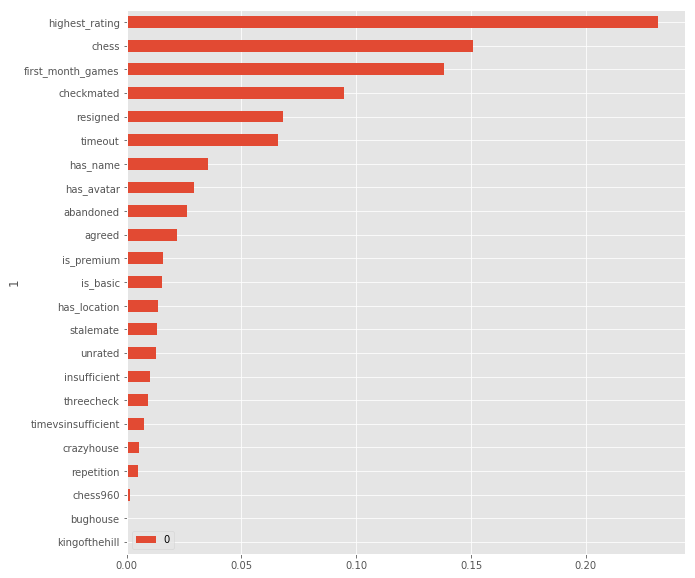

In [38]:
def rf_best_features(X, y, n_features):
    
    x_columns = X

    y_true = y

    rf_model = RandomForestClassifier(n_estimators=100)
    
    rf_model.fit(x_columns, y_true)
    
    feature_importances = {}
    
    for i in range(len(rf_model.feature_importances_)):
        
        feature_importances[x_columns.columns[i]] = rf_model.feature_importances_[i]
    
    
    top_features = Counter(feature_importances).most_common(n_features)
    
    values = [feature[1] for feature in top_features]
    
    features = [feature[0] for feature in top_features]
    
    return values, features


def plot_best_features(values, features, figsize_x=10, figsize_y=10):
    
    new_df = pd.DataFrame(list(zip(values,features))).set_index(1).sort_values(0)

    new_df.plot.barh(figsize=(figsize_x,figsize_y))

values, features = rf_best_features(X_test, y_test, 26)
plot_best_features(values, features)

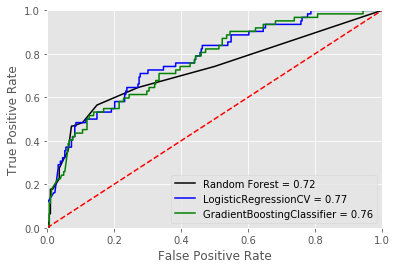

In [70]:
fig, ax = plt.subplots()

rand_y_pred = random_forest_testrun.predict_proba(X_test)

rand_fpr, rand_tpr, rand_threshold = roc_curve(y_test, rand_y_pred[:,1])
rand_area_under_curve = auc(rand_fpr, rand_tpr)

logistic_y_pred = logistic_model.predict_proba(X_test)

logistic_fpr, logistic_tpr, logistic_threshold = roc_curve(y_test, logistic_y_pred[:,1])
logistic_area_under_curve = auc(logistic_fpr, logistic_tpr)

gradient_y_pred = gradient_boost.predict_proba(X_test)

gradient_fpr, gradient_tpr, gradient_threshold = roc_curve(y_test, gradient_y_pred[:,1])
gradient_area_under_curve = auc(gradient_fpr, gradient_tpr)

ax.plot(rand_fpr, rand_tpr, 'k', label = f'Random Forest = {rand_area_under_curve:.2f}')
ax.plot(logistic_fpr, logistic_tpr, 'b', label = f'LogisticRegressionCV = {logistic_area_under_curve:.2f}')
ax.plot(gradient_fpr, gradient_tpr, 'g', label = f'GradientBoostingClassifier = {gradient_area_under_curve:.2f}')

ax.legend(loc = 'lower right')
ax.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('AUC')
plt.show()


# # plot_roc([random_forest_testrun, gradient_boost, logistic_model], X_test, y_test)
# plot_roc(random_forest_testrun, X_test, y_test)
# plot_roc(gradient_boost, X_test, y_test)
# plot_roc(logistic_model, X_test, y_test)